In [5]:
import coba as cb
import torch
from pathlib import Path
from collections import defaultdict, Counter
from itertools import islice, chain, count, product, repeat
from contextlib import nullcontext

data_dir = "../data"

import coba as cb

import warnings

import time
import csv
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator
from sklearn.preprocessing import RobustScaler, QuantileTransformer, MinMaxScaler, StandardScaler, Binarizer
from sklearn.feature_selection import  mutual_info_classif, f_classif, GenericUnivariateSelect
from sklearn.model_selection import cross_validate, cross_val_predict, StratifiedKFold, GridSearchCV, LeaveOneGroupOut, StratifiedShuffleSplit
from sklearn.metrics import balanced_accuracy_score, mean_squared_error, mean_absolute_error
from sklearn.pipeline import Pipeline

import torch
from parameterfree import COCOB

from sklearn.dummy import DummyRegressor, DummyClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from xgboost import XGBClassifier

from concurrent.futures import ProcessPoolExecutor

import torch
import torch.utils
import torch.utils.data
import coba as cb
from typing import Tuple, Optional

try:
    torch.set_num_threads(3)
    torch.set_num_interop_threads(3)
except RuntimeError:
    pass

c0 = "#444"
c1 = "#0072B2"
c2 = "#E69F00"
c3 = "#009E73"
c4 = "#56B4E9"
c5 = "#D55E00"
c6 = "#F0E442"
c7 = "#CC79A7"
c8 = "#000000"
c9 = "#332288"

torch.set_default_device('cpu')
plt.rc('font', **{'size': 20})

df = pd.read_csv(f"{data_dir}/all_features_1h_v3.csv")

G  = df["id_participant"].to_numpy()
X1 = df[[c for c in df.columns if c.startswith("acc_")]].to_numpy()
#X2 = df[[c for c in df.columns if c.startswith("acc_") or c.startswith("gps_")]].to_numpy()
X2 = df[[c for c in df.columns if c.startswith("acc_") or c.startswith("gps_") or c.startswith("motion_")]].to_numpy()
Y1 =  df["ER_desire"].astype(float).to_numpy()
Y2 = (df["INT_availability"] == "yes").astype(float).to_numpy()

no_na = ~(np.isnan(X2).any(axis=1) | np.isnan(Y1) | np.isnan(Y2))
#no_na = ~(np.isnan(Y2))

G  = G [no_na]
X1 = np.nan_to_num(X1[no_na])
X2 = np.nan_to_num(X2[no_na])
X3 = X2.copy()
X4 = X2.copy()
Y1 = Y1[no_na]
Y2 = Y2[no_na]

for g in set(G):
    Y1[G == g] = Binarizer(threshold=np.median(Y1[G == g])).fit_transform(np.expand_dims(Y1[G == g],axis=1)).squeeze()
    X1[G == g] = StandardScaler().fit_transform(X1[G == g])
    X2[G == g] = StandardScaler().fit_transform(X2[G == g])
    X3[G == g] = StandardScaler().fit_transform(X3[G == g])
    X4[G == g] = StandardScaler().fit_transform(X4[G == g])

X3 = np.concatenate([X3, np.expand_dims((df["Platform"] == "Android").astype(float).to_numpy(),1)[no_na]],axis=1)
X3 = np.concatenate([X3, np.expand_dims((df["Platform"] == "iPhone" ).astype(float).to_numpy(),1)[no_na]],axis=1)

X4 = np.concatenate([X4, np.expand_dims((df["Platform"] == "Android").astype(float).to_numpy(),1)[no_na]],axis=1)
X4 = np.concatenate([X4, np.expand_dims((df["Platform"] == "iPhone" ).astype(float).to_numpy(),1)[no_na]],axis=1)
X4 = np.concatenate([X4, np.expand_dims((df["tag"] == "evening" ).astype(float).to_numpy(),1)[no_na]],axis=1)
X4 = np.concatenate([X4, np.expand_dims((df["tag"] == "morning" ).astype(float).to_numpy(),1)[no_na]],axis=1)
X4 = np.concatenate([X4, np.expand_dims((df["tag"] == "afternoon" ).astype(float).to_numpy(),1)[no_na]],axis=1)


In [57]:
SimpleImputer().fit_transform(X2[G == g])

/home/mrucker/miniconda3/envs/diss/lib/python3.10/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: [55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71]. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


array([[ 1.00518128e+00,  2.45582101e-02,  3.64903095e-01, ...,
         0.00000000e+00,  6.00000000e+01,  0.00000000e+00],
       [ 1.00332704e+00,  4.72054940e-02,  6.71919228e-01, ...,
         0.00000000e+00,  6.00166667e+01,  0.00000000e+00],
       [ 1.01998708e+00,  9.14314127e-02,  4.39843762e-01, ...,
         0.00000000e+00,  6.00000000e+01,  0.00000000e+00],
       ...,
       [ 1.00626014e+00,  3.07926668e-02,  7.37392646e-01, ...,
         1.00000000e+00,  0.00000000e+00,  3.96471651e+01],
       [ 9.97922001e-01,  4.65072897e-02,  6.08487382e-01, ...,
         1.00000000e+00,  0.00000000e+00,  1.61934903e+01],
       [-1.00000000e+00, -1.00000000e+00, -1.00000000e+00, ...,
         1.00000000e+00,  0.00000000e+00,  9.40978222e+00]])

In [17]:
#str(list(df.columns))
df

,id_participant,timestamp_local,date_local,tag,day,valid_day_method1,valid_day_method2,acc_magnitude_mean,acc_magnitude_std,acc_magnitude_min,...,INT_Support,INT_Goals,INT_Other,INT_Other_freeResponse,sleep_duration,sleep_quality,interactions_quality,pain,forecasting,Platform
0,1,2023-08-02 19:42:00,2023-08-02,evening,1,0,0,1.005181,0.024558,0.364903,...,0.0,0.0,0.0,NaN,Not Assessed,Not Assessed,1.0,1.0,0.0,Android
1,1,2023-08-03 20:08:00,2023-08-03,evening,2,1,1,1.003327,0.047205,0.671919,...,0.0,0.0,0.0,NaN,Not Assessed,Not Assessed,1.0,1.0,0.0,Android
2,1,2023-08-03 08:56:00,2023-08-03,morning,2,1,1,1.019987,0.091431,0.439844,...,0.0,0.0,0.0,NaN,9,5,1.0,1.0,0.0,Android
3,1,2023-08-04 14:33:00,2023-08-04,afternoon,3,1,1,1.004549,0.021438,0.349811,...,NaN,NaN,NaN,NaN,Not Assessed,Not Assessed,1.0,1.0,0.0,Android
4,1,2023-08-04 09:32:00,2023-08-04,morning,3,1,1,1.041066,0.152465,0.497542,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Android
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23061,1030,2024-05-12 20:49:00,2024-05-12,evening,35,1,1,NaN,NaN,NaN,...,0.0,1.0,0.0,NaN,Not Assessed,Not Assessed,10.0,0.0,10.0,Android
23062,1030,2024-05-12 09:01:00,2024-05-12,morning,35,1,1,NaN,NaN,NaN,...,0.0,0.0,1.0,getting over feeling bad,9,10,10.0,1.0,10.0,Android
23063,1030,2024-05-13 13:59:00,2024-05-13,afternoon,36,0,0,NaN,NaN,NaN,...,0.0,0.0,0.0,NaN,Not Assessed,Not Assessed,10.0,0.0,10.0,Android
23064,1030,2024-05-13 20:34:00,2024-05-13,evening,36,0,0,NaN,NaN,NaN,...,0.0,1.0,0.0,NaN,Not Assessed,Not Assessed,10.0,0.0,10.0,Android


In [ ]:
import coba as cb

class FeedForward(torch.nn.Sequential):
    """A Generic implementation of Feedforward Neural Network"""

    class SkipModule(torch.nn.Module):
        def __init__(self, layers):
            super().__init__()
            self.layers = layers
        def forward(self,X):
            return X + self.layers(X)

    def make_layer(self,curr_dim,spec):
        if isinstance(spec,float):
            return torch.nn.Dropout(spec), curr_dim
        if curr_dim is None and isinstance(spec,int):
            return None, spec
        if isinstance(spec,int):
            return torch.nn.Linear(curr_dim,spec),spec
        if spec == 'r':
            return torch.nn.ReLU(),curr_dim
        if spec == 'l':
            return torch.nn.LayerNorm(curr_dim),curr_dim
        if spec == 'b':
            return torch.nn.BatchNorm1d(curr_dim), curr_dim
        if spec == 's':
            return torch.nn.Sigmoid(),curr_dim
        if isinstance(spec,list):                
            return FeedForward.SkipModule(FeedForward([curr_dim] + spec)), curr_dim
        raise Exception("Bad Layer")

    def __init__(self, specs, rng=1):
        """Instantiate a Feedfoward network according to specifications.

        Args:
            specs: A sequence of layer specifications as follows:
                -1 -- replaced with the input feature width
                <int> -- a LinearLayer with output width equal to <int>
                [0,1] -- a Dropout layer with the given probability
                'l' -- a LayerNorm
                'b' -- a BatchNorm1d
                'r' -- a ReLU layer
                's' -- a Sigmoid layer
                [] -- a skip layer with the given specifications
        """

        torch.manual_seed(rng)
        layers,width = [],None
        for spec in specs:
            layer,width = self.make_layer(width,spec)
            if layer: layers.append(layer)
        super().__init__(*(layers or [torch.nn.Identity()]))
        self.params = {"specs": specs, "rng": rng }

class MyEnvironment:
    def __init__(self, train_X, train_Y, test_X, test_Y, g, sr, rng):
        self.params = {'pid': g, 'rng': rng, 'sr': sr}
        self.train_X = train_X
        self.train_Y = train_Y.float()
        self.test_X = test_X
        self.test_Y = test_Y.float()

    def ssl(self,neg):
        anchor, positive, negative = [], [], []
        by_class  = {y: self.train_X[(self.train_Y==y)].tolist() for y in set(self.train_Y.tolist())}
        rng = cb.CobaRandom(self.params['rng'])

        def choose_unique(items,item):
            while items[i:=rng.randint(0,len(items)-1)]==item:
                pass
            return items[i]

        def choose_n(items,n):
            return [ items[i] for i in rng.shuffle(range(len(items)))[:n] ]

        for _ in range(self.params['sr']):
            for x,y in zip(self.train_X.tolist(),self.train_Y.tolist()):
                anchor.append(x)
                positive.append(choose_unique(by_class[y],x))
                negative.append(choose_n(by_class[1-y],neg))

        return torch.tensor(anchor).float(), torch.tensor(positive).float(), torch.tensor(negative).float()

    def train(self):
        return self.train_X, self.train_Y

    def test(self):
        rng_indexes = cb.CobaRandom(self.params['rng']).shuffle(range(len(self.test_X)))
        return self.test_X[rng_indexes,:], self.test_Y[rng_indexes]

class MyEvaluator:
    def __init__(self, specs1, specs2, specs3, ws, ssl, neg, er, lr):
        self.specs1 = specs1
        self.specs2 = specs2
        self.specs3 = specs3
        self.ws = ws
        self.ssl = ssl
        self.neg = neg
        self.er = er
        self.lr = lr
        self.params = {'specs1': specs1, 'specs2': specs2, 'specs3': specs3, 'ws':ws, 'ssl': ssl, 'neg': neg, 'er': er, 'lr': lr }

    def evaluate(self, env, lrn):
        from sklearn.metrics import roc_auc_score
        from sklearn.ensemble import RandomForestClassifier
        torch.set_num_threads(1)

        f = FeedForward(self.specs1)
        g = FeedForward(self.specs2)
        h = FeedForward(self.specs3) if self.specs3 != ('rf',) else RandomForestClassifier()

        f.train()
        g.train()

        if self.ssl:
            A, P, N = env.ssl(self.neg)

            torch_dataset = torch.utils.data.TensorDataset(A,P,N)
            torch_loader  = torch.utils.data.DataLoader(torch_dataset,batch_size=32,drop_last=True,shuffle=True)

            opt = COCOB(chain(f.parameters(),g.parameters()))

            for _ in range(self.ssl):
                for _A, _P, _N in torch_loader:
                    #https://arxiv.org/pdf/2002.05709
                    _A = g(f(_A))
                    _P = g(f(_P))
                    _N = g(f(_N))

                    p = torch.einsum("bi,bi->b",_A,_P)
                    n = torch.einsum("bi,bji->bj",_A,_N)
                    
                    p /= (torch.linalg.norm(_A,dim=1)*torch.linalg.norm(_P,dim=1))
                    n /= (torch.linalg.norm(_A,dim=1).unsqueeze(1)*torch.linalg.norm(_N,dim=2))

                    p = torch.exp(p)
                    n = torch.exp(n)

                    opt.zero_grad()
                    (-torch.log(p/(p+n.sum(dim=1)))).sum().backward()
                    opt.step()

        if self.ws:
            X, Y = env.train()

            if isinstance(h,RandomForestClassifier):
                with torch.no_grad():
                    h.fit(f(X),Y)
            else:
                h.train()

                opt  = COCOB(h.parameters())
                loss = torch.nn.BCEWithLogitsLoss()

                trn,val = next(StratifiedShuffleSplit(1, train_size=.5).split(X,Y))

                ws_trn_X = X[trn]
                ws_trn_y = Y[trn].unsqueeze(1)
                ws_val_X = X[val]
                ws_val_y = Y[val].unsqueeze(1)

                torch_dataset = torch.utils.data.TensorDataset(ws_trn_X,ws_trn_y)
                torch_loader  = torch.utils.data.DataLoader(torch_dataset,batch_size=16,drop_last=True,shuffle=True)

                val_losses = []

                with torch.no_grad():
                    val_losses.append(loss(h(f(ws_val_X)),ws_val_y))

                for _ in range(50):
                    for _X,_y in torch_loader:
                        opt.zero_grad()
                        loss(h(f(_X)),_y).backward()
                        opt.step()
                    with torch.no_grad():
                        val_losses.append(loss(h(f(ws_val_X)),ws_val_y))
                        if len(val_losses) > 4 and np.median(val_losses[-5:-1]) < np.median(val_losses[-4:]):
                            break

        f.eval()
        g.eval()

        def learn(x,y,backs):
            backs +=1
            if self.lr:
                loss(h(f(x)).squeeze(),y).backward()
                if backs % self.lr == 0:
                    opt.step()
                    opt.zero_grad()
            return backs

        if not isinstance(h,RandomForestClassifier):
            h.eval()
            opt  = COCOB(h.parameters())
            loss = torch.nn.BCEWithLogitsLoss()

        X, Y = env.test()

        if len(set(Y.tolist())) == 1:
            print("Only one class present in y_true. ROC AUC score is not defined in that case.")
            return

        rng = cb.CobaRandom(1)
        while len(set(Y[-10:].tolist())) == 1:
            ind = rng.shuffle(range(len(Y)))
            X = X[ind,:]
            Y = Y[ind]

        backs = 0
        experiences = []
        for i in range(35):
            with torch.no_grad():
                if isinstance(h, RandomForestClassifier):
                    yield {'auc': roc_auc_score(Y[35:],torch.sigmoid(torch.tensor(h.predict(f(X[35:,:])))))}
                else:
                    yield {'auc': roc_auc_score(Y[35:],torch.sigmoid(h(f(X[35:,:]))))}

            x,y = X[i,:], Y[i]
            backs = learn(x,y,backs)
            if self.er: 
                experiences.append([x,y,4])
            if len(experiences) > self.er:
                rng.shuffle(experiences, inplace=True)
                for j in range(self.lr-1,-1,-1):
                    x,y,n = experiences[j]
                    backs = learn(x,y,backs)                    
                    if n == 1: experiences.pop(j)
                    else: experiences[j] = [x,y,n-1]

def make_envs(X, Y, G):
    X, Y, G = torch.tensor(X).float(), torch.tensor(Y).float(), torch.tensor(G)
    envs = []
    for g in set(G.tolist()):
        if (g==G).sum() < 50: continue
        trn_x,trn_y = X[g!=G],Y[g!=G]
        tst_x,tst_y = X[g==G],Y[g==G]

        if len(set(tst_y.tolist())) == 1:
            print(f"All Equal, no environment added for {g}")
        else:
            for rng in range(1):
                envs.append(MyEnvironment(trn_x,trn_y,tst_x,tst_y,g,1,rng))
    return envs

r = lambda w:  ['l', 'r', w, 'l', 'r', w]

envs = make_envs(X1,Y1,G)
lrns = [ FeedForward(specs=[], rng=1) ]
vals = [
    MyEvaluator((), (), (len(X1[0]), 30, 'l', 'r', 30, 'l', 'r', 1), False, 0 , 0, 0, 0),
    MyEvaluator((), (), (len(X1[0]), 30, 'l', 'r', 30, 'l', 'r', 1), True , 0 , 0, 0, 0),
    MyEvaluator((), (), ('rf',), True , 0 , 0, 0, 0),
]

cb.Experiment(envs,lrns,vals).run('../logs/out1.log',processes=35,quiet=True)

All Equal, no environment added for 24
All Equal, no environment added for 25
All Equal, no environment added for 146
All Equal, no environment added for 178
All Equal, no environment added for 357
All Equal, no environment added for 447
All Equal, no environment added for 469
{'Learners': 1, 'Environments': 200, 'Interactions': 21000}


In [ ]:
import coba as cb

class FeedForward(torch.nn.Sequential):
    """A Generic implementation of Feedforward Neural Network"""

    class SkipModule(torch.nn.Module):
        def __init__(self, layers):
            super().__init__()
            self.layers = layers
        def forward(self,X):
            return X + self.layers(X)

    def make_layer(self,curr_dim,spec):
        if isinstance(spec,float):
            return torch.nn.Dropout(spec), curr_dim
        if curr_dim is None and isinstance(spec,int):
            return None, spec
        if isinstance(spec,int):
            return torch.nn.Linear(curr_dim,spec),spec
        if spec == 'r':
            return torch.nn.ReLU(),curr_dim
        if spec == 'l':
            return torch.nn.LayerNorm(curr_dim),curr_dim
        if spec == 'b':
            return torch.nn.BatchNorm1d(curr_dim), curr_dim
        if spec == 's':
            return torch.nn.Sigmoid(),curr_dim
        if isinstance(spec,list):                
            return FeedForward.SkipModule(FeedForward([curr_dim] + spec)), curr_dim
        raise Exception("Bad Layer")

    def __init__(self, specs, rng=1):
        """Instantiate a Feedfoward network according to specifications.

        Args:
            specs: A sequence of layer specifications as follows:
                -1 -- replaced with the input feature width
                <int> -- a LinearLayer with output width equal to <int>
                [0,1] -- a Dropout layer with the given probability
                'l' -- a LayerNorm
                'b' -- a BatchNorm1d
                'r' -- a ReLU layer
                's' -- a Sigmoid layer
                [] -- a skip layer with the given specifications
        """

        torch.manual_seed(rng)
        layers,width = [],None
        for spec in specs:
            layer,width = self.make_layer(width,spec)
            if layer: layers.append(layer)
        super().__init__(*(layers or [torch.nn.Identity()]))
        self.params = {"specs": specs, "rng": rng }

class MyEnvironment:
    def __init__(self, train_X, train_Y, test_X, test_Y, g, sr, rng):
        self.params = {'pid': g, 'rng': rng, 'sr': sr}
        self.train_X = train_X
        self.train_Y = train_Y.float()
        self.test_X = test_X
        self.test_Y = test_Y.float()

    def ssl(self,neg):
        anchor, positive, negative = [], [], []
        by_class  = {y: self.train_X[(self.train_Y==y)].tolist() for y in set(self.train_Y.tolist())}
        rng = cb.CobaRandom(self.params['rng'])

        def choose_unique(items,item):
            while items[i:=rng.randint(0,len(items)-1)]==item:
                pass
            return items[i]

        def choose_n(items,n):
            return [ items[i] for i in rng.shuffle(range(len(items)))[:n] ]

        for _ in range(self.params['sr']):
            for x,y in zip(self.train_X.tolist(),self.train_Y.tolist()):
                anchor.append(x)
                positive.append(choose_unique(by_class[y],x))
                negative.append(choose_n(by_class[1-y],neg))

        return torch.tensor(anchor).float(), torch.tensor(positive).float(), torch.tensor(negative).float()

    def train(self):
        return self.train_X, self.train_Y

    def test(self):
        rng_indexes = cb.CobaRandom(self.params['rng']).shuffle(range(len(self.test_X)))
        return self.test_X[rng_indexes,:], self.test_Y[rng_indexes]

class MyEvaluator:
    def __init__(self, specs1, specs2, specs3, ws, ssl, neg, er, lr, nr):
        self.specs1 = specs1
        self.specs2 = specs2
        self.specs3 = specs3
        self.ws = ws
        self.ssl = ssl
        self.neg = neg
        self.er = er
        self.lr = lr
        self.nr = nr
        self.params = {'specs1': specs1, 'specs2': specs2, 'specs3': specs3, 'ws':ws, 'ssl': ssl, 'neg': neg, 'er': er, 'lr': lr, 'nr': nr }

    def evaluate(self, env, lrn):
        from sklearn.metrics import roc_auc_score
        from sklearn.ensemble import RandomForestClassifier
        torch.set_num_threads(1)

        f = FeedForward(self.specs1)
        g = FeedForward(self.specs2)
        h = FeedForward(self.specs3) if self.specs3 != ('rf',) else RandomForestClassifier()

        f.train()
        g.train()

        if self.ssl:
            A, P, N = env.ssl(self.neg)

            torch_dataset = torch.utils.data.TensorDataset(A,P,N)
            torch_loader  = torch.utils.data.DataLoader(torch_dataset,batch_size=32,drop_last=True,shuffle=True)

            opt = COCOB(chain(f.parameters(),g.parameters()))

            for _ in range(self.ssl):
                for _A, _P, _N in torch_loader:
                    #https://arxiv.org/pdf/2002.05709
                    _A = g(f(_A))
                    _P = g(f(_P))
                    _N = g(f(_N))

                    p = torch.einsum("bi,bi->b",_A,_P)
                    n = torch.einsum("bi,bji->bj",_A,_N)
                    
                    p /= (torch.linalg.norm(_A,dim=1)*torch.linalg.norm(_P,dim=1))
                    n /= (torch.linalg.norm(_A,dim=1).unsqueeze(1)*torch.linalg.norm(_N,dim=2))

                    p = torch.exp(p)
                    n = torch.exp(n)

                    opt.zero_grad()
                    (-torch.log(p/(p+n.sum(dim=1)))).sum().backward()
                    opt.step()

        if self.ws:
            X, Y = env.train()

            if isinstance(h,RandomForestClassifier):
                with torch.no_grad():
                    h.fit(f(X),Y)
            else:
                h.train()

                opt  = COCOB(h.parameters())
                loss = torch.nn.BCEWithLogitsLoss()

                trn,val = next(StratifiedShuffleSplit(1, train_size=.5).split(X,Y))

                ws_trn_X = X[trn]
                ws_trn_y = Y[trn].unsqueeze(1)
                ws_val_X = X[val]
                ws_val_y = Y[val].unsqueeze(1)

                torch_dataset = torch.utils.data.TensorDataset(ws_trn_X,ws_trn_y)
                torch_loader  = torch.utils.data.DataLoader(torch_dataset,batch_size=16,drop_last=True,shuffle=True)

                val_losses = []

                with torch.no_grad():
                    val_losses.append(loss(h(f(ws_val_X)),ws_val_y))

                for _ in range(50):
                    for _X,_y in torch_loader:
                        opt.zero_grad()
                        loss(h(f(_X)),_y).backward()
                        opt.step()
                    with torch.no_grad():
                        val_losses.append(loss(h(f(ws_val_X)),ws_val_y))
                        if len(val_losses) > 4 and np.median(val_losses[-5:-1]) < np.median(val_losses[-4:]):
                            break

        f.eval()
        g.eval()

        def learn(x,y,backs):
            backs +=1
            if self.lr:
                loss(h(f(x)).squeeze(),y).backward()
                if backs % self.lr == 0:
                    opt.step()
                    opt.zero_grad()
            return backs

        if not isinstance(h,RandomForestClassifier):
            h.eval()
            opt  = COCOB(h.parameters())
            loss = torch.nn.BCEWithLogitsLoss()

        X, Y = env.test()

        if len(set(Y.tolist())) == 1:
            print("Only one class present in y_true. ROC AUC score is not defined in that case.")
            return

        rng = cb.CobaRandom(1)
        while len(set(Y[-10:].tolist())) == 1:
            ind = rng.shuffle(range(len(Y)))
            X = X[ind,:]
            Y = Y[ind]

        backs = 0
        experiences = []
        for i in range(35):
            with torch.no_grad():
                if isinstance(h, RandomForestClassifier):
                    yield {'auc': roc_auc_score(Y[35:],torch.sigmoid(torch.tensor(h.predict(f(X[35:,:])))))}
                else:
                    yield {'auc': roc_auc_score(Y[35:],torch.sigmoid(h(f(X[35:,:]))))}

            x,y = X[i,:], Y[i]
            backs = learn(x,y,backs)
            if self.er: 
                experiences.append([x,y,self.nr])
            if len(experiences) > self.er:
                rng.shuffle(experiences, inplace=True)
                for j in range(self.lr-1,-1,-1):
                    x,y,n = experiences[j]
                    backs = learn(x,y,backs)                    
                    if n == 1: experiences.pop(j)
                    else: experiences[j] = [x,y,n-1]

def make_envs(X, Y, G):
    X, Y, G = torch.tensor(X).float(), torch.tensor(Y).float(), torch.tensor(G)
    envs = []
    for g in set(G.tolist()):
        if (g==G).sum() < 50: continue
        trn_x,trn_y = X[g!=G],Y[g!=G]
        tst_x,tst_y = X[g==G],Y[g==G]

        if len(set(tst_y.tolist())) == 1:
            print(f"All Equal, no environment added for {g}")
        else:
            for rng in range(1):
                envs.append(MyEnvironment(trn_x,trn_y,tst_x,tst_y,g,1,rng))
    return envs

r = lambda w:  ['l', 'r', w, 'l', 'r', w]

envs = make_envs(X1,Y1,G)
lrns = [ FeedForward(specs=[], rng=1) ]
vals = [
    #MyEvaluator((), (), (len(X[0]), 30, 'l', 'r', 30, 'l', 'r', 1), True , 2, 5, 0 , 0),
    MyEvaluator((len(X1[0]), 15, 'l', 'r', 15), (15, 'l', 'r', 30), (15,'l','r',30,'l','r',1), True, 2, 5, 15, 8, 15),
    MyEvaluator((len(X1[0]), 15, 'l', 'r', 15), (15, 'l', 'r', 30), (15,'l','r',30,'l','r',1), True, 2, 5, 0, 0, 0),
    MyEvaluator((), (), (len(X1[0]), 30, 'l', 'r', 30, 'l', 'r', 1), False, 0, 0, 0 , 0, 0),
    MyEvaluator((), (), (len(X1[0]), 30, 'l', 'r', 30, 'l', 'r', 1), True , 0, 0, 0 , 0, 0),
    MyEvaluator((), (), (len(X1[0]), 30, 'l', 'r', 30, 'l', 'r', 1), True , 0, 0, 15 , 8, 15),
    MyEvaluator((), (), (len(X1[0]), 30, 'l', 'r', 30, 'l', 'r', 1), True , 0, 0, 15 , 8, 15),
    MyEvaluator((), (), (len(X1[0]), 30, 'l', 'r', 30, 'l', 'r', 1), True , 0, 0, 15 , 8, 1),
]

cb.Experiment(envs,lrns,vals).run('../logs/out2.log',processes=35,quiet=True)

envs = make_envs(X1,Y2,G)

cb.Experiment(envs,lrns,vals).run('../logs/out2b.log',processes=35,quiet=True)


All Equal, no environment added for 24
All Equal, no environment added for 25
All Equal, no environment added for 146
All Equal, no environment added for 178
All Equal, no environment added for 357
All Equal, no environment added for 447
All Equal, no environment added for 469
All Equal, no environment added for 2
All Equal, no environment added for 25
All Equal, no environment added for 82
All Equal, no environment added for 87
All Equal, no environment added for 89
All Equal, no environment added for 99
All Equal, no environment added for 103
All Equal, no environment added for 111
All Equal, no environment added for 117
All Equal, no environment added for 146
All Equal, no environment added for 196
All Equal, no environment added for 227
All Equal, no environment added for 246
All Equal, no environment added for 311
All Equal, no environment added for 357
All Equal, no environment added for 377
All Equal, no environment added for 390
All Equal, no environment added for 451
All Equal

In [ ]:
import coba as cb

class FeedForward(torch.nn.Sequential):
    """A Generic implementation of Feedforward Neural Network"""

    class SkipModule(torch.nn.Module):
        def __init__(self, layers):
            super().__init__()
            self.layers = layers
        def forward(self,X):
            return X + self.layers(X)

    def make_layer(self,curr_dim,spec):
        if isinstance(spec,float):
            return torch.nn.Dropout(spec), curr_dim
        if curr_dim is None and isinstance(spec,int):
            return None, spec
        if isinstance(spec,int):
            return torch.nn.Linear(curr_dim,spec),spec
        if spec == 'r':
            return torch.nn.ReLU(),curr_dim
        if spec == 'l':
            return torch.nn.LayerNorm(curr_dim),curr_dim
        if spec == 'b':
            return torch.nn.BatchNorm1d(curr_dim), curr_dim
        if spec == 's':
            return torch.nn.Sigmoid(),curr_dim
        if isinstance(spec,list):                
            return FeedForward.SkipModule(FeedForward([curr_dim] + spec)), curr_dim
        raise Exception("Bad Layer")

    def __init__(self, specs, rng=1):
        """Instantiate a Feedfoward network according to specifications.

        Args:
            specs: A sequence of layer specifications as follows:
                -1 -- replaced with the input feature width
                <int> -- a LinearLayer with output width equal to <int>
                [0,1] -- a Dropout layer with the given probability
                'l' -- a LayerNorm
                'b' -- a BatchNorm1d
                'r' -- a ReLU layer
                's' -- a Sigmoid layer
                [] -- a skip layer with the given specifications
        """

        torch.manual_seed(rng)
        layers,width = [],None
        for spec in specs:
            layer,width = self.make_layer(width,spec)
            if layer: layers.append(layer)
        super().__init__(*(layers or [torch.nn.Identity()]))
        self.params = {"specs": specs, "rng": rng }

class MyEnvironment:
    def __init__(self, train_X, train_Y, test_X, test_Y, g, sr, rng):
        self.params = {'pid': g, 'rng': rng, 'sr': sr}
        self.train_X = train_X
        self.train_Y = train_Y.float()
        self.test_X = test_X
        self.test_Y = test_Y.float()

    def ssl(self,neg):
        anchor, positive, negative = [], [], []
        by_class  = {y: self.train_X[(self.train_Y==y)].tolist() for y in set(self.train_Y.tolist())}
        rng = cb.CobaRandom(self.params['rng'])

        def choose_unique(items,item):
            while items[i:=rng.randint(0,len(items)-1)]==item:
                pass
            return items[i]

        def choose_n(items,n):
            return [ items[i] for i in rng.shuffle(range(len(items)))[:n] ]

        for _ in range(self.params['sr']):
            for x,y in zip(self.train_X.tolist(),self.train_Y.tolist()):
                anchor.append(x)
                positive.append(choose_unique(by_class[y],x))
                negative.append(choose_n(by_class[1-y],neg))

        return torch.tensor(anchor).float(), torch.tensor(positive).float(), torch.tensor(negative).float()

    def train(self):
        return self.train_X, self.train_Y

    def test(self):
        rng_indexes = cb.CobaRandom(self.params['rng']).shuffle(range(len(self.test_X)))
        return self.test_X[rng_indexes,:], self.test_Y[rng_indexes]

class MyEvaluator:
    def __init__(self, specs1, specs2, specs3, ws, ssl, neg, er, lr, nr):
        self.specs1 = specs1
        self.specs2 = specs2
        self.specs3 = specs3
        self.ws = ws
        self.ssl = ssl
        self.neg = neg
        self.er = er
        self.lr = lr
        self.nr = nr
        self.params = {'specs1': specs1, 'specs2': specs2, 'specs3': specs3, 'ws':ws, 'ssl': ssl, 'neg': neg, 'er': er, 'lr': lr, 'nr': nr }

    def evaluate(self, env, lrn):
        from sklearn.metrics import roc_auc_score
        from sklearn.ensemble import RandomForestClassifier
        torch.set_num_threads(1)

        f = FeedForward(self.specs1)
        g = FeedForward(self.specs2)
        h = FeedForward(self.specs3) if self.specs3 != ('rf',) else RandomForestClassifier()

        f.train()
        g.train()

        if self.ssl:
            A, P, N = env.ssl(self.neg)

            torch_dataset = torch.utils.data.TensorDataset(A,P,N)
            torch_loader  = torch.utils.data.DataLoader(torch_dataset,batch_size=32,drop_last=True,shuffle=True)

            opt = COCOB(chain(f.parameters(),g.parameters()))

            for _ in range(self.ssl):
                for _A, _P, _N in torch_loader:
                    #https://arxiv.org/pdf/2002.05709
                    _A = g(f(_A))
                    _P = g(f(_P))
                    _N = g(f(_N))

                    p = torch.einsum("bi,bi->b",_A,_P)
                    n = torch.einsum("bi,bji->bj",_A,_N)
                    
                    p /= (torch.linalg.norm(_A,dim=1)*torch.linalg.norm(_P,dim=1))
                    n /= (torch.linalg.norm(_A,dim=1).unsqueeze(1)*torch.linalg.norm(_N,dim=2))

                    p = torch.exp(p)
                    n = torch.exp(n)

                    opt.zero_grad()
                    (-torch.log(p/(p+n.sum(dim=1)))).sum().backward()
                    opt.step()

        if self.ws:
            X, Y = env.train()

            if isinstance(h,RandomForestClassifier):
                with torch.no_grad():
                    h.fit(f(X),Y)
            else:
                h.train()

                opt  = COCOB(h.parameters())
                loss = torch.nn.BCEWithLogitsLoss()

                trn,val = next(StratifiedShuffleSplit(1, train_size=.5).split(X,Y))

                ws_trn_X = X[trn]
                ws_trn_y = Y[trn].unsqueeze(1)
                ws_val_X = X[val]
                ws_val_y = Y[val].unsqueeze(1)

                torch_dataset = torch.utils.data.TensorDataset(ws_trn_X,ws_trn_y)
                torch_loader  = torch.utils.data.DataLoader(torch_dataset,batch_size=16,drop_last=True,shuffle=True)

                val_losses = []

                with torch.no_grad():
                    val_losses.append(loss(h(f(ws_val_X)),ws_val_y))

                for _ in range(50):
                    for _X,_y in torch_loader:
                        opt.zero_grad()
                        loss(h(f(_X)),_y).backward()
                        opt.step()
                    with torch.no_grad():
                        val_losses.append(loss(h(f(ws_val_X)),ws_val_y))
                        if len(val_losses) > 4 and np.median(val_losses[-5:-1]) < np.median(val_losses[-4:]):
                            break

        f.eval()
        g.eval()

        def learn(x,y,backs):
            backs +=1
            if self.lr:
                loss(h(f(x)).squeeze(),y).backward()
                if backs % self.lr == 0:
                    opt.step()
                    opt.zero_grad()
            return backs

        if not isinstance(h,RandomForestClassifier):
            h.eval()
            opt  = COCOB(h.parameters())
            loss = torch.nn.BCEWithLogitsLoss()

        X, Y = env.test()

        if len(set(Y.tolist())) == 1:
            print("Only one class present in y_true. ROC AUC score is not defined in that case.")
            return

        rng = cb.CobaRandom(1)
        while len(set(Y[-10:].tolist())) == 1:
            ind = rng.shuffle(range(len(Y)))
            X = X[ind,:]
            Y = Y[ind]

        backs = 0
        experiences = []
        for i in range(35):
            with torch.no_grad():
                if isinstance(h, RandomForestClassifier):
                    yield {'auc': roc_auc_score(Y[35:],torch.sigmoid(torch.tensor(h.predict(f(X[35:,:])))))}
                else:
                    yield {'auc': roc_auc_score(Y[35:],torch.sigmoid(h(f(X[35:,:]))))}

            x,y = X[i,:], Y[i]
            backs = learn(x,y,backs)
            if self.er: 
                experiences.append([x,y,self.nr])
            if len(experiences) > self.er:
                rng.shuffle(experiences, inplace=True)
                for j in range(self.lr-1,-1,-1):
                    x,y,n = experiences[j]
                    backs = learn(x,y,backs)                    
                    if n == 1: experiences.pop(j)
                    else: experiences[j] = [x,y,n-1]

def make_envs(X, Y, G):
    X, Y, G = torch.tensor(X).float(), torch.tensor(Y).float(), torch.tensor(G)
    all_equal = []
    envs = []
    for g in set(G.tolist()):
        if (g==G).sum() < 50: continue
        trn_x,trn_y = X[g!=G],Y[g!=G]
        tst_x,tst_y = X[g==G],Y[g==G]

        if len(set(tst_y.tolist())) == 1:
            all_equal.append(g)
        else:
            for rng in range(10):
                envs.append(MyEnvironment(trn_x,trn_y,tst_x,tst_y,g,1,rng))
    if all_equal: print(f"All Equal, no environment added for {all_equal}") 
    return envs

r = lambda w:  ['l', 'r', w, 'l', 'r', w]


lrns = [ FeedForward(specs=[], rng=1) ]
vals = [
    MyEvaluator((), (), (len(X1[0]), 30, 'l', 'r', 30, 'l', 'r', 1), False, 0, 0, 0 , 0, 0),
    MyEvaluator((), (), (len(X1[0]), 30, 'l', 'r', 30, 'l', 'r', 1), False, 0, 0, 15, 8, 1),
    MyEvaluator((), (), (len(X1[0]), 30, 'l', 'r', 30, 'l', 'r', 1), False, 0, 0, 15, 1, 1),
    MyEvaluator((), (), (len(X1[0]), 30, 'l', 'r', 30, 'l', 'r', 1), False, 0, 0, 15, 2, 1),
    MyEvaluator((), (), (len(X1[0]), 30, 'l', 'r', 30, 'l', 'r', 1), False, 0, 0, 15, 3, 1),
    MyEvaluator((), (), (len(X1[0]), 30, 'l', 'r', 30, 'l', 'r', 1), True , 0, 0, 0 , 0, 0),
    MyEvaluator((), (), (len(X1[0]), 30, 'l', 'r', 30, 'l', 'r', 1), True , 0, 0, 15, 8, 1),
    MyEvaluator((), (), (len(X1[0]), 30, 'l', 'r', 30, 'l', 'r', 1), True , 0, 0, 15, 1, 1),
    MyEvaluator((), (), (len(X1[0]), 30, 'l', 'r', 30, 'l', 'r', 1), True , 0, 0, 15, 2, 1),
    MyEvaluator((), (), (len(X1[0]), 30, 'l', 'r', 30, 'l', 'r', 1), True , 0, 0, 15, 3, 1),
    MyEvaluator((), (), (len(X1[0]), 30, 'l', 'r', 30, 'l', 'r', 1), False, 0, 0, 0, 3, 0),
    MyEvaluator((), (), (len(X1[0]), 30, 'l', 'r', 30, 'l', 'r', 1), True , 0, 0, 0, 3, 0),
    MyEvaluator((), (), (len(X1[0]), 30, 'l', 'r', 30, 'l', 'r', 1), False, 0, 0, 0, 6, 0),
    MyEvaluator((), (), (len(X1[0]), 30, 'l', 'r', 30, 'l', 'r', 1), True , 0, 0, 0, 6, 0),
    MyEvaluator((), (), ('rf',), True , 0, 0, 0, 0, 0),
]

envs = make_envs(X1,Y1,G)
cb.Experiment(envs,lrns,vals).run('../logs/out3.log',processes=35,quiet=True)
envs = make_envs(X1,Y2,G)
cb.Experiment(envs,lrns,vals).run('../logs/out3b.log',processes=35,quiet=True)


All Equal, no environment added for [24, 25, 146, 178, 357, 447, 469]
All Equal, no environment added for [2, 25, 82, 87, 89, 99, 103, 111, 117, 146, 196, 227, 246, 311, 357, 377, 390, 451, 455]
{'Learners': 1, 'Environments': 1880, 'Interactions': 987000}


In [ ]:
import coba as cb

class FeedForward(torch.nn.Sequential):
    """A Generic implementation of Feedforward Neural Network"""

    class SkipModule(torch.nn.Module):
        def __init__(self, layers):
            super().__init__()
            self.layers = layers
        def forward(self,X):
            return X + self.layers(X)

    def make_layer(self,curr_dim,spec):
        if isinstance(spec,float):
            return torch.nn.Dropout(spec), curr_dim
        if curr_dim is None and isinstance(spec,int):
            return None, spec
        if isinstance(spec,int):
            return torch.nn.Linear(curr_dim,spec),spec
        if spec == 'r':
            return torch.nn.ReLU(),curr_dim
        if spec == 'l':
            return torch.nn.LayerNorm(curr_dim),curr_dim
        if spec == 'b':
            return torch.nn.BatchNorm1d(curr_dim), curr_dim
        if spec == 's':
            return torch.nn.Sigmoid(),curr_dim
        if isinstance(spec,list):                
            return FeedForward.SkipModule(FeedForward([curr_dim] + spec)), curr_dim
        raise Exception("Bad Layer")

    def __init__(self, specs, rng=1):
        """Instantiate a Feedfoward network according to specifications.

        Args:
            specs: A sequence of layer specifications as follows:
                -1 -- replaced with the input feature width
                <int> -- a LinearLayer with output width equal to <int>
                [0,1] -- a Dropout layer with the given probability
                'l' -- a LayerNorm
                'b' -- a BatchNorm1d
                'r' -- a ReLU layer
                's' -- a Sigmoid layer
                [] -- a skip layer with the given specifications
        """

        torch.manual_seed(rng)
        layers,width = [],None
        for spec in specs:
            layer,width = self.make_layer(width,spec)
            if layer: layers.append(layer)
        super().__init__(*(layers or [torch.nn.Identity()]))
        self.params = {"specs": specs, "rng": rng }

class MyEnvironment:
    def __init__(self, train_X, train_Y, test_X, test_Y, g, sr, rng):
        self.params = {'pid': g, 'rng': rng, 'sr': sr}
        self.train_X = train_X
        self.train_Y = train_Y.float()
        self.test_X = test_X
        self.test_Y = test_Y.float()

    def ssl(self,neg):
        anchor, positive, negative = [], [], []
        by_class  = {y: self.train_X[(self.train_Y==y)].tolist() for y in set(self.train_Y.tolist())}
        rng = cb.CobaRandom(self.params['rng'])

        def choose_unique(items,item):
            while items[i:=rng.randint(0,len(items)-1)]==item:
                pass
            return items[i]

        def choose_n(items,n):
            return [ items[i] for i in rng.shuffle(range(len(items)))[:n] ]

        for _ in range(self.params['sr']):
            for x,y in zip(self.train_X.tolist(),self.train_Y.tolist()):
                anchor.append(x)
                positive.append(choose_unique(by_class[y],x))
                negative.append(choose_n(by_class[1-y],neg))

        return torch.tensor(anchor).float(), torch.tensor(positive).float(), torch.tensor(negative).float()

    def train(self):
        return self.train_X, self.train_Y

    def test(self):
        rng_indexes = cb.CobaRandom(self.params['rng']).shuffle(range(len(self.test_X)))
        return self.test_X[rng_indexes,:], self.test_Y[rng_indexes]

class MyEvaluator:
    def __init__(self, specs1, specs2, specs3, ws, ssl, neg, er, lr, nr):
        self.specs1 = specs1
        self.specs2 = specs2
        self.specs3 = specs3
        self.ws = ws
        self.ssl = ssl
        self.neg = neg
        self.er = er
        self.lr = lr
        self.nr = nr
        self.params = {'specs1': specs1, 'specs2': specs2, 'specs3': specs3, 'ws':ws, 'ssl': ssl, 'neg': neg, 'er': er, 'lr': lr, 'nr': nr }

    def evaluate(self, env, lrn):
        from sklearn.metrics import roc_auc_score
        from sklearn.ensemble import RandomForestClassifier
        torch.set_num_threads(1)

        f = FeedForward(self.specs1)
        g = FeedForward(self.specs2)
        h = FeedForward(self.specs3) if self.specs3 != ('rf',) else RandomForestClassifier()

        f.train()
        g.train()

        if self.ssl:
            A, P, N = env.ssl(self.neg)

            torch_dataset = torch.utils.data.TensorDataset(A,P,N)
            torch_loader  = torch.utils.data.DataLoader(torch_dataset,batch_size=32,drop_last=True,shuffle=True)

            opt = COCOB(chain(f.parameters(),g.parameters()))

            for _ in range(self.ssl):
                for _A, _P, _N in torch_loader:
                    #https://arxiv.org/pdf/2002.05709
                    _A = g(f(_A))
                    _P = g(f(_P))
                    _N = g(f(_N))

                    p = torch.einsum("bi,bi->b",_A,_P)
                    n = torch.einsum("bi,bji->bj",_A,_N)
                    
                    p /= (torch.linalg.norm(_A,dim=1)*torch.linalg.norm(_P,dim=1))
                    n /= (torch.linalg.norm(_A,dim=1).unsqueeze(1)*torch.linalg.norm(_N,dim=2))

                    p = torch.exp(p)
                    n = torch.exp(n)

                    opt.zero_grad()
                    (-torch.log(p/(p+n.sum(dim=1)))).sum().backward()
                    opt.step()

        if self.ws:
            X, Y = env.train()

            if isinstance(h,RandomForestClassifier):
                with torch.no_grad():
                    h.fit(f(X),Y)
            else:
                h.train()

                opt  = COCOB(h.parameters())
                loss = torch.nn.BCEWithLogitsLoss()

                trn,val = next(StratifiedShuffleSplit(1, train_size=.5).split(X,Y))

                ws_trn_X = X[trn]
                ws_trn_y = Y[trn].unsqueeze(1)
                ws_val_X = X[val]
                ws_val_y = Y[val].unsqueeze(1)

                torch_dataset = torch.utils.data.TensorDataset(ws_trn_X,ws_trn_y)
                torch_loader  = torch.utils.data.DataLoader(torch_dataset,batch_size=16,drop_last=True,shuffle=True)

                val_losses = []

                with torch.no_grad():
                    val_losses.append(loss(h(f(ws_val_X)),ws_val_y))

                for _ in range(50):
                    for _X,_y in torch_loader:
                        opt.zero_grad()
                        loss(h(f(_X)),_y).backward()
                        opt.step()
                    with torch.no_grad():
                        val_losses.append(loss(h(f(ws_val_X)),ws_val_y))
                        if len(val_losses) > 4 and np.median(val_losses[-5:-1]) < np.median(val_losses[-4:]):
                            break

        f.eval()
        g.eval()

        def learn(x,y,backs):
            backs +=1
            if self.lr:
                loss(h(f(x)).squeeze(),y).backward()
                if backs % self.lr == 0:
                    opt.step()
                    opt.zero_grad()
            return backs

        if not isinstance(h,RandomForestClassifier):
            h.eval()
            opt  = COCOB(h.parameters())
            loss = torch.nn.BCEWithLogitsLoss()

        X, Y = env.test()

        if len(set(Y.tolist())) == 1:
            print("Only one class present in y_true. ROC AUC score is not defined in that case.")
            return

        rng = cb.CobaRandom(1)
        while len(set(Y[-10:].tolist())) == 1:
            ind = rng.shuffle(range(len(Y)))
            X = X[ind,:]
            Y = Y[ind]

        backs = 0
        experiences = []
        for i in range(35):
            with torch.no_grad():
                if isinstance(h, RandomForestClassifier):
                    yield {'auc': roc_auc_score(Y[35:],torch.sigmoid(torch.tensor(h.predict(f(X[35:,:])))))}
                else:
                    yield {'auc': roc_auc_score(Y[35:],torch.sigmoid(h(f(X[35:,:]))))}

            x,y = X[i,:], Y[i]
            backs = learn(x,y,backs)
            if self.er: 
                experiences.append([x,y,self.nr])
            if len(experiences) > self.er:
                rng.shuffle(experiences, inplace=True)
                for j in range(self.lr-1,-1,-1):
                    x,y,n = experiences[j]
                    backs = learn(x,y,backs)                    
                    if n == 1: experiences.pop(j)
                    else: experiences[j] = [x,y,n-1]

def make_envs(X, Y, G):
    X, Y, G = torch.tensor(X).float(), torch.tensor(Y).float(), torch.tensor(G)
    all_equal = []
    envs = []
    for g in set(G.tolist()):
        if (g==G).sum() < 50: continue
        trn_x,trn_y = X[g!=G],Y[g!=G]
        tst_x,tst_y = X[g==G],Y[g==G]

        if len(set(tst_y.tolist())) == 1:
            all_equal.append(g)
        else:
            for rng in range(3):
                envs.append(MyEnvironment(trn_x,trn_y,tst_x,tst_y,g,1,rng))
    if all_equal: print(f"All Equal, no environment added for {all_equal}") 
    return envs

r = lambda w:  ['l', 'r', w, 'l', 'r', w]

lrns = [ FeedForward(specs=[], rng=1) ]
vals = [
    MyEvaluator((len(X1[0]), 15, 'l', 'r', 15), (15, 'l', 'r', 30), (15,'l','r',1), True, 1, 5, 0, 0, 0),
    MyEvaluator((len(X1[0]), 15, 'l', 'r', 15), (15, 'l', 'r', 30), (15,'l','r',1), True, 2, 5, 0, 0, 0),
    MyEvaluator((len(X1[0]), 15, 'l', 'r', 15), (15, 'l', 'r', 30), (15,'l','r',1), True, 1, 10, 0, 0, 0),
    MyEvaluator((len(X1[0]), 30, 'l', 'r', 30), (30, 'l', 'r', 40), (30,'l','r',1), True, 1, 5, 0, 0, 0),
    MyEvaluator((len(X1[0]), 15, 'l', 'r', 30), (30, 'l', 'r', 40), (30,'l','r',1), True, 1, 5, 0, 0, 0),
    MyEvaluator((len(X1[0]), 15, r(15), r(15), r(15), 15), (15, 'l', 'r', 40), (15,'l','r',1), True, 2, 5, 0, 0, 0),
    MyEvaluator((), (), (len(X1[0]),30,'l','r',1), True, 0, 0, 0, 0, 0),
    MyEvaluator((), (), (len(X1[0]),15,'l','r',1), True, 0, 0, 0, 0, 0),
]

envs = make_envs(X1,Y1,G)
cb.Experiment(envs,lrns,vals).run('../logs/out4.log',processes=35,quiet=True)
envs = make_envs(X1,Y2,G)
cb.Experiment(envs,lrns,vals).run('../logs/out4b.log',processes=35,quiet=True)

All Equal, no environment added for [24, 25, 146, 178, 357, 447, 469]
All Equal, no environment added for [2, 25, 82, 87, 89, 99, 103, 111, 117, 146, 196, 227, 246, 311, 357, 377, 390, 451, 455]
{'Learners': 1, 'Environments': 564, 'Interactions': 157920}


In [ ]:
import coba as cb

class FeedForward(torch.nn.Sequential):
    """A Generic implementation of Feedforward Neural Network"""

    class SkipModule(torch.nn.Module):
        def __init__(self, layers):
            super().__init__()
            self.layers = layers
        def forward(self,X):
            return X + self.layers(X)

    def make_layer(self,curr_dim,spec):
        if isinstance(spec,float):
            return torch.nn.Dropout(spec), curr_dim
        if curr_dim is None and isinstance(spec,int):
            return None, spec
        if isinstance(spec,int):
            return torch.nn.Linear(curr_dim,spec),spec
        if spec == 'r':
            return torch.nn.ReLU(),curr_dim
        if spec == 'l':
            return torch.nn.LayerNorm(curr_dim),curr_dim
        if spec == 'b':
            return torch.nn.BatchNorm1d(curr_dim), curr_dim
        if spec == 's':
            return torch.nn.Sigmoid(),curr_dim
        if isinstance(spec,list):                
            return FeedForward.SkipModule(FeedForward([curr_dim] + spec)), curr_dim
        raise Exception("Bad Layer")

    def __init__(self, specs, rng=1):
        """Instantiate a Feedfoward network according to specifications.

        Args:
            specs: A sequence of layer specifications as follows:
                -1 -- replaced with the input feature width
                <int> -- a LinearLayer with output width equal to <int>
                [0,1] -- a Dropout layer with the given probability
                'l' -- a LayerNorm
                'b' -- a BatchNorm1d
                'r' -- a ReLU layer
                's' -- a Sigmoid layer
                [] -- a skip layer with the given specifications
        """

        torch.manual_seed(rng)
        layers,width = [],None
        for spec in specs:
            layer,width = self.make_layer(width,spec)
            if layer: layers.append(layer)
        super().__init__(*(layers or [torch.nn.Identity()]))
        self.params = {"specs": specs, "rng": rng }

class MyEnvironment:
    def __init__(self, train_X, train_Y, test_X, test_Y, g, rng):
        self.params = {'pid': g, 'rng': rng}
        self.train_X = train_X
        self.train_Y = train_Y.float()
        self.test_X = test_X
        self.test_Y = test_Y.float()

    def ssl(self,neg,sr):
        anchor, positive, negative = [], [], []
        by_class  = {y: self.train_X[(self.train_Y==y)].tolist() for y in set(self.train_Y.tolist())}
        rng = cb.CobaRandom(self.params['rng'])

        def choose_unique(items,item):
            while items[i:=rng.randint(0,len(items)-1)]==item:
                pass
            return items[i]

        def choose_n(items,n):
            return [ items[i] for i in rng.shuffle(range(len(items)))[:n] ]

        for _ in range(sr):
            for x,y in zip(self.train_X.tolist(),self.train_Y.tolist()):
                anchor.append(x)
                positive.append(choose_unique(by_class[y],x))
                negative.append(choose_n(by_class[1-y],neg))

        return torch.tensor(anchor).float(), torch.tensor(positive).float(), torch.tensor(negative).float()

    def train(self):
        return self.train_X, self.train_Y

    def test(self):
        rng_indexes = cb.CobaRandom(self.params['rng']).shuffle(range(len(self.test_X)))
        return self.test_X[rng_indexes,:], self.test_Y[rng_indexes]

class MyEvaluator:
    def __init__(self, specs1, specs2, specs3, ws, ssl, neg, er, lr, nr, tau, sr):
        self.specs1 = specs1
        self.specs2 = specs2
        self.specs3 = specs3
        self.ws = ws
        self.ssl = ssl
        self.neg = neg
        self.er = er
        self.lr = lr
        self.nr = nr
        self.tau = tau
        self.sr = sr
        self.params = {'specs1': specs1, 'specs2': specs2, 'specs3': specs3, 'ws':ws, 'ssl': ssl, 'neg': neg, 'er': er, 'lr': lr, 'nr': nr, 'tau': tau, 'sr': sr }

    def evaluate(self, env, lrn):
        from sklearn.metrics import roc_auc_score
        from sklearn.ensemble import RandomForestClassifier
        torch.set_num_threads(1)

        torch.manual_seed(1)

        f = FeedForward(self.specs1)
        g = FeedForward(self.specs2)
        h = FeedForward(self.specs3) if self.specs3 != ('rf',) else RandomForestClassifier()

        f.train()
        g.train()

        if self.ssl:
            A, P, N = env.ssl(self.neg,self.sr)

            torch.manual_seed(1)

            torch_dataset = torch.utils.data.TensorDataset(A,P,N)
            torch_loader  = torch.utils.data.DataLoader(torch_dataset,batch_size=32,drop_last=True,shuffle=True)

            opt = COCOB(chain(f.parameters(),g.parameters()))

            for _ in range(self.ssl):
                for _A, _P, _N in torch_loader:
                    #https://arxiv.org/pdf/2002.05709
                    _A = g(f(_A))
                    _P = g(f(_P))
                    _N = g(f(_N))

                    p = torch.einsum("bi,bi->b",_A,_P)
                    n = torch.einsum("bi,bji->bj",_A,_N)

                    p /= (torch.linalg.norm(_A,dim=1)*torch.linalg.norm(_P,dim=1))
                    n /= (torch.linalg.norm(_A,dim=1).unsqueeze(1)*torch.linalg.norm(_N,dim=2))

                    p = torch.exp(p/self.tau)
                    n = torch.exp(n/self.tau)

                    opt.zero_grad()
                    (-torch.log(p/(p+n.sum(dim=1)))).sum().backward()
                    opt.step()

        if self.ws:
            X, Y = env.train()

            if isinstance(h,RandomForestClassifier):
                with torch.no_grad():
                    h.fit(f(X),Y)
            else:
                h.train()

                opt  = COCOB(h.parameters())
                loss = torch.nn.BCEWithLogitsLoss()

                if self.ws < 1:
                    trn,val = next(StratifiedShuffleSplit(1, train_size=self.ws).split(X,Y))
                else:
                    trn,val = next(StratifiedShuffleSplit(1, train_size=.99).split(X,Y))

                ws_trn_X = X[trn]
                ws_trn_y = Y[trn].unsqueeze(1)
                ws_val_X = X[val]
                ws_val_y = Y[val].unsqueeze(1)

                torch.manual_seed(1)

                torch_dataset = torch.utils.data.TensorDataset(ws_trn_X,ws_trn_y)
                torch_loader  = torch.utils.data.DataLoader(torch_dataset,batch_size=16,drop_last=True,shuffle=True)

                val_losses = []

                with torch.no_grad():
                    val_losses.append(loss(h(f(ws_val_X)),ws_val_y))

                for _ in range(self.ws if self.ws >= 1 else 1000):
                    for _X,_y in torch_loader:
                        opt.zero_grad()
                        loss(h(f(_X)),_y).backward()
                        opt.step()
                    if self.ws < 1:
                        with torch.no_grad():
                            val_losses.append(loss(h(f(ws_val_X)),ws_val_y))
                            if val_losses[-2] < val_losses[-1]: break
        f.eval()
        g.eval()

        def learn(x,y,backs):
            backs +=1
            if self.lr:
                loss(h(f(x)).squeeze(),y).backward()
                if backs % self.lr == 0:
                    opt.step()
                    opt.zero_grad()
            return backs

        torch.manual_seed(1)

        if not isinstance(h,RandomForestClassifier):
            h.eval()
            opt  = COCOB(h.parameters())
            loss = torch.nn.BCEWithLogitsLoss()

        X, Y = env.test()

        if len(set(Y.tolist())) == 1:
            print("Only one class present in y_true. ROC AUC score is not defined in that case.")
            return

        rng = cb.CobaRandom(1)
        while len(set(Y[-10:].tolist())) == 1:
            ind = rng.shuffle(range(len(Y)))
            X = X[ind,:]
            Y = Y[ind]

        backs = 0
        experiences = []
        for i in range(35):
            with torch.no_grad():
                if isinstance(h, RandomForestClassifier):
                    yield {'auc': roc_auc_score(Y[35:],torch.sigmoid(torch.tensor(h.predict(f(X[35:,:])))))}
                else:
                    yield {'auc': roc_auc_score(Y[35:],torch.sigmoid(h(f(X[35:,:]))))}

            x,y = X[i,:], Y[i]
            backs = learn(x,y,backs)
            if self.er: 
                experiences.append([x,y,self.nr])
            if len(experiences) > self.er:
                rng.shuffle(experiences, inplace=True)
                for j in range(self.lr-1,-1,-1):
                    x,y,n = experiences[j]
                    backs = learn(x,y,backs)                    
                    if n == 1: experiences.pop(j)
                    else: experiences[j] = [x,y,n-1]

def make_envs(X, Y, G):
    X, Y, G = torch.tensor(X).float(), torch.tensor(Y).float(), torch.tensor(G)
    all_equal = []
    envs = []
    for g in sorted(set(G.tolist())):
        if (g==G).sum() < 50: continue
        trn_x,trn_y = X[g!=G],Y[g!=G]
        tst_x,tst_y = X[g==G],Y[g==G]

        if len(set(tst_y.tolist())) == 1:
            all_equal.append(g)
        else:
            for rng in range(8):
                envs.append(MyEnvironment(trn_x,trn_y,tst_x,tst_y,g,rng))
            #if len(envs) == 1600: break
    if all_equal: print(f"All Equal, no environment added for {all_equal}") 
    return envs

r = lambda w:  ['l', 'r', w, 'l', 'r', w]

lrns = [ FeedForward(specs=[], rng=1) ]
vals = [
    MyEvaluator((), (), (len(X1[0]),15,'l','r',1), 0.25, 0, 0, 0, 0, 0, 0, 0),
    MyEvaluator((), (), (len(X1[0]),15,'l','r',1), 0.50, 0, 0, 0, 0, 0, 0, 0),
    MyEvaluator((), (), (len(X1[0]),15,'l','r',1), 0.75, 0, 0, 0, 0, 0, 0, 0),
    MyEvaluator((), (), (len(X1[0]),15,'l','r',1), 0.90, 0, 0, 0, 0, 0, 0, 0),
    MyEvaluator((), (), (len(X1[0]),15,'l','r',1), 2, 0, 0, 0, 0, 0, 0, 0),
    MyEvaluator((), (), (len(X1[0]),15,'l','r',1), 3, 0, 0, 0, 0, 0, 0, 0),
]

envs = make_envs(X1,Y1,G)
cb.Experiment(envs,lrns,vals).run('../logs/out5.log',processes=35,quiet=True)

envs = make_envs(X1,Y2,G)
cb.Experiment(envs,lrns,vals).run('../logs/out5b.log',processes=35,quiet=True)

All Equal, no environment added for [24, 25, 146, 178, 357, 447, 469]
All Equal, no environment added for [2, 25, 82, 87, 89, 99, 103, 111, 117, 146, 196, 227, 246, 311, 357, 377, 390, 451, 455]
{'Learners': 1, 'Environments': 8, 'Interactions': 385}


In [ ]:
import coba as cb

class FeedForward(torch.nn.Sequential):
    """A Generic implementation of Feedforward Neural Network"""

    class SkipModule(torch.nn.Module):
        def __init__(self, layers):
            super().__init__()
            self.layers = layers
        def forward(self,X):
            return X + self.layers(X)

    def make_layer(self,curr_dim,spec):
        if isinstance(spec,float):
            return torch.nn.Dropout(spec), curr_dim
        if curr_dim is None and isinstance(spec,int):
            return None, spec
        if isinstance(spec,int):
            return torch.nn.Linear(curr_dim,spec),spec
        if spec == 'r':
            return torch.nn.ReLU(),curr_dim
        if spec == 'l':
            return torch.nn.LayerNorm(curr_dim),curr_dim
        if spec == 'b':
            return torch.nn.BatchNorm1d(curr_dim), curr_dim
        if spec == 's':
            return torch.nn.Sigmoid(),curr_dim
        if isinstance(spec,list):                
            return FeedForward.SkipModule(FeedForward([curr_dim] + spec)), curr_dim
        raise Exception("Bad Layer")

    def __init__(self, specs, rng=1):
        """Instantiate a Feedfoward network according to specifications.

        Args:
            specs: A sequence of layer specifications as follows:
                -1 -- replaced with the input feature width
                <int> -- a LinearLayer with output width equal to <int>
                [0,1] -- a Dropout layer with the given probability
                'l' -- a LayerNorm
                'b' -- a BatchNorm1d
                'r' -- a ReLU layer
                's' -- a Sigmoid layer
                [] -- a skip layer with the given specifications
        """

        torch.manual_seed(rng)
        layers,width = [],None
        for spec in specs:
            layer,width = self.make_layer(width,spec)
            if layer: layers.append(layer)
        super().__init__(*(layers or [torch.nn.Identity()]))
        self.params = {"specs": specs, "rng": rng }

class MyEnvironment:
    def __init__(self, train_X, train_Y, test_X, test_Y, g, rng):
        self.params = {'pid': g, 'rng': rng}
        self.train_X = train_X
        self.train_Y = train_Y.float()
        self.test_X = test_X
        self.test_Y = test_Y.float()

    def ssl(self,neg,sr):
        anchor, positive, negative = [], [], []
        by_class  = {y: self.train_X[(self.train_Y==y)].tolist() for y in set(self.train_Y.tolist())}
        rng = cb.CobaRandom(self.params['rng'])

        def choose_unique(items,item):
            while items[i:=rng.randint(0,len(items)-1)]==item:
                pass
            return items[i]

        def choose_n(items,n):
            return [ items[i] for i in rng.shuffle(range(len(items)))[:n] ]

        for _ in range(sr):
            for x,y in zip(self.train_X.tolist(),self.train_Y.tolist()):
                anchor.append(x)
                positive.append(choose_unique(by_class[y],x))
                negative.append(choose_n(by_class[1-y],neg))

        return torch.tensor(anchor).float(), torch.tensor(positive).float(), torch.tensor(negative).float()

    def train(self):
        return self.train_X, self.train_Y

    def test(self):
        rng_indexes = cb.CobaRandom(self.params['rng']).shuffle(range(len(self.test_X)))
        return self.test_X[rng_indexes,:], self.test_Y[rng_indexes]

class MyEvaluator:
    def __init__(self, specs1, specs2, specs3, ws, ssl, neg, er, lr, nr, tau, sr):
        self.specs1 = specs1
        self.specs2 = specs2
        self.specs3 = specs3
        self.ws = ws
        self.ssl = ssl
        self.neg = neg
        self.er = er
        self.lr = lr
        self.nr = nr
        self.tau = tau
        self.sr = sr
        self.params = {'specs1': specs1, 'specs2': specs2, 'specs3': specs3, 'ws':ws, 'ssl': ssl, 'neg': neg, 'er': er, 'lr': lr, 'nr': nr, 'tau': tau, 'sr': sr }

    def evaluate(self, env, lrn):
        from sklearn.metrics import roc_auc_score
        from sklearn.ensemble import RandomForestClassifier
        torch.set_num_threads(1)

        torch.manual_seed(1)

        f = FeedForward(self.specs1)
        g = FeedForward(self.specs2)
        h = FeedForward(self.specs3) if self.specs3 != ('rf',) else RandomForestClassifier()

        f.train()
        g.train()

        if self.ssl:
            A, P, N = env.ssl(self.neg,self.sr)

            torch.manual_seed(1)

            torch_dataset = torch.utils.data.TensorDataset(A,P,N)
            torch_loader  = torch.utils.data.DataLoader(torch_dataset,batch_size=32,drop_last=True,shuffle=True)

            opt = COCOB(chain(f.parameters(),g.parameters()))

            for _ in range(self.ssl):
                for _A, _P, _N in torch_loader:
                    #https://arxiv.org/pdf/2002.05709
                    _A = g(f(_A))
                    _P = g(f(_P))
                    _N = g(f(_N))

                    p = torch.einsum("bi,bi->b",_A,_P)
                    n = torch.einsum("bi,bji->bj",_A,_N)

                    p /= (torch.linalg.norm(_A,dim=1)*torch.linalg.norm(_P,dim=1))
                    n /= (torch.linalg.norm(_A,dim=1).unsqueeze(1)*torch.linalg.norm(_N,dim=2))

                    p = torch.exp(p/self.tau)
                    n = torch.exp(n/self.tau)

                    opt.zero_grad()
                    (-torch.log(p/(p+n.sum(dim=1)))).sum().backward()
                    opt.step()

        if self.ws:
            X, Y = env.train()

            if isinstance(h,RandomForestClassifier):
                with torch.no_grad():
                    h.fit(f(X),Y)
            else:
                h.train()

                opt  = COCOB(h.parameters())
                loss = torch.nn.BCEWithLogitsLoss()

                if self.ws < 1:
                    trn,val = next(StratifiedShuffleSplit(1, train_size=self.ws).split(X,Y))
                else:
                    trn,val = next(StratifiedShuffleSplit(1, train_size=.99).split(X,Y))

                ws_trn_X = X[trn]
                ws_trn_y = Y[trn].unsqueeze(1)
                ws_val_X = X[val]
                ws_val_y = Y[val].unsqueeze(1)

                torch.manual_seed(1)

                torch_dataset = torch.utils.data.TensorDataset(ws_trn_X,ws_trn_y)
                torch_loader  = torch.utils.data.DataLoader(torch_dataset,batch_size=16,drop_last=True,shuffle=True)

                val_losses = []

                with torch.no_grad():
                    val_losses.append(loss(h(f(ws_val_X)),ws_val_y))

                for _ in range(self.ws if self.ws >= 1 else 1000):
                    for _X,_y in torch_loader:
                        opt.zero_grad()
                        loss(h(f(_X)),_y).backward()
                        opt.step()
                    if self.ws < 1:
                        with torch.no_grad():
                            val_losses.append(loss(h(f(ws_val_X)),ws_val_y))
                            if val_losses[-2] < val_losses[-1]: break
        f.eval()
        g.eval()

        def learn(x,y,backs):
            backs +=1
            if self.lr:
                loss(h(f(x)).squeeze(),y).backward()
                if backs % self.lr == 0:
                    opt.step()
                    opt.zero_grad()
            return backs

        torch.manual_seed(1)

        if not isinstance(h,RandomForestClassifier):
            h.eval()
            opt  = COCOB(h.parameters())
            loss = torch.nn.BCEWithLogitsLoss()

        X, Y = env.test()

        if len(set(Y.tolist())) == 1:
            print("Only one class present in y_true. ROC AUC score is not defined in that case.")
            return

        rng = cb.CobaRandom(1)
        while len(set(Y[-10:].tolist())) == 1:
            ind = rng.shuffle(range(len(Y)))
            X = X[ind,:]
            Y = Y[ind]

        backs = 0
        experiences = []
        for i in range(35):
            with torch.no_grad():
                if isinstance(h, RandomForestClassifier):
                    yield {'auc': roc_auc_score(Y[35:],torch.sigmoid(torch.tensor(h.predict(f(X[35:,:])))))}
                else:
                    yield {'auc': roc_auc_score(Y[35:],torch.sigmoid(h(f(X[35:,:]))))}

            x,y = X[i,:], Y[i]
            backs = learn(x,y,backs)
            if self.er: 
                experiences.append([x,y,self.nr])
            if len(experiences) > self.er:
                rng.shuffle(experiences, inplace=True)
                for j in range(self.lr-1,-1,-1):
                    x,y,n = experiences[j]
                    backs = learn(x,y,backs)                    
                    if n == 1: experiences.pop(j)
                    else: experiences[j] = [x,y,n-1]

def make_envs(X, Y, G):
    X, Y, G = torch.tensor(X).float(), torch.tensor(Y).float(), torch.tensor(G)
    all_equal = []
    envs = []
    for g in sorted(set(G.tolist())):
        if (g==G).sum() < 50: continue
        trn_x,trn_y = X[g!=G],Y[g!=G]
        tst_x,tst_y = X[g==G],Y[g==G]

        if len(set(tst_y.tolist())) == 1:
            all_equal.append(g)
        else:
            for rng in range(4):
                envs.append(MyEnvironment(trn_x,trn_y,tst_x,tst_y,g,rng))
            #if len(envs) == 1600: break
    if all_equal: print(f"All Equal, no environment added for {all_equal}") 
    return envs

r = lambda w:  ['l', 'r', w, 'l', 'r', w]

lrns = [ FeedForward(specs=[], rng=1) ]
vals = [
    MyEvaluator((), (), (len(X1[0]),30,'l','r',30,'l','r',1), 0.90, 0, 0, 15, 3, 1, 0, 0),
    MyEvaluator((), (), (len(X1[0]),30,'l','r',30,'l','r',1), 3   , 0, 0, 15, 3, 1, 0, 0),
]

#envs = make_envs(X,Y,G)
#cb.Experiment(envs,lrns,vals).run('../logs/out6.log',processes=35,quiet=True)

envs = make_envs(X1,Y2,G)
cb.Experiment(envs,lrns,vals).run('../logs/out6b.log',processes=35,quiet=True)

All Equal, no environment added for [2, 25, 82, 87, 89, 99, 103, 111, 117, 146, 196, 227, 246, 311, 357, 377, 390, 451, 455]
{'Learners': 1, 'Environments': 416, 'Interactions': 27895}


In [ ]:
import coba as cb

class FeedForward(torch.nn.Sequential):
    """A Generic implementation of Feedforward Neural Network"""

    class SkipModule(torch.nn.Module):
        def __init__(self, layers):
            super().__init__()
            self.layers = layers
        def forward(self,X):
            return X + self.layers(X)

    def make_layer(self,curr_dim,spec):
        if isinstance(spec,float):
            return torch.nn.Dropout(spec), curr_dim
        if curr_dim is None and isinstance(spec,int):
            return None, spec
        if isinstance(spec,int):
            return torch.nn.Linear(curr_dim,spec),spec
        if spec == 'r':
            return torch.nn.ReLU(),curr_dim
        if spec == 'l':
            return torch.nn.LayerNorm(curr_dim),curr_dim
        if spec == 'b':
            return torch.nn.BatchNorm1d(curr_dim), curr_dim
        if spec == 's':
            return torch.nn.Sigmoid(),curr_dim
        if isinstance(spec,list):                
            return FeedForward.SkipModule(FeedForward([curr_dim] + spec)), curr_dim
        raise Exception("Bad Layer")

    def __init__(self, specs, rng=1):
        """Instantiate a Feedfoward network according to specifications.

        Args:
            specs: A sequence of layer specifications as follows:
                -1 -- replaced with the input feature width
                <int> -- a LinearLayer with output width equal to <int>
                [0,1] -- a Dropout layer with the given probability
                'l' -- a LayerNorm
                'b' -- a BatchNorm1d
                'r' -- a ReLU layer
                's' -- a Sigmoid layer
                [] -- a skip layer with the given specifications
        """

        torch.manual_seed(rng)
        layers,width = [],None
        for spec in specs:
            layer,width = self.make_layer(width,spec)
            if layer: layers.append(layer)
        super().__init__(*(layers or [torch.nn.Identity()]))
        self.params = {"specs": specs, "rng": rng }

class MyEnvironment:
    def __init__(self, train_X, train_Y, test_X, test_Y, g, rng):
        self.params = {'pid': g, 'rng': rng}
        self.train_X = train_X
        self.train_Y = train_Y.float()
        self.test_X = test_X
        self.test_Y = test_Y.float()

    def ssl(self,neg,sr):
        anchor, positive, negative = [], [], []
        by_class  = {y: self.train_X[(self.train_Y==y)].tolist() for y in set(self.train_Y.tolist())}
        rng = cb.CobaRandom(self.params['rng'])

        def choose_unique(items,item):
            while items[i:=rng.randint(0,len(items)-1)]==item:
                pass
            return items[i]

        def choose_n(items,n):
            return [ items[i] for i in rng.shuffle(range(len(items)))[:n] ]

        for _ in range(sr):
            for x,y in zip(self.train_X.tolist(),self.train_Y.tolist()):
                anchor.append(x)
                positive.append(choose_unique(by_class[y],x))
                negative.append(choose_n(by_class[1-y],neg))

        return torch.tensor(anchor).float(), torch.tensor(positive).float(), torch.tensor(negative).float()

    def train(self):
        return self.train_X, self.train_Y

    def test(self):
        rng_indexes = cb.CobaRandom(self.params['rng']).shuffle(range(len(self.test_X)))
        return self.test_X[rng_indexes,:], self.test_Y[rng_indexes]

class MyEvaluator:
    def __init__(self, specs1, specs2, specs3, ws, ssl, neg, er, lr, nr, tau, sr):
        self.specs1 = specs1
        self.specs2 = specs2
        self.specs3 = specs3
        self.ws = ws
        self.ssl = ssl
        self.neg = neg
        self.er = er
        self.lr = lr
        self.nr = nr
        self.tau = tau
        self.sr = sr
        self.params = {'specs1': specs1, 'specs2': specs2, 'specs3': specs3, 'ws':ws, 'ssl': ssl, 'neg': neg, 'er': er, 'lr': lr, 'nr': nr, 'tau': tau, 'sr': sr }

    def evaluate(self, env, lrn):
        from sklearn.metrics import roc_auc_score
        from sklearn.ensemble import RandomForestClassifier
        torch.set_num_threads(1)

        torch.manual_seed(1)

        f = FeedForward(self.specs1)
        g = FeedForward(self.specs2)
        h = FeedForward(self.specs3) if self.specs3 != ('rf',) else RandomForestClassifier()

        f.train()
        g.train()

        if self.ssl:
            A, P, N = env.ssl(self.neg,self.sr)

            torch.manual_seed(1)

            torch_dataset = torch.utils.data.TensorDataset(A,P,N)
            torch_loader  = torch.utils.data.DataLoader(torch_dataset,batch_size=32,drop_last=True,shuffle=True)

            opt = COCOB(chain(f.parameters(),g.parameters()))

            for _ in range(self.ssl):
                for _A, _P, _N in torch_loader:
                    #https://arxiv.org/pdf/2002.05709
                    _A = g(f(_A))
                    _P = g(f(_P))
                    _N = g(f(_N))

                    p = torch.einsum("bi,bi->b",_A,_P)
                    n = torch.einsum("bi,bji->bj",_A,_N)

                    p /= (torch.linalg.norm(_A,dim=1)*torch.linalg.norm(_P,dim=1))
                    n /= (torch.linalg.norm(_A,dim=1).unsqueeze(1)*torch.linalg.norm(_N,dim=2))

                    p = torch.exp(p/self.tau)
                    n = torch.exp(n/self.tau)

                    opt.zero_grad()
                    (-torch.log(p/(p+n.sum(dim=1)))).sum().backward()
                    opt.step()

        if self.ws:
            X, Y = env.train()

            if isinstance(h,RandomForestClassifier):
                with torch.no_grad():
                    h.fit(f(X),Y)
            else:
                h.train()

                opt  = COCOB(h.parameters())
                loss = torch.nn.BCEWithLogitsLoss()

                if self.ws < 1:
                    trn,val = next(StratifiedShuffleSplit(1, train_size=self.ws).split(X,Y))
                else:
                    trn,val = next(StratifiedShuffleSplit(1, train_size=.99).split(X,Y))

                ws_trn_X = X[trn]
                ws_trn_y = Y[trn].unsqueeze(1)
                ws_val_X = X[val]
                ws_val_y = Y[val].unsqueeze(1)

                torch.manual_seed(1)

                torch_dataset = torch.utils.data.TensorDataset(ws_trn_X,ws_trn_y)
                torch_loader  = torch.utils.data.DataLoader(torch_dataset,batch_size=16,drop_last=True,shuffle=True)

                val_losses = []

                with torch.no_grad():
                    val_losses.append(loss(h(f(ws_val_X)),ws_val_y))

                for _ in range(self.ws if self.ws >= 1 else 1000):
                    for _X,_y in torch_loader:
                        opt.zero_grad()
                        loss(h(f(_X)),_y).backward()
                        opt.step()
                    if self.ws < 1:
                        with torch.no_grad():
                            val_losses.append(loss(h(f(ws_val_X)),ws_val_y))
                            if val_losses[-2] < val_losses[-1]: break
        f.eval()
        g.eval()

        def learn(x,y,backs):
            backs +=1
            if self.lr:
                loss(h(f(x)).squeeze(),y).backward()
                if backs % self.lr == 0:
                    opt.step()
                    opt.zero_grad()
            return backs

        torch.manual_seed(1)

        if not isinstance(h,RandomForestClassifier):
            h.eval()
            opt  = COCOB(h.parameters())
            loss = torch.nn.BCEWithLogitsLoss()

        X, Y = env.test()

        if len(set(Y.tolist())) == 1:
            print("Only one class present in y_true. ROC AUC score is not defined in that case.")
            return

        rng = cb.CobaRandom(1)
        while len(set(Y[-10:].tolist())) == 1:
            ind = rng.shuffle(range(len(Y)))
            X = X[ind,:]
            Y = Y[ind]

        backs = 0
        experiences = []
        for i in range(35):
            with torch.no_grad():
                if isinstance(h, RandomForestClassifier):
                    yield {'auc': roc_auc_score(Y[35:],torch.sigmoid(torch.tensor(h.predict(f(X[35:,:])))))}
                else:
                    yield {'auc': roc_auc_score(Y[35:],torch.sigmoid(h(f(X[35:,:]))))}

            x,y = X[i,:], Y[i]
            backs = learn(x,y,backs)
            if self.er: 
                experiences.append([x,y,self.nr])
            if len(experiences) > self.er:
                rng.shuffle(experiences, inplace=True)
                for j in range(self.lr-1,-1,-1):
                    x,y,n = experiences[j]
                    backs = learn(x,y,backs)                    
                    if n == 1: experiences.pop(j)
                    else: experiences[j] = [x,y,n-1]

def make_envs(X, Y, G):
    X, Y, G = torch.tensor(X).float(), torch.tensor(Y).float(), torch.tensor(G)
    all_equal = []
    envs = []
    for g in sorted(set(G.tolist())):
        if (g==G).sum() < 50: continue
        trn_x,trn_y = X[g!=G],Y[g!=G]
        tst_x,tst_y = X[g==G],Y[g==G]

        if len(set(tst_y.tolist())) == 1:
            all_equal.append(g)
        else:
            for rng in range(4):
                envs.append(MyEnvironment(trn_x,trn_y,tst_x,tst_y,g,rng))
            #if len(envs) == 1600: break
    if all_equal: print(f"All Equal, no environment added for {all_equal}") 
    return envs

r = lambda w:  ['l', 'r', w, 'l', 'r', w]

lrns = [ FeedForward(specs=[], rng=1) ]
vals = [
    MyEvaluator((), (), (len(X2[0]),30,'l','r',30,'l','r',1), 0.90, 0, 0, 15, 3, 1, 0, 0),
    MyEvaluator((), (), (len(X2[0]),30,'l','r',30,'l','r',1), 3   , 0, 0, 15, 3, 1, 0, 0),
]

#envs = make_envs(X,Y,G)
#cb.Experiment(envs,lrns,vals).run('../logs/out6.log',processes=35,quiet=True)

envs = make_envs(X2,Y2,G)
cb.Experiment(envs,lrns,vals).run('../logs/out7b.log',processes=35,quiet=True)

All Equal, no environment added for [82, 87, 89, 99, 103, 111, 117, 146, 196, 227, 246, 311, 357, 377, 390, 451, 455]
{'Learners': 1, 'Environments': 728, 'Interactions': 50960}


In [ ]:
import coba as cb

class FeedForward(torch.nn.Sequential):
    """A Generic implementation of Feedforward Neural Network"""

    class SkipModule(torch.nn.Module):
        def __init__(self, layers):
            super().__init__()
            self.layers = layers
        def forward(self,X):
            return X + self.layers(X)

    def make_layer(self,curr_dim,spec):
        if isinstance(spec,float):
            return torch.nn.Dropout(spec), curr_dim
        if curr_dim is None and isinstance(spec,int):
            return None, spec
        if isinstance(spec,int):
            return torch.nn.Linear(curr_dim,spec),spec
        if spec == 'r':
            return torch.nn.ReLU(),curr_dim
        if spec == 'l':
            return torch.nn.LayerNorm(curr_dim),curr_dim
        if spec == 'b':
            return torch.nn.BatchNorm1d(curr_dim), curr_dim
        if spec == 's':
            return torch.nn.Sigmoid(),curr_dim
        if isinstance(spec,list):                
            return FeedForward.SkipModule(FeedForward([curr_dim] + spec)), curr_dim
        raise Exception("Bad Layer")

    def __init__(self, specs, rng=1):
        """Instantiate a Feedfoward network according to specifications.

        Args:
            specs: A sequence of layer specifications as follows:
                -1 -- replaced with the input feature width
                <int> -- a LinearLayer with output width equal to <int>
                [0,1] -- a Dropout layer with the given probability
                'l' -- a LayerNorm
                'b' -- a BatchNorm1d
                'r' -- a ReLU layer
                's' -- a Sigmoid layer
                [] -- a skip layer with the given specifications
        """

        torch.manual_seed(rng)
        layers,width = [],None
        for spec in specs:
            layer,width = self.make_layer(width,spec)
            if layer: layers.append(layer)
        super().__init__(*(layers or [torch.nn.Identity()]))
        self.params = {"specs": specs, "rng": rng }

class MyEnvironment:
    def __init__(self, train_X, train_Y, test_X, test_Y, g, rng):
        self.params = {'pid': g, 'rng': rng}
        self.train_X = train_X
        self.train_Y = train_Y.float()
        self.test_X = test_X
        self.test_Y = test_Y.float()

    def ssl(self,neg,sr):
        anchor, positive, negative = [], [], []
        by_class  = {y: self.train_X[(self.train_Y==y)].tolist() for y in set(self.train_Y.tolist())}
        rng = cb.CobaRandom(self.params['rng'])

        def choose_unique(items,item):
            while items[i:=rng.randint(0,len(items)-1)]==item:
                pass
            return items[i]

        def choose_n(items,n):
            indexes = set()
            while True:
                indexes.add(rng.randint(0,len(items)-1))
                if len(indexes)==n: break
            return [items[i] for i in indexes]

        for _ in range(sr):
            for x,y in zip(self.train_X.tolist(),self.train_Y.tolist()):
                anchor.append(x)
                positive.append(choose_unique(by_class[y],x))
                negative.append(choose_n(by_class[1-y],neg))

        return torch.tensor(anchor).float(), torch.tensor(positive).float(), torch.tensor(negative).float()

    def train(self):
        return self.train_X, self.train_Y

    def test(self):
        rng_indexes = cb.CobaRandom(self.params['rng']).shuffle(range(len(self.test_X)))
        return self.test_X[rng_indexes,:], self.test_Y[rng_indexes]

class MyEvaluator:
    def __init__(self, specs1, specs2, specs3, ws, ssl, neg, er, lr, nr, tau, sr):
        self.specs1 = specs1
        self.specs2 = specs2
        self.specs3 = specs3
        self.ws = ws
        self.ssl = ssl
        self.neg = neg
        self.er = er
        self.lr = lr
        self.nr = nr
        self.tau = tau
        self.sr = sr
        self.params = {'specs1': specs1, 'specs2': specs2, 'specs3': specs3, 'ws':ws, 'ssl': ssl, 'neg': neg, 'er': er, 'lr': lr, 'nr': nr, 'tau': tau, 'sr': sr }

    def evaluate(self, env, lrn):
        from sklearn.metrics import roc_auc_score
        from sklearn.ensemble import RandomForestClassifier
        torch.set_num_threads(1)

        torch.manual_seed(1)

        f = FeedForward(self.specs1)
        g = FeedForward(self.specs2)
        h = FeedForward(self.specs3) if self.specs3 != ('rf',) else RandomForestClassifier()

        f.train()
        g.train()

        if self.ssl:

            if self.neg == 0: raise Exception("neg can't be 0")
            if self.sr == 0: raise Exception("sr can't be 0")
            if self.tau == 0: raise Exception("Tau can't be 0")

            A, P, N = env.ssl(self.neg,self.sr)

            torch.manual_seed(1)

            torch_dataset = torch.utils.data.TensorDataset(A,P,N)
            torch_loader  = torch.utils.data.DataLoader(torch_dataset,batch_size=32,drop_last=True,shuffle=True)

            opt = COCOB(chain(f.parameters(),g.parameters()))

            for _ in range(self.ssl):
                for _A, _P, _N in torch_loader:
                    #https://arxiv.org/pdf/2002.05709
                    _A = g(f(_A))
                    _P = g(f(_P))
                    _N = g(f(_N))

                    p = torch.einsum("bi,bi->b",_A,_P)
                    n = torch.einsum("bi,bji->bj",_A,_N)

                    p /= (torch.linalg.norm(_A,dim=1)*torch.linalg.norm(_P,dim=1))
                    n /= (torch.linalg.norm(_A,dim=1).unsqueeze(1)*torch.linalg.norm(_N,dim=2))

                    p = torch.exp(p/self.tau)
                    n = torch.exp(n/self.tau)

                    opt.zero_grad()
                    (-torch.log(p/(p+n.sum(dim=1)))).sum().backward()
                    opt.step()

        if self.ws:
            X, Y = env.train()

            if isinstance(h,RandomForestClassifier):
                with torch.no_grad():
                    h.fit(f(X),Y)
            else:
                h.train()

                opt  = COCOB(h.parameters())
                loss = torch.nn.BCEWithLogitsLoss()

                if self.ws < 1:
                    trn,val = next(StratifiedShuffleSplit(1, train_size=self.ws).split(X,Y))
                else:
                    trn,val = next(StratifiedShuffleSplit(1, train_size=.99).split(X,Y))

                ws_trn_X = X[trn]
                ws_trn_y = Y[trn].unsqueeze(1)
                ws_val_X = X[val]
                ws_val_y = Y[val].unsqueeze(1)

                torch.manual_seed(1)

                torch_dataset = torch.utils.data.TensorDataset(ws_trn_X,ws_trn_y)
                torch_loader  = torch.utils.data.DataLoader(torch_dataset,batch_size=16,drop_last=True,shuffle=True)

                val_losses = []

                with torch.no_grad():
                    val_losses.append(loss(h(f(ws_val_X)),ws_val_y))

                for _ in range(self.ws if self.ws >= 1 else 1000):
                    for _X,_y in torch_loader:
                        opt.zero_grad()
                        loss(h(f(_X)),_y).backward()
                        opt.step()
                    if self.ws < 1:
                        with torch.no_grad():
                            val_losses.append(loss(h(f(ws_val_X)),ws_val_y))
                            if val_losses[-2] < val_losses[-1]: break
        f.eval()
        g.eval()

        def learn(x,y,backs):
            backs +=1
            if self.lr:
                loss(h(f(x)).squeeze(),y).backward()
                if backs % self.lr == 0:
                    opt.step()
                    opt.zero_grad()
            return backs

        torch.manual_seed(1)

        if not isinstance(h,RandomForestClassifier):
            h.eval()
            opt  = COCOB(h.parameters())
            loss = torch.nn.BCEWithLogitsLoss()

        X, Y = env.test()

        if len(set(Y.tolist())) == 1:
            print("Only one class present in y_true. ROC AUC score is not defined in that case.")
            return

        rng = cb.CobaRandom(1)
        while len(set(Y[-10:].tolist())) == 1:
            ind = rng.shuffle(range(len(Y)))
            X = X[ind,:]
            Y = Y[ind]

        backs = 0
        experiences = []
        for i in range(35):
            with torch.no_grad():
                if isinstance(h, RandomForestClassifier):
                    yield {'auc': roc_auc_score(Y[35:],torch.sigmoid(torch.tensor(h.predict(f(X[35:,:])))))}
                else:
                    yield {'auc': roc_auc_score(Y[35:],torch.sigmoid(h(f(X[35:,:]))))}

            x,y = X[i,:], Y[i]
            backs = learn(x,y,backs)
            if self.er: 
                experiences.append([x,y,self.nr])
            if len(experiences) > self.er:
                rng.shuffle(experiences, inplace=True)
                for j in range(self.lr-1,-1,-1):
                    x,y,n = experiences[j]
                    backs = learn(x,y,backs)                    
                    if n == 1: experiences.pop(j)
                    else: experiences[j] = [x,y,n-1]

def make_envs(X, Y, G):
    X, Y, G = torch.tensor(X).float(), torch.tensor(Y).float(), torch.tensor(G)
    all_equal = []
    envs = []
    for g in sorted(set(G.tolist())):
        if (g==G).sum() < 50: continue
        trn_x,trn_y = X[g!=G],Y[g!=G]
        tst_x,tst_y = X[g==G],Y[g==G]

        if len(set(tst_y.tolist())) == 1:
            all_equal.append(g)
        else:
            for rng in range(1):
                envs.append(MyEnvironment(trn_x,trn_y,tst_x,tst_y,g,rng))
            #if len(envs) == 40: break
    if all_equal: print(f"All Equal, no environment added for {all_equal}") 
    return envs

r = lambda w:  ['l', 'r', w, 'l', 'r', w]

lrns = [ FeedForward(specs=[], rng=1) ]
vals = [
    MyEvaluator((), (), (len(X2[0]),30,'l','r',30,'l','r',1), 3, 0, 0, 0, 0, 0, 0, 0),
    MyEvaluator((), (), (len(X2[0]),60,'l','r',60,'l','r',1), 3, 0, 0, 0, 0, 0, 0, 0),
    MyEvaluator((len(X2[0]),30,'l','r',30), (), (30,'l','r',1), 3, 1, 5, 0, 0, 0, 1, 1),
    MyEvaluator((len(X2[0]),30,'l','r',30), (30,'l','r',30), (30,'l','r',1), 3, 1, 5, 0, 0, 0, 1, 1),
]

envs = make_envs(X2,Y2,G)
cb.Experiment(envs,lrns,vals).run('../logs/out8b.log',processes=35,quiet=True)

All Equal, no environment added for [82, 87, 89, 99, 103, 111, 117, 146, 196, 227, 246, 311, 357, 377, 390, 451, 455]
{'Learners': 1, 'Environments': 182, 'Interactions': 25480}


All Equal, no environment added for [82, 87, 89, 99, 103, 111, 117, 146, 196, 227, 246, 311, 357, 377, 390, 451, 455]


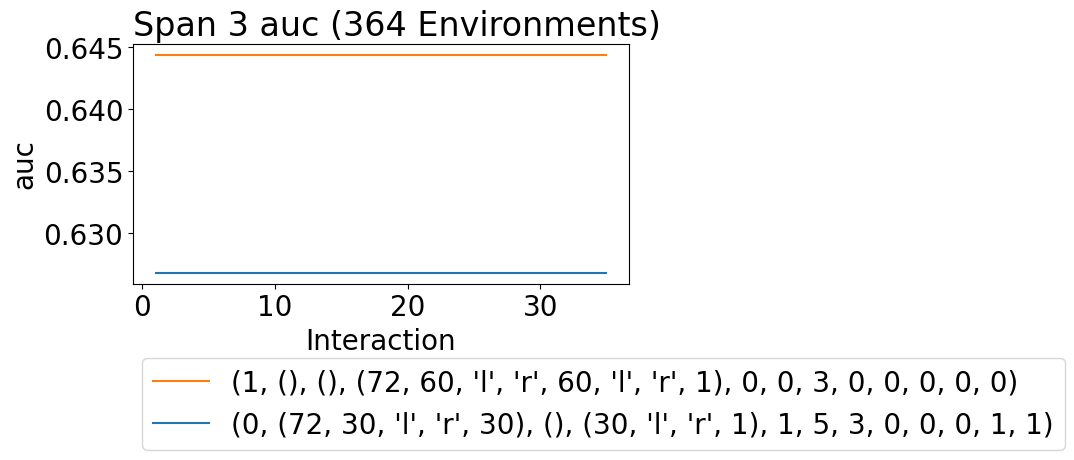

In [84]:
import coba as cb

class FeedForward(torch.nn.Sequential):
    """A Generic implementation of Feedforward Neural Network"""

    class SkipModule(torch.nn.Module):
        def __init__(self, layers):
            super().__init__()
            self.layers = layers
        def forward(self,X):
            return X + self.layers(X)

    def make_layer(self,curr_dim,spec):
        if isinstance(spec,float):
            return torch.nn.Dropout(spec), curr_dim
        if curr_dim is None and isinstance(spec,int):
            return None, spec
        if isinstance(spec,int):
            return torch.nn.Linear(curr_dim,spec),spec
        if spec == 'r':
            return torch.nn.ReLU(),curr_dim
        if spec == 'l':
            return torch.nn.LayerNorm(curr_dim),curr_dim
        if spec == 'b':
            return torch.nn.BatchNorm1d(curr_dim), curr_dim
        if spec == 's':
            return torch.nn.Sigmoid(),curr_dim
        if isinstance(spec,list):                
            return FeedForward.SkipModule(FeedForward([curr_dim] + spec)), curr_dim
        raise Exception("Bad Layer")

    def __init__(self, specs, rng=1):
        """Instantiate a Feedfoward network according to specifications.

        Args:
            specs: A sequence of layer specifications as follows:
                -1 -- replaced with the input feature width
                <int> -- a LinearLayer with output width equal to <int>
                [0,1] -- a Dropout layer with the given probability
                'l' -- a LayerNorm
                'b' -- a BatchNorm1d
                'r' -- a ReLU layer
                's' -- a Sigmoid layer
                [] -- a skip layer with the given specifications
        """

        torch.manual_seed(rng)
        layers,width = [],None
        for spec in specs:
            layer,width = self.make_layer(width,spec)
            if layer: layers.append(layer)
        super().__init__(*(layers or [torch.nn.Identity()]))
        self.params = {"specs": specs, "rng": rng }

class MyEnvironment:
    def __init__(self, train_X, train_Y, test_X, test_Y, g, rng):
        self.params = {'pid': g, 'rng': rng}
        self.train_X = train_X
        self.train_Y = train_Y.float()
        self.test_X = test_X
        self.test_Y = test_Y.float()

    def ssl(self,neg,sr):
        anchor, positive, negative = [], [], []
        by_class  = {y: self.train_X[(self.train_Y==y)].tolist() for y in set(self.train_Y.tolist())}
        rng = cb.CobaRandom(self.params['rng'])

        def choose_unique(items,item):
            while items[i:=rng.randint(0,len(items)-1)]==item:
                pass
            return items[i]

        def choose_n(items,n):
            indexes = set()
            while True:
                indexes.add(rng.randint(0,len(items)-1))
                if len(indexes)==n: break
            return [items[i] for i in indexes]

        for _ in range(sr):
            for x,y in zip(self.train_X.tolist(),self.train_Y.tolist()):
                anchor.append(x)
                positive.append(choose_unique(by_class[y],x))
                negative.append(choose_n(by_class[1-y],neg))

        return torch.tensor(anchor).float(), torch.tensor(positive).float(), torch.tensor(negative).float()

    def train(self):
        return self.train_X, self.train_Y

    def test(self):
        rng_indexes = cb.CobaRandom(self.params['rng']).shuffle(range(len(self.test_X)))
        return self.test_X[rng_indexes,:], self.test_Y[rng_indexes]

class MyEvaluator:
    def __init__(self, specs1, specs2, specs3, ws, ssl, neg, er, lr, nr, tau, sr):
        self.specs1 = specs1
        self.specs2 = specs2
        self.specs3 = specs3
        self.ws = ws
        self.ssl = ssl
        self.neg = neg
        self.er = er
        self.lr = lr
        self.nr = nr
        self.tau = tau
        self.sr = sr
        self.params = {'specs1': specs1, 'specs2': specs2, 'specs3': specs3, 'ws':ws, 'ssl': ssl, 'neg': neg, 'er': er, 'lr': lr, 'nr': nr, 'tau': tau, 'sr': sr }

    def evaluate(self, env, lrn):
        from sklearn.metrics import roc_auc_score
        from sklearn.ensemble import RandomForestClassifier
        torch.set_num_threads(1)

        torch.manual_seed(1)

        f = FeedForward(self.specs1)
        g = FeedForward(self.specs2)
        h = FeedForward(self.specs3) if self.specs3 != ('rf',) else RandomForestClassifier()

        f.train()
        g.train()

        if self.ssl:

            if self.neg == 0: raise Exception("neg can't be 0")
            if self.sr == 0: raise Exception("sr can't be 0")
            if self.tau == 0: raise Exception("Tau can't be 0")

            A, P, N = env.ssl(self.neg,self.sr)

            torch.manual_seed(1)

            torch_dataset = torch.utils.data.TensorDataset(A,P,N)
            torch_loader  = torch.utils.data.DataLoader(torch_dataset,batch_size=32,drop_last=True,shuffle=True)

            opt = COCOB(chain(f.parameters(),g.parameters()))

            for _ in range(self.ssl):
                losses = []
                for _A, _P, _N in torch_loader:
                    #https://arxiv.org/pdf/2002.05709
                    _A = g(f(_A))
                    _P = g(f(_P))
                    _N = g(f(_N))

                    p = torch.einsum("bi,bi->b",_A,_P)
                    n = torch.einsum("bi,bji->bj",_A,_N)

                    p /= (torch.linalg.norm(_A,dim=1)*torch.linalg.norm(_P,dim=1))
                    n /= (torch.linalg.norm(_A,dim=1).unsqueeze(1)*torch.linalg.norm(_N,dim=2))

                    p = torch.exp(p/self.tau)
                    n = torch.exp(n/self.tau)

                    opt.zero_grad()
                    loss = (-torch.log(p/(p+n.sum(dim=1)))).sum()
                    loss.backward()
                    losses.append(loss.item())
                    opt.step()

        if self.ws:
            X, Y = env.train()

            if isinstance(h,RandomForestClassifier):
                with torch.no_grad():
                    h.fit(f(X),Y)
            else:
                h.train()

                opt  = COCOB(h.parameters())
                loss = torch.nn.BCEWithLogitsLoss()

                if self.ws < 1:
                    trn,val = next(StratifiedShuffleSplit(1, train_size=self.ws, random_state=1).split(X,Y))
                else:
                    trn,val = next(StratifiedShuffleSplit(1, train_size=.99, random_state=1).split(X,Y))

                ws_trn_X = X[trn]
                ws_trn_y = Y[trn].unsqueeze(1)
                ws_val_X = X[val]
                ws_val_y = Y[val].unsqueeze(1)

                torch.manual_seed(1)

                torch_dataset = torch.utils.data.TensorDataset(ws_trn_X,ws_trn_y)
                torch_loader  = torch.utils.data.DataLoader(torch_dataset,batch_size=16,drop_last=True,shuffle=True)

                val_losses = []

                with torch.no_grad():
                    val_losses.append(loss(h(f(ws_val_X)),ws_val_y))

                for _ in range(self.ws if self.ws >= 1 else 1000):
                    for _X,_y in torch_loader:
                        opt.zero_grad()
                        loss(h(f(_X)),_y).backward()
                        opt.step()
                    if self.ws < 1:
                        with torch.no_grad():
                            val_losses.append(loss(h(f(ws_val_X)),ws_val_y))
                            if val_losses[-2] < val_losses[-1]: break
        f.eval()
        g.eval()

        def learn(x,y,backs):
            backs +=1
            if self.lr:
                loss(h(f(x)).squeeze(),y).backward()
                if backs % self.lr == 0:
                    opt.step()
                    opt.zero_grad()
            return backs

        torch.manual_seed(1)

        if not isinstance(h,RandomForestClassifier):
            h.eval()
            opt  = COCOB(h.parameters())
            loss = torch.nn.BCEWithLogitsLoss()

        X, Y = env.test()

        if len(set(Y.tolist())) == 1:
            print("Only one class present in y_true. ROC AUC score is not defined in that case.")
            return

        rng = cb.CobaRandom(1)
        while len(set(Y[-10:].tolist())) == 1:
            ind = rng.shuffle(range(len(Y)))
            X = X[ind,:]
            Y = Y[ind]

        backs = 0
        experiences = []
        for i in range(35):
            with torch.no_grad():
                if isinstance(h, RandomForestClassifier):
                    yield {'auc': roc_auc_score(Y[35:],torch.sigmoid(torch.tensor(h.predict(f(X[35:,:])))))}
                else:
                    yield {'auc': roc_auc_score(Y[35:],torch.sigmoid(h(f(X[35:,:]))))}

            x,y = X[i,:], Y[i]
            backs = learn(x,y,backs)
            if self.er: 
                experiences.append([x,y,self.nr])
            if len(experiences) > self.er:
                rng.shuffle(experiences, inplace=True)
                for j in range(self.lr-1,-1,-1):
                    x,y,n = experiences[j]
                    backs = learn(x,y,backs)                    
                    if n == 1: experiences.pop(j)
                    else: experiences[j] = [x,y,n-1]

def make_envs(X, Y, G):
    X, Y, G = torch.tensor(X).float(), torch.tensor(Y).float(), torch.tensor(G)
    all_equal = []
    envs = []
    for g in sorted(set(G.tolist())):
        if (g==G).sum() < 50: continue
        trn_x,trn_y = X[g!=G],Y[g!=G]
        tst_x,tst_y = X[g==G],Y[g==G]

        if len(set(tst_y.tolist())) == 1:
            all_equal.append(g)
        else:
            for rng in range(2):
                envs.append(MyEnvironment(trn_x,trn_y,tst_x,tst_y,g,rng))
            #if len(envs) == 30: break
    if all_equal: print(f"All Equal, no environment added for {all_equal}") 
    return envs

r = lambda w:  ['l', 'r', w, 'l', 'r', w]

lrns = [ FeedForward(specs=[], rng=1) ]
vals = [
    MyEvaluator((len(X2[0]),30,'l','r',30), (), (30,'l','r',1), 3, 1, 5, 0, 0, 0, 1, 1),
    MyEvaluator((), (), (len(X2[0]),60,'l','r',60,'l','r',1), 3, 0, 0, 0, 0, 0, 0, 0),
]

L = ['evaluator_id','specs1','specs2','specs3','ssl','neg','ws','er','lr','nr','tau','sr']
envs = make_envs(X2,Y2,G)
res = cb.Experiment(envs,lrns,vals).run(processes=35,quiet=True)
res.filter_fin(l=L,p=['pid','rng']).plot_learners('index','auc',l=L,p=['pid','rng'],span=3)

All Equal, no environment added for [82, 87, 89, 99, 103, 111, 117, 146, 196, 227, 246, 311, 357, 377, 390, 451, 455]


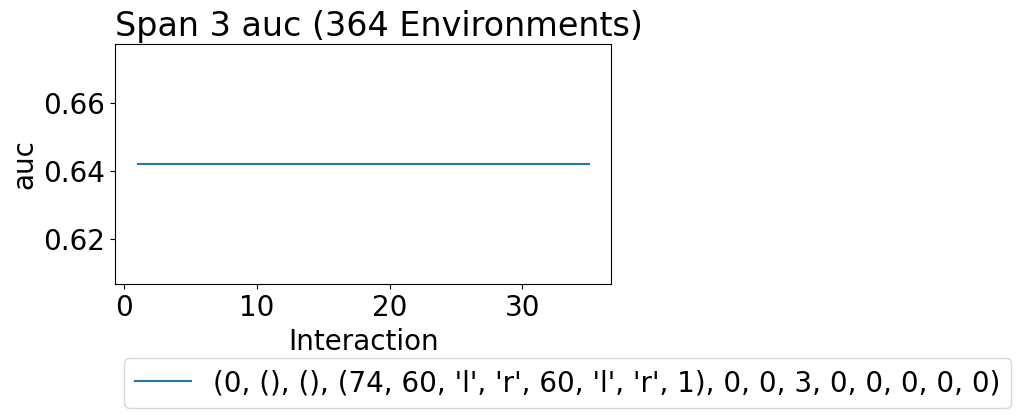

In [85]:
import coba as cb

class FeedForward(torch.nn.Sequential):
    """A Generic implementation of Feedforward Neural Network"""

    class SkipModule(torch.nn.Module):
        def __init__(self, layers):
            super().__init__()
            self.layers = layers
        def forward(self,X):
            return X + self.layers(X)

    def make_layer(self,curr_dim,spec):
        if isinstance(spec,float):
            return torch.nn.Dropout(spec), curr_dim
        if curr_dim is None and isinstance(spec,int):
            return None, spec
        if isinstance(spec,int):
            return torch.nn.Linear(curr_dim,spec),spec
        if spec == 'r':
            return torch.nn.ReLU(),curr_dim
        if spec == 'l':
            return torch.nn.LayerNorm(curr_dim),curr_dim
        if spec == 'b':
            return torch.nn.BatchNorm1d(curr_dim), curr_dim
        if spec == 's':
            return torch.nn.Sigmoid(),curr_dim
        if isinstance(spec,list):                
            return FeedForward.SkipModule(FeedForward([curr_dim] + spec)), curr_dim
        raise Exception("Bad Layer")

    def __init__(self, specs, rng=1):
        """Instantiate a Feedfoward network according to specifications.

        Args:
            specs: A sequence of layer specifications as follows:
                -1 -- replaced with the input feature width
                <int> -- a LinearLayer with output width equal to <int>
                [0,1] -- a Dropout layer with the given probability
                'l' -- a LayerNorm
                'b' -- a BatchNorm1d
                'r' -- a ReLU layer
                's' -- a Sigmoid layer
                [] -- a skip layer with the given specifications
        """

        torch.manual_seed(rng)
        layers,width = [],None
        for spec in specs:
            layer,width = self.make_layer(width,spec)
            if layer: layers.append(layer)
        super().__init__(*(layers or [torch.nn.Identity()]))
        self.params = {"specs": specs, "rng": rng }

class MyEnvironment:
    def __init__(self, train_X, train_Y, test_X, test_Y, g, rng):
        self.params = {'pid': g, 'rng': rng}
        self.train_X = train_X
        self.train_Y = train_Y.float()
        self.test_X = test_X
        self.test_Y = test_Y.float()

    def ssl(self,neg,sr):
        anchor, positive, negative = [], [], []
        by_class  = {y: self.train_X[(self.train_Y==y)].tolist() for y in set(self.train_Y.tolist())}
        rng = cb.CobaRandom(self.params['rng'])

        def choose_unique(items,item):
            while items[i:=rng.randint(0,len(items)-1)]==item:
                pass
            return items[i]

        def choose_n(items,n):
            indexes = set()
            while True:
                indexes.add(rng.randint(0,len(items)-1))
                if len(indexes)==n: break
            return [items[i] for i in indexes]

        for _ in range(sr):
            for x,y in zip(self.train_X.tolist(),self.train_Y.tolist()):
                anchor.append(x)
                positive.append(choose_unique(by_class[y],x))
                negative.append(choose_n(by_class[1-y],neg))

        return torch.tensor(anchor).float(), torch.tensor(positive).float(), torch.tensor(negative).float()

    def train(self):
        return self.train_X, self.train_Y

    def test(self):
        rng_indexes = cb.CobaRandom(self.params['rng']).shuffle(range(len(self.test_X)))
        return self.test_X[rng_indexes,:], self.test_Y[rng_indexes]

class MyEvaluator:
    def __init__(self, specs1, specs2, specs3, ws, ssl, neg, er, lr, nr, tau, sr):
        self.specs1 = specs1
        self.specs2 = specs2
        self.specs3 = specs3
        self.ws = ws
        self.ssl = ssl
        self.neg = neg
        self.er = er
        self.lr = lr
        self.nr = nr
        self.tau = tau
        self.sr = sr
        self.params = {'specs1': specs1, 'specs2': specs2, 'specs3': specs3, 'ws':ws, 'ssl': ssl, 'neg': neg, 'er': er, 'lr': lr, 'nr': nr, 'tau': tau, 'sr': sr }

    def evaluate(self, env, lrn):
        from sklearn.metrics import roc_auc_score
        from sklearn.ensemble import RandomForestClassifier
        torch.set_num_threads(1)

        torch.manual_seed(1)

        f = FeedForward(self.specs1)
        g = FeedForward(self.specs2)
        h = FeedForward(self.specs3) if self.specs3 != ('rf',) else RandomForestClassifier()

        f.train()
        g.train()

        if self.ssl:

            if self.neg == 0: raise Exception("neg can't be 0")
            if self.sr == 0: raise Exception("sr can't be 0")
            if self.tau == 0: raise Exception("Tau can't be 0")

            A, P, N = env.ssl(self.neg,self.sr)

            torch.manual_seed(1)

            torch_dataset = torch.utils.data.TensorDataset(A,P,N)
            torch_loader  = torch.utils.data.DataLoader(torch_dataset,batch_size=32,drop_last=True,shuffle=True)

            opt = COCOB(chain(f.parameters(),g.parameters()))

            for _ in range(self.ssl):
                losses = []
                for _A, _P, _N in torch_loader:
                    #https://arxiv.org/pdf/2002.05709
                    _A = g(f(_A))
                    _P = g(f(_P))
                    _N = g(f(_N))

                    p = torch.einsum("bi,bi->b",_A,_P)
                    n = torch.einsum("bi,bji->bj",_A,_N)

                    p /= (torch.linalg.norm(_A,dim=1)*torch.linalg.norm(_P,dim=1))
                    n /= (torch.linalg.norm(_A,dim=1).unsqueeze(1)*torch.linalg.norm(_N,dim=2))

                    p = torch.exp(p/self.tau)
                    n = torch.exp(n/self.tau)

                    opt.zero_grad()
                    loss = (-torch.log(p/(p+n.sum(dim=1)))).sum()
                    loss.backward()
                    losses.append(loss.item())
                    opt.step()

        if self.ws:
            X, Y = env.train()

            if isinstance(h,RandomForestClassifier):
                with torch.no_grad():
                    h.fit(f(X),Y)
            else:
                h.train()

                opt  = COCOB(h.parameters())
                loss = torch.nn.BCEWithLogitsLoss()

                if self.ws < 1:
                    trn,val = next(StratifiedShuffleSplit(1, train_size=self.ws, random_state=1).split(X,Y))
                else:
                    trn,val = next(StratifiedShuffleSplit(1, train_size=.99, random_state=1).split(X,Y))

                ws_trn_X = X[trn]
                ws_trn_y = Y[trn].unsqueeze(1)
                ws_val_X = X[val]
                ws_val_y = Y[val].unsqueeze(1)

                torch.manual_seed(1)

                torch_dataset = torch.utils.data.TensorDataset(ws_trn_X,ws_trn_y)
                torch_loader  = torch.utils.data.DataLoader(torch_dataset,batch_size=16,drop_last=True,shuffle=True)

                val_losses = []

                with torch.no_grad():
                    val_losses.append(loss(h(f(ws_val_X)),ws_val_y))

                for _ in range(self.ws if self.ws >= 1 else 1000):
                    for _X,_y in torch_loader:
                        opt.zero_grad()
                        loss(h(f(_X)),_y).backward()
                        opt.step()
                    if self.ws < 1:
                        with torch.no_grad():
                            val_losses.append(loss(h(f(ws_val_X)),ws_val_y))
                            if val_losses[-2] < val_losses[-1]: break
        f.eval()
        g.eval()

        def learn(x,y,backs):
            backs +=1
            if self.lr:
                loss(h(f(x)).squeeze(),y).backward()
                if backs % self.lr == 0:
                    opt.step()
                    opt.zero_grad()
            return backs

        torch.manual_seed(1)

        if not isinstance(h,RandomForestClassifier):
            h.eval()
            opt  = COCOB(h.parameters())
            loss = torch.nn.BCEWithLogitsLoss()

        X, Y = env.test()

        if len(set(Y.tolist())) == 1:
            print("Only one class present in y_true. ROC AUC score is not defined in that case.")
            return

        rng = cb.CobaRandom(1)
        while len(set(Y[-10:].tolist())) == 1:
            ind = rng.shuffle(range(len(Y)))
            X = X[ind,:]
            Y = Y[ind]

        backs = 0
        experiences = []
        for i in range(35):
            with torch.no_grad():
                if isinstance(h, RandomForestClassifier):
                    yield {'auc': roc_auc_score(Y[35:],torch.sigmoid(torch.tensor(h.predict(f(X[35:,:])))))}
                else:
                    yield {'auc': roc_auc_score(Y[35:],torch.sigmoid(h(f(X[35:,:]))))}

            x,y = X[i,:], Y[i]
            backs = learn(x,y,backs)
            if self.er: 
                experiences.append([x,y,self.nr])
            if len(experiences) > self.er:
                rng.shuffle(experiences, inplace=True)
                for j in range(self.lr-1,-1,-1):
                    x,y,n = experiences[j]
                    backs = learn(x,y,backs)                    
                    if n == 1: experiences.pop(j)
                    else: experiences[j] = [x,y,n-1]

def make_envs(X, Y, G):
    X, Y, G = torch.tensor(X).float(), torch.tensor(Y).float(), torch.tensor(G)
    all_equal = []
    envs = []
    for g in sorted(set(G.tolist())):
        if (g==G).sum() < 50: continue
        trn_x,trn_y = X[g!=G],Y[g!=G]
        tst_x,tst_y = X[g==G],Y[g==G]

        if len(set(tst_y.tolist())) == 1:
            all_equal.append(g)
        else:
            for rng in range(2):
                envs.append(MyEnvironment(trn_x,trn_y,tst_x,tst_y,g,rng))
            #if len(envs) == 30: break
    if all_equal: print(f"All Equal, no environment added for {all_equal}") 
    return envs

r = lambda w:  ['l', 'r', w, 'l', 'r', w]

lrns = [ FeedForward(specs=[], rng=1) ]
vals = [
    MyEvaluator((), (), (len(X3[0]),60,'l','r',60,'l','r',1), 3, 0, 0, 0, 0, 0, 0, 0),
]

L = ['evaluator_id','specs1','specs2','specs3','ssl','neg','ws','er','lr','nr','tau','sr']
envs = make_envs(X3,Y2,G)
res = cb.Experiment(envs,lrns,vals).run(processes=35,quiet=True)
res.filter_fin(l=L,p=['pid','rng']).plot_learners('index','auc',l=L,p=['pid','rng'],span=3)

All Equal, no environment added for [82, 87, 89, 99, 103, 111, 117, 146, 196, 227, 246, 311, 357, 377, 390, 451, 455]


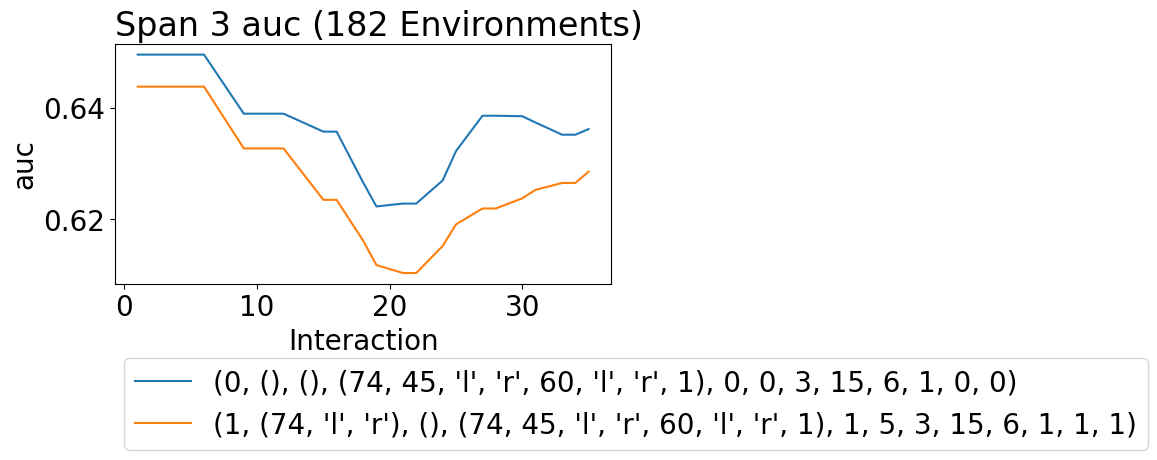

In [ ]:
import coba as cb

class FeedForward(torch.nn.Sequential):
    """A Generic implementation of Feedforward Neural Network"""

    class SkipModule(torch.nn.Module):
        def __init__(self, layers):
            super().__init__()
            self.layers = layers
        def forward(self,X):
            return X + self.layers(X)

    def make_layer(self,curr_dim,spec):
        if isinstance(spec,float):
            return torch.nn.Dropout(spec), curr_dim
        if curr_dim is None and isinstance(spec,int):
            return None, spec
        if isinstance(spec,int):
            return torch.nn.Linear(curr_dim,spec),spec
        if spec == 'r':
            return torch.nn.ReLU(),curr_dim
        if spec == 'l':
            return torch.nn.LayerNorm(curr_dim),curr_dim
        if spec == 'b':
            return torch.nn.BatchNorm1d(curr_dim), curr_dim
        if spec == 's':
            return torch.nn.Sigmoid(),curr_dim
        if isinstance(spec,list):                
            return FeedForward.SkipModule(FeedForward([curr_dim] + spec)), curr_dim
        raise Exception("Bad Layer")

    def __init__(self, specs, rng=1):
        """Instantiate a Feedfoward network according to specifications.

        Args:
            specs: A sequence of layer specifications as follows:
                -1 -- replaced with the input feature width
                <int> -- a LinearLayer with output width equal to <int>
                [0,1] -- a Dropout layer with the given probability
                'l' -- a LayerNorm
                'b' -- a BatchNorm1d
                'r' -- a ReLU layer
                's' -- a Sigmoid layer
                [] -- a skip layer with the given specifications
        """

        torch.manual_seed(rng)
        layers,width = [],None
        for spec in specs:
            layer,width = self.make_layer(width,spec)
            if layer: layers.append(layer)
        super().__init__(*(layers or [torch.nn.Identity()]))
        self.params = {"specs": specs, "rng": rng }

class MyEnvironment:
    def __init__(self, train_X, train_Y, test_X, test_Y, g, rng):
        self.params = {'pid': g, 'rng': rng}
        self.train_X = train_X
        self.train_Y = train_Y.float()
        self.test_X = test_X
        self.test_Y = test_Y.float()

    def ssl(self,neg,sr):
        anchor, positive, negative = [], [], []
        by_class  = {y: self.train_X[(self.train_Y==y)].tolist() for y in set(self.train_Y.tolist())}
        rng = cb.CobaRandom(self.params['rng'])

        def choose_unique(items,item):
            while items[i:=rng.randint(0,len(items)-1)]==item:
                pass
            return items[i]

        def choose_n(items,n):
            indexes = set()
            while True:
                indexes.add(rng.randint(0,len(items)-1))
                if len(indexes)==n: break
            return [items[i] for i in indexes]

        for _ in range(sr):
            for x,y in zip(self.train_X.tolist(),self.train_Y.tolist()):
                anchor.append(x)
                positive.append(choose_unique(by_class[y],x))
                negative.append(choose_n(by_class[1-y],neg))

        return torch.tensor(anchor).float(), torch.tensor(positive).float(), torch.tensor(negative).float()

    def train(self):
        return self.train_X, self.train_Y

    def test(self):
        rng_indexes = cb.CobaRandom(self.params['rng']).shuffle(range(len(self.test_X)))
        return self.test_X[rng_indexes,:], self.test_Y[rng_indexes]

class MyEvaluator:
    def __init__(self, specs1, specs2, specs3, ws, ssl, neg, er, lr, nr, tau, sr):
        self.specs1 = specs1
        self.specs2 = specs2
        self.specs3 = specs3
        self.ws = ws
        self.ssl = ssl
        self.neg = neg
        self.er = er
        self.lr = lr
        self.nr = nr
        self.tau = tau
        self.sr = sr
        self.params = {'specs1': specs1, 'specs2': specs2, 'specs3': specs3, 'ws':ws, 'ssl': ssl, 'neg': neg, 'er': er, 'lr': lr, 'nr': nr, 'tau': tau, 'sr': sr }

    def evaluate(self, env, lrn):
        from sklearn.metrics import roc_auc_score
        from sklearn.ensemble import RandomForestClassifier
        torch.set_num_threads(1)

        torch.manual_seed(1)

        f = FeedForward(self.specs1)
        g = FeedForward(self.specs2)
        h = FeedForward(self.specs3) if self.specs3 != ('rf',) else RandomForestClassifier()

        f.train()
        g.train()

        if self.ssl:

            if self.neg == 0: raise Exception("neg can't be 0")
            if self.sr == 0: raise Exception("sr can't be 0")
            if self.tau == 0: raise Exception("Tau can't be 0")

            A, P, N = env.ssl(self.neg,self.sr)

            torch.manual_seed(1)

            torch_dataset = torch.utils.data.TensorDataset(A,P,N)
            torch_loader  = torch.utils.data.DataLoader(torch_dataset,batch_size=32,drop_last=True,shuffle=True)

            opt = COCOB(chain(f.parameters(),g.parameters()))

            for _ in range(self.ssl):
                losses = []
                for _A, _P, _N in torch_loader:
                    #https://arxiv.org/pdf/2002.05709
                    _A = g(f(_A))
                    _P = g(f(_P))
                    _N = g(f(_N))

                    p = torch.einsum("bi,bi->b",_A,_P)
                    n = torch.einsum("bi,bji->bj",_A,_N)

                    p /= (torch.linalg.norm(_A,dim=1)*torch.linalg.norm(_P,dim=1))
                    n /= (torch.linalg.norm(_A,dim=1).unsqueeze(1)*torch.linalg.norm(_N,dim=2))

                    p = torch.exp(p/self.tau)
                    n = torch.exp(n/self.tau)

                    opt.zero_grad()
                    loss = (-torch.log(p/(p+n.sum(dim=1)))).sum()
                    loss.backward()
                    losses.append(loss.item())
                    opt.step()

        if self.ws:
            X, Y = env.train()

            if isinstance(h,RandomForestClassifier):
                with torch.no_grad():
                    h.fit(f(X),Y)
            else:
                h.train()

                opt  = COCOB(h.parameters())
                loss = torch.nn.BCEWithLogitsLoss()

                if self.ws < 1:
                    trn,val = next(StratifiedShuffleSplit(1, train_size=self.ws, random_state=1).split(X,Y))
                else:
                    trn,val = next(StratifiedShuffleSplit(1, train_size=.99, random_state=1).split(X,Y))

                ws_trn_X = X[trn]
                ws_trn_y = Y[trn].unsqueeze(1)
                ws_val_X = X[val]
                ws_val_y = Y[val].unsqueeze(1)

                torch.manual_seed(1)

                torch_dataset = torch.utils.data.TensorDataset(ws_trn_X,ws_trn_y)
                torch_loader  = torch.utils.data.DataLoader(torch_dataset,batch_size=16,drop_last=True,shuffle=True)

                val_losses = []

                with torch.no_grad():
                    val_losses.append(loss(h(f(ws_val_X)),ws_val_y))

                for _ in range(self.ws if self.ws >= 1 else 1000):
                    for _X,_y in torch_loader:
                        opt.zero_grad()
                        loss(h(f(_X)),_y).backward()
                        opt.step()
                    if self.ws < 1:
                        with torch.no_grad():
                            val_losses.append(loss(h(f(ws_val_X)),ws_val_y))
                            if val_losses[-2] < val_losses[-1]: break
        f.eval()
        g.eval()

        def learn(x,y,backs):
            backs +=1
            if self.lr:
                loss(h(f(x)).squeeze(),y).backward()
                if backs % self.lr == 0:
                    opt.step()
                    opt.zero_grad()
            return backs

        torch.manual_seed(1)

        if not isinstance(h,RandomForestClassifier):
            h.eval()
            opt  = COCOB(h.parameters())
            loss = torch.nn.BCEWithLogitsLoss()

        X, Y = env.test()

        if len(set(Y.tolist())) == 1:
            print("Only one class present in y_true. ROC AUC score is not defined in that case.")
            return

        rng = cb.CobaRandom(1)
        while len(set(Y[-10:].tolist())) == 1:
            ind = rng.shuffle(range(len(Y)))
            X = X[ind,:]
            Y = Y[ind]

        backs = 0
        experiences = []
        for i in range(35):
            with torch.no_grad():
                if isinstance(h, RandomForestClassifier):
                    yield {'auc': roc_auc_score(Y[35:],torch.sigmoid(torch.tensor(h.predict(f(X[35:,:])))))}
                else:
                    yield {'auc': roc_auc_score(Y[35:],torch.sigmoid(h(f(X[35:,:]))))}

            x,y = X[i,:], Y[i]
            backs = learn(x,y,backs)
            if self.er: 
                experiences.append([x,y,self.nr])
            if len(experiences) > self.er:
                rng.shuffle(experiences, inplace=True)
                for j in range(self.lr-1,-1,-1):
                    x,y,n = experiences[j]
                    backs = learn(x,y,backs)                    
                    if n == 1: experiences.pop(j)
                    else: experiences[j] = [x,y,n-1]

def make_envs(X, Y, G):
    X, Y, G = torch.tensor(X).float(), torch.tensor(Y).float(), torch.tensor(G)
    all_equal = []
    envs = []
    for g in sorted(set(G.tolist())):
        if (g==G).sum() < 50: continue
        trn_x,trn_y = X[g!=G],Y[g!=G]
        tst_x,tst_y = X[g==G],Y[g==G]

        if len(set(tst_y.tolist())) == 1:
            all_equal.append(g)
        else:
            for rng in range(1):
                envs.append(MyEnvironment(trn_x,trn_y,tst_x,tst_y,g,rng))
            #if len(envs) == 30: break
    if all_equal: print(f"All Equal, no environment added for {all_equal}") 
    return envs

r = lambda w:  ['l', 'r', w, 'l', 'r', w]

lrns = [ FeedForward(specs=[], rng=1) ]
vals = [
    MyEvaluator((), (), (len(X3[0]),45,'l','r',60,'l','r',1), 3, 0, 0, 15, 6, 1, 0, 0),
    MyEvaluator((len(X3[0]),'l','r'), (), (len(X3[0]),45,'l','r',60,'l','r',1), 3, 1, 5, 15, 6, 1, 1, 1),
]

L = ['evaluator_id','specs1','specs2','specs3','ssl','neg','ws','er','lr','nr','tau','sr']
envs = make_envs(X3,Y2,G)
res = cb.Experiment(envs,lrns,vals).run(processes=35,quiet=True)
res.filter_fin(l=L,p=['pid','rng']).plot_learners('index','auc',l=L,p=['pid','rng'],span=3)

All Equal, no environment added for [82, 87, 89, 99, 103, 111, 117, 146, 196, 227, 246, 311, 357, 377, 390, 451, 455]


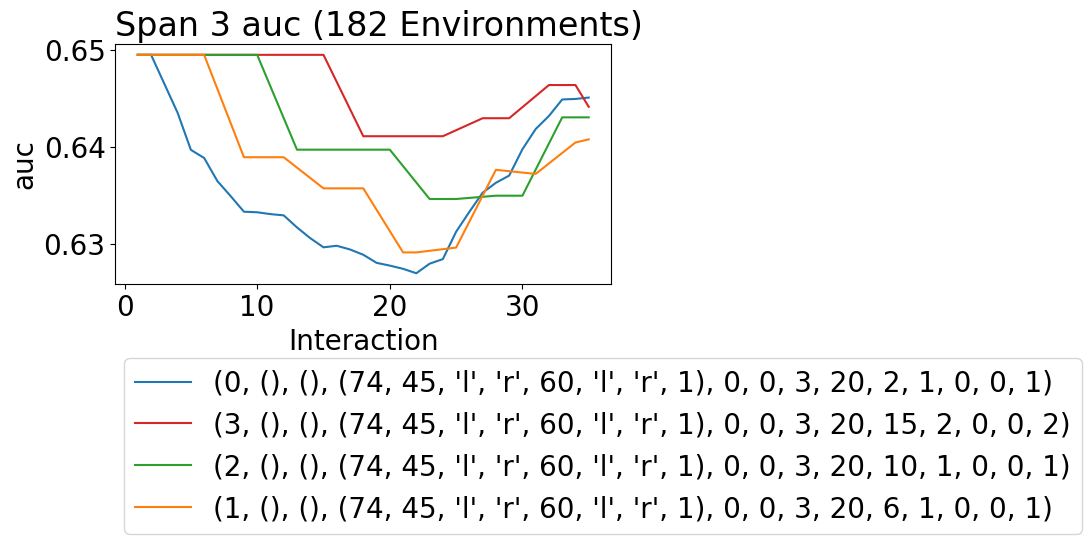

In [ ]:
import coba as cb

class FeedForward(torch.nn.Sequential):
    """A Generic implementation of Feedforward Neural Network"""

    class SkipModule(torch.nn.Module):
        def __init__(self, layers):
            super().__init__()
            self.layers = layers
        def forward(self,X):
            return X + self.layers(X)

    def make_layer(self,curr_dim,spec):
        if isinstance(spec,float):
            return torch.nn.Dropout(spec), curr_dim
        if curr_dim is None and isinstance(spec,int):
            return None, spec
        if isinstance(spec,int):
            return torch.nn.Linear(curr_dim,spec),spec
        if spec == 'r':
            return torch.nn.ReLU(),curr_dim
        if spec == 'l':
            return torch.nn.LayerNorm(curr_dim),curr_dim
        if spec == 'b':
            return torch.nn.BatchNorm1d(curr_dim), curr_dim
        if spec == 's':
            return torch.nn.Sigmoid(),curr_dim
        if isinstance(spec,list):                
            return FeedForward.SkipModule(FeedForward([curr_dim] + spec)), curr_dim
        raise Exception("Bad Layer")

    def __init__(self, specs, rng=1):
        """Instantiate a Feedfoward network according to specifications.

        Args:
            specs: A sequence of layer specifications as follows:
                -1 -- replaced with the input feature width
                <int> -- a LinearLayer with output width equal to <int>
                [0,1] -- a Dropout layer with the given probability
                'l' -- a LayerNorm
                'b' -- a BatchNorm1d
                'r' -- a ReLU layer
                's' -- a Sigmoid layer
                [] -- a skip layer with the given specifications
        """

        torch.manual_seed(rng)
        layers,width = [],None
        for spec in specs:
            layer,width = self.make_layer(width,spec)
            if layer: layers.append(layer)
        super().__init__(*(layers or [torch.nn.Identity()]))
        self.params = {"specs": specs, "rng": rng }

class MyEnvironment:
    def __init__(self, train_X, train_Y, test_X, test_Y, g, rng):
        self.params = {'pid': g, 'rng': rng}
        self.train_X = train_X
        self.train_Y = train_Y.float()
        self.test_X = test_X
        self.test_Y = test_Y.float()

    def ssl(self,neg,sr):
        anchor, positive, negative = [], [], []
        by_class  = {y: self.train_X[(self.train_Y==y)].tolist() for y in set(self.train_Y.tolist())}
        rng = cb.CobaRandom(self.params['rng'])

        def choose_unique(items,item):
            while items[i:=rng.randint(0,len(items)-1)]==item:
                pass
            return items[i]

        def choose_n(items,n):
            indexes = set()
            while True:
                indexes.add(rng.randint(0,len(items)-1))
                if len(indexes)==n: break
            return [items[i] for i in indexes]

        for _ in range(sr):
            for x,y in zip(self.train_X.tolist(),self.train_Y.tolist()):
                anchor.append(x)
                positive.append(choose_unique(by_class[y],x))
                negative.append(choose_n(by_class[1-y],neg))

        return torch.tensor(anchor).float(), torch.tensor(positive).float(), torch.tensor(negative).float()

    def train(self):
        return self.train_X, self.train_Y

    def test(self):
        rng_indexes = cb.CobaRandom(self.params['rng']).shuffle(range(len(self.test_X)))
        return self.test_X[rng_indexes,:], self.test_Y[rng_indexes]

class MyEvaluator:
    def __init__(self, specs1, specs2, specs3, ws, ssl, neg, er, lr, nr, tau, sr, jr):
        self.specs1 = specs1
        self.specs2 = specs2
        self.specs3 = specs3
        self.ws = ws
        self.ssl = ssl
        self.neg = neg
        self.er = er
        self.lr = lr
        self.nr = nr
        self.tau = tau
        self.sr = sr
        self.jr = jr
        self.params = {'specs1': specs1, 'specs2': specs2, 'specs3': specs3, 'ws':ws, 'ssl': ssl, 'neg': neg, 'er': er, 'lr': lr, 'nr': nr, 'tau': tau, 'sr': sr, 'jr': jr }

    def evaluate(self, env, lrn):
        from sklearn.metrics import roc_auc_score
        from sklearn.ensemble import RandomForestClassifier
        torch.set_num_threads(1)

        torch.manual_seed(1)

        f = FeedForward(self.specs1)
        g = FeedForward(self.specs2)
        h = FeedForward(self.specs3) if self.specs3 != ('rf',) else RandomForestClassifier()

        f.train()
        g.train()

        if self.ssl:

            if self.neg == 0: raise Exception("neg can't be 0")
            if self.sr == 0: raise Exception("sr can't be 0")
            if self.tau == 0: raise Exception("Tau can't be 0")

            A, P, N = env.ssl(self.neg,self.sr)

            torch.manual_seed(1)

            torch_dataset = torch.utils.data.TensorDataset(A,P,N)
            torch_loader  = torch.utils.data.DataLoader(torch_dataset,batch_size=32,drop_last=True,shuffle=True)

            opt = COCOB(chain(f.parameters(),g.parameters()))

            for _ in range(self.ssl):
                losses = []
                for _A, _P, _N in torch_loader:
                    #https://arxiv.org/pdf/2002.05709
                    _A = g(f(_A))
                    _P = g(f(_P))
                    _N = g(f(_N))

                    p = torch.einsum("bi,bi->b",_A,_P)
                    n = torch.einsum("bi,bji->bj",_A,_N)

                    p /= (torch.linalg.norm(_A,dim=1)*torch.linalg.norm(_P,dim=1))
                    n /= (torch.linalg.norm(_A,dim=1).unsqueeze(1)*torch.linalg.norm(_N,dim=2))

                    p = torch.exp(p/self.tau)
                    n = torch.exp(n/self.tau)

                    opt.zero_grad()
                    loss = (-torch.log(p/(p+n.sum(dim=1)))).sum()
                    loss.backward()
                    losses.append(loss.item())
                    opt.step()

        if self.ws:
            X, Y = env.train()

            if isinstance(h,RandomForestClassifier):
                with torch.no_grad():
                    h.fit(f(X),Y)
            else:
                h.train()

                opt  = COCOB(h.parameters())
                loss = torch.nn.BCEWithLogitsLoss()

                if self.ws < 1:
                    trn,val = next(StratifiedShuffleSplit(1, train_size=self.ws, random_state=1).split(X,Y))
                else:
                    trn,val = next(StratifiedShuffleSplit(1, train_size=.99, random_state=1).split(X,Y))

                ws_trn_X = X[trn]
                ws_trn_y = Y[trn].unsqueeze(1)
                ws_val_X = X[val]
                ws_val_y = Y[val].unsqueeze(1)

                torch.manual_seed(1)

                torch_dataset = torch.utils.data.TensorDataset(ws_trn_X,ws_trn_y)
                torch_loader  = torch.utils.data.DataLoader(torch_dataset,batch_size=16,drop_last=True,shuffle=True)

                val_losses = []

                with torch.no_grad():
                    val_losses.append(loss(h(f(ws_val_X)),ws_val_y))

                for _ in range(self.ws if self.ws >= 1 else 1000):
                    for _X,_y in torch_loader:
                        opt.zero_grad()
                        loss(h(f(_X)),_y).backward()
                        opt.step()
                    if self.ws < 1:
                        with torch.no_grad():
                            val_losses.append(loss(h(f(ws_val_X)),ws_val_y))
                            if val_losses[-2] < val_losses[-1]: break
        f.eval()
        g.eval()

        def learn(x,y,backs):
            backs +=1
            if self.lr:
                loss(h(f(x)).squeeze(),y).backward()
                if backs % self.lr == 0:
                    opt.step()
                    opt.zero_grad()
            return backs

        torch.manual_seed(1)

        if not isinstance(h,RandomForestClassifier):
            h.eval()
            opt  = COCOB(h.parameters())
            loss = torch.nn.BCEWithLogitsLoss()

        X, Y = env.test()

        if len(set(Y.tolist())) == 1:
            print("Only one class present in y_true. ROC AUC score is not defined in that case.")
            return

        rng = cb.CobaRandom(1)
        while len(set(Y[-10:].tolist())) == 1:
            ind = rng.shuffle(range(len(Y)))
            X = X[ind,:]
            Y = Y[ind]

        backs = 0
        experiences = []
        for i in range(35):
            with torch.no_grad():
                if isinstance(h, RandomForestClassifier):
                    yield {'auc': roc_auc_score(Y[35:],torch.sigmoid(torch.tensor(h.predict(f(X[35:,:])))))}
                else:
                    yield {'auc': roc_auc_score(Y[35:],torch.sigmoid(h(f(X[35:,:]))))}

            x,y = X[i,:], Y[i]
            backs = learn(x,y,backs)
            if self.er: 
                experiences.append([x,y,self.nr])
            if len(experiences) > self.er:
                rng.shuffle(experiences, inplace=True)
                for j in range(self.jr-1,-1,-1):
                    x,y,n = experiences[j]
                    backs = learn(x,y,backs)                    
                    if n == 1: experiences.pop(j)
                    else: experiences[j] = [x,y,n-1]

def make_envs(X, Y, G):
    X, Y, G = torch.tensor(X).float(), torch.tensor(Y).float(), torch.tensor(G)
    all_equal = []
    envs = []
    for g in sorted(set(G.tolist())):
        if (g==G).sum() < 50: continue
        trn_x,trn_y = X[g!=G],Y[g!=G]
        tst_x,tst_y = X[g==G],Y[g==G]

        if len(set(tst_y.tolist())) == 1:
            all_equal.append(g)
        else:
            for rng in range(1):
                envs.append(MyEnvironment(trn_x,trn_y,tst_x,tst_y,g,rng))
            #if len(envs) == 30: break
    if all_equal: print(f"All Equal, no environment added for {all_equal}") 
    return envs

r = lambda w:  ['l', 'r', w, 'l', 'r', w]

lrns = [ FeedForward(specs=[], rng=1) ]
vals = [
    MyEvaluator((), (), (len(X3[0]),45,'l','r',60,'l','r',1), 3, 0, 0, 20, 2 , 1, 0, 0, 1),
    MyEvaluator((), (), (len(X3[0]),45,'l','r',60,'l','r',1), 3, 0, 0, 20, 6 , 1, 0, 0, 1),
    MyEvaluator((), (), (len(X3[0]),45,'l','r',60,'l','r',1), 3, 0, 0, 20, 10, 1, 0, 0, 1),
    MyEvaluator((), (), (len(X3[0]),45,'l','r',60,'l','r',1), 3, 0, 0, 20, 15, 2, 0, 0, 2),
]

L = ['evaluator_id','specs1','specs2','specs3','ssl','neg','ws','er','lr','nr','tau','sr','jr']
envs = make_envs(X3,Y2,G)
res = cb.Experiment(envs,lrns,vals).run(processes=35,quiet=True)
res.filter_fin(l=L,p=['pid','rng']).plot_learners('index','auc',l=L,p=['pid','rng'],span=3)

All Equal, no environment added for [82, 87, 89, 99, 103, 111, 117, 146, 196, 227, 246, 311, 357, 377, 390, 451, 455]


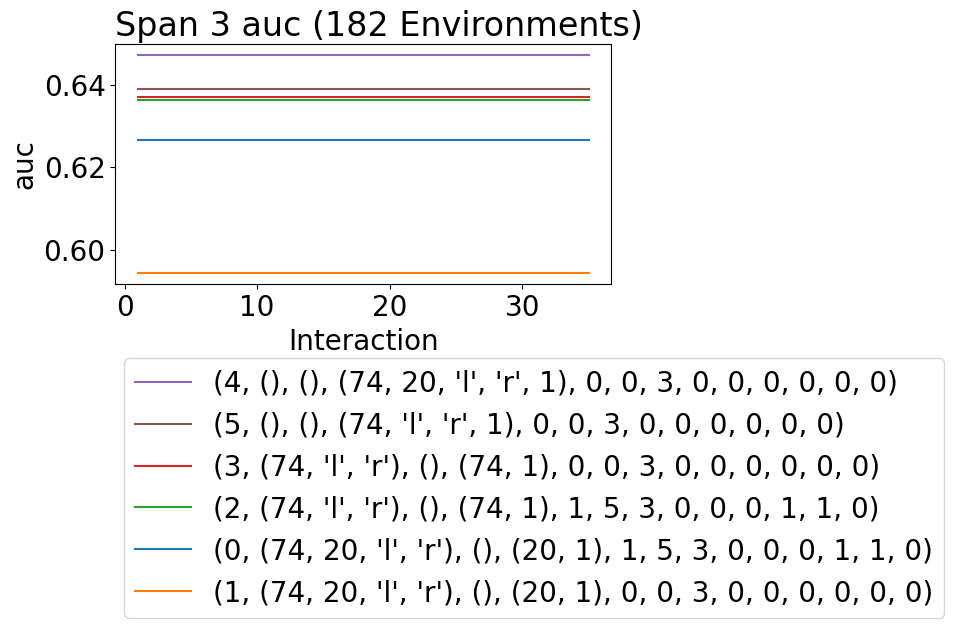

In [ ]:
import coba as cb

class FeedForward(torch.nn.Sequential):
    """A Generic implementation of Feedforward Neural Network"""

    class SkipModule(torch.nn.Module):
        def __init__(self, layers):
            super().__init__()
            self.layers = layers
        def forward(self,X):
            return X + self.layers(X)

    def make_layer(self,curr_dim,spec):
        if isinstance(spec,float):
            return torch.nn.Dropout(spec), curr_dim
        if curr_dim is None and isinstance(spec,int):
            return None, spec
        if isinstance(spec,int):
            return torch.nn.Linear(curr_dim,spec),spec
        if spec == 'r':
            return torch.nn.ReLU(),curr_dim
        if spec == 'l':
            return torch.nn.LayerNorm(curr_dim),curr_dim
        if spec == 'b':
            return torch.nn.BatchNorm1d(curr_dim), curr_dim
        if spec == 's':
            return torch.nn.Sigmoid(),curr_dim
        if isinstance(spec,list):                
            return FeedForward.SkipModule(FeedForward([curr_dim] + spec)), curr_dim
        raise Exception("Bad Layer")

    def __init__(self, specs, rng=1):
        """Instantiate a Feedfoward network according to specifications.

        Args:
            specs: A sequence of layer specifications as follows:
                -1 -- replaced with the input feature width
                <int> -- a LinearLayer with output width equal to <int>
                [0,1] -- a Dropout layer with the given probability
                'l' -- a LayerNorm
                'b' -- a BatchNorm1d
                'r' -- a ReLU layer
                's' -- a Sigmoid layer
                [] -- a skip layer with the given specifications
        """

        torch.manual_seed(rng)
        layers,width = [],None
        for spec in specs:
            layer,width = self.make_layer(width,spec)
            if layer: layers.append(layer)
        super().__init__(*(layers or [torch.nn.Identity()]))
        self.params = {"specs": specs, "rng": rng }

class MyEnvironment:
    def __init__(self, train_X, train_Y, test_X, test_Y, g, rng):
        self.params = {'pid': g, 'rng': rng}
        self.train_X = train_X
        self.train_Y = train_Y.float()
        self.test_X = test_X
        self.test_Y = test_Y.float()

    def ssl(self,neg,sr):
        anchor, positive, negative = [], [], []
        by_class  = {y: self.train_X[(self.train_Y==y)].tolist() for y in set(self.train_Y.tolist())}
        rng = cb.CobaRandom(self.params['rng'])

        def choose_unique(items,item):
            while items[i:=rng.randint(0,len(items)-1)]==item:
                pass
            return items[i]

        def choose_n(items,n):
            indexes = set()
            while True:
                indexes.add(rng.randint(0,len(items)-1))
                if len(indexes)==n: break
            return [items[i] for i in indexes]

        for _ in range(sr):
            for x,y in zip(self.train_X.tolist(),self.train_Y.tolist()):
                anchor.append(x)
                positive.append(choose_unique(by_class[y],x))
                negative.append(choose_n(by_class[1-y],neg))

        return torch.tensor(anchor).float(), torch.tensor(positive).float(), torch.tensor(negative).float()

    def train(self):
        return self.train_X, self.train_Y

    def test(self):
        rng_indexes = cb.CobaRandom(self.params['rng']).shuffle(range(len(self.test_X)))
        return self.test_X[rng_indexes,:], self.test_Y[rng_indexes]

class MyEvaluator:
    def __init__(self, specs1, specs2, specs3, ws, ssl, neg, er, lr, nr, tau, sr, jr):
        self.specs1 = specs1
        self.specs2 = specs2
        self.specs3 = specs3
        self.ws = ws
        self.ssl = ssl
        self.neg = neg
        self.er = er
        self.lr = lr
        self.nr = nr
        self.tau = tau
        self.sr = sr
        self.jr = jr
        self.params = {'specs1': specs1, 'specs2': specs2, 'specs3': specs3, 'ws':ws, 'ssl': ssl, 'neg': neg, 'er': er, 'lr': lr, 'nr': nr, 'tau': tau, 'sr': sr, 'jr': jr }

    def evaluate(self, env, lrn):
        from sklearn.metrics import roc_auc_score
        from sklearn.ensemble import RandomForestClassifier
        torch.set_num_threads(1)

        torch.manual_seed(1)

        f = FeedForward(self.specs1)
        g = FeedForward(self.specs2)
        h = FeedForward(self.specs3) if self.specs3 != ('rf',) else RandomForestClassifier()

        f.train()
        g.train()

        if self.ssl:

            if self.neg == 0: raise Exception("neg can't be 0")
            if self.sr == 0: raise Exception("sr can't be 0")
            if self.tau == 0: raise Exception("Tau can't be 0")

            A, P, N = env.ssl(self.neg,self.sr)

            torch.manual_seed(1)

            torch_dataset = torch.utils.data.TensorDataset(A,P,N)
            torch_loader  = torch.utils.data.DataLoader(torch_dataset,batch_size=32,drop_last=True,shuffle=True)

            opt = COCOB(chain(f.parameters(),g.parameters()))

            for _ in range(self.ssl):
                losses = []
                for _A, _P, _N in torch_loader:
                    #https://arxiv.org/pdf/2002.05709
                    _A = g(f(_A))
                    _P = g(f(_P))
                    _N = g(f(_N))

                    p = torch.einsum("bi,bi->b",_A,_P)
                    n = torch.einsum("bi,bji->bj",_A,_N)

                    p /= (torch.linalg.norm(_A,dim=1)*torch.linalg.norm(_P,dim=1))
                    n /= (torch.linalg.norm(_A,dim=1).unsqueeze(1)*torch.linalg.norm(_N,dim=2))

                    p = torch.exp(p/self.tau)
                    n = torch.exp(n/self.tau)

                    opt.zero_grad()
                    loss = (-torch.log(p/(p+n.sum(dim=1)))).sum()
                    loss.backward()
                    losses.append(loss.item())
                    opt.step()

        if self.ws:
            X, Y = env.train()

            if isinstance(h,RandomForestClassifier):
                with torch.no_grad():
                    h.fit(f(X),Y)
            else:
                h.train()

                opt  = COCOB(h.parameters())
                loss = torch.nn.BCEWithLogitsLoss()

                if self.ws < 1:
                    trn,val = next(StratifiedShuffleSplit(1, train_size=self.ws, random_state=1).split(X,Y))
                else:
                    trn,val = next(StratifiedShuffleSplit(1, train_size=.99, random_state=1).split(X,Y))

                ws_trn_X = X[trn]
                ws_trn_y = Y[trn].unsqueeze(1)
                ws_val_X = X[val]
                ws_val_y = Y[val].unsqueeze(1)

                torch.manual_seed(1)

                torch_dataset = torch.utils.data.TensorDataset(ws_trn_X,ws_trn_y)
                torch_loader  = torch.utils.data.DataLoader(torch_dataset,batch_size=16,drop_last=True,shuffle=True)

                val_losses = []

                with torch.no_grad():
                    val_losses.append(loss(h(f(ws_val_X)),ws_val_y))

                for _ in range(self.ws if self.ws >= 1 else 1000):
                    for _X,_y in torch_loader:
                        opt.zero_grad()
                        loss(h(f(_X)),_y).backward()
                        opt.step()
                    if self.ws < 1:
                        with torch.no_grad():
                            val_losses.append(loss(h(f(ws_val_X)),ws_val_y))
                            if val_losses[-2] < val_losses[-1]: break
        f.eval()
        g.eval()

        def learn(x,y,backs):
            backs +=1
            if self.lr:
                loss(h(f(x)).squeeze(),y).backward()
                if backs % self.lr == 0:
                    opt.step()
                    opt.zero_grad()
            return backs

        torch.manual_seed(1)

        if not isinstance(h,RandomForestClassifier):
            h.eval()
            opt  = COCOB(h.parameters())
            loss = torch.nn.BCEWithLogitsLoss()

        X, Y = env.test()

        if len(set(Y.tolist())) == 1:
            print("Only one class present in y_true. ROC AUC score is not defined in that case.")
            return

        rng = cb.CobaRandom(1)
        while len(set(Y[-10:].tolist())) == 1:
            ind = rng.shuffle(range(len(Y)))
            X = X[ind,:]
            Y = Y[ind]

        backs = 0
        experiences = []
        for i in range(35):
            with torch.no_grad():
                if isinstance(h, RandomForestClassifier):
                    yield {'auc': roc_auc_score(Y[35:],torch.sigmoid(torch.tensor(h.predict(f(X[35:,:])))))}
                else:
                    yield {'auc': roc_auc_score(Y[35:],torch.sigmoid(h(f(X[35:,:]))))}

            x,y = X[i,:], Y[i]
            backs = learn(x,y,backs)
            if self.er: 
                experiences.append([x,y,self.nr])
            if len(experiences) > self.er:
                rng.shuffle(experiences, inplace=True)
                for j in range(self.jr-1,-1,-1):
                    x,y,n = experiences[j]
                    backs = learn(x,y,backs)                    
                    if n == 1: experiences.pop(j)
                    else: experiences[j] = [x,y,n-1]

def make_envs(X, Y, G):
    X, Y, G = torch.tensor(X).float(), torch.tensor(Y).float(), torch.tensor(G)
    all_equal = []
    envs = []
    for g in sorted(set(G.tolist())):
        if (g==G).sum() < 50: continue
        trn_x,trn_y = X[g!=G],Y[g!=G]
        tst_x,tst_y = X[g==G],Y[g==G]

        if len(set(tst_y.tolist())) == 1:
            all_equal.append(g)
        else:
            for rng in range(1):
                envs.append(MyEnvironment(trn_x,trn_y,tst_x,tst_y,g,rng))
            #if len(envs) == 30: break
    if all_equal: print(f"All Equal, no environment added for {all_equal}") 
    return envs

r = lambda w:  ['l', 'r', w, 'l', 'r', w]

lrns = [ FeedForward(specs=[], rng=1) ]
vals = [
    MyEvaluator((len(X3[0]),20,'l','r'), (), (20,1), 3, 1, 5, 0, 0, 0, 1, 1, 0),
    MyEvaluator((len(X3[0]),20,'l','r'), (), (20,1), 3, 0, 0, 0, 0, 0, 0, 0, 0),
    MyEvaluator((len(X3[0]),'l','r'), (), (len(X3[0]),1), 3, 1, 5, 0, 0, 0, 1, 1, 0),
    MyEvaluator((len(X3[0]),'l','r'), (), (len(X3[0]),1), 3, 0, 0, 0, 0, 0, 0, 0, 0),
    MyEvaluator((), (), (len(X3[0]),20,'l','r',1), 3, 0, 0, 0, 0, 0, 0, 0, 0),
    MyEvaluator((), (), (len(X3[0]),'l','r',1), 3, 0, 0, 0, 0, 0, 0, 0, 0),
]

L = ['evaluator_id','specs1','specs2','specs3','ssl','neg','ws','er','lr','nr','tau','sr','jr']
envs = make_envs(X3,Y2,G)
res = cb.Experiment(envs,lrns,vals).run('../logs/out9b.log',processes=35,quiet=True)
res.filter_fin(l=L,p=['pid','rng']).plot_learners('index','auc',l=L,p=['pid','rng'],span=3)

In [ ]:
import coba as cb

class FeedForward(torch.nn.Sequential):
    """A Generic implementation of Feedforward Neural Network"""

    class SkipModule(torch.nn.Module):
        def __init__(self, layers):
            super().__init__()
            self.layers = layers
        def forward(self,X):
            return X + self.layers(X)

    def make_layer(self,curr_dim,spec):
        if isinstance(spec,float):
            return torch.nn.Dropout(spec), curr_dim
        if curr_dim is None and isinstance(spec,int):
            return None, spec
        if isinstance(spec,int):
            return torch.nn.Linear(curr_dim,spec),spec
        if spec == 'r':
            return torch.nn.ReLU(),curr_dim
        if spec == 'l':
            return torch.nn.LayerNorm(curr_dim),curr_dim
        if spec == 'b':
            return torch.nn.BatchNorm1d(curr_dim), curr_dim
        if spec == 's':
            return torch.nn.Sigmoid(),curr_dim
        if isinstance(spec,list):                
            return FeedForward.SkipModule(FeedForward([curr_dim] + spec)), curr_dim
        raise Exception("Bad Layer")

    def __init__(self, specs, rng=1):
        """Instantiate a Feedfoward network according to specifications.

        Args:
            specs: A sequence of layer specifications as follows:
                -1 -- replaced with the input feature width
                <int> -- a LinearLayer with output width equal to <int>
                [0,1] -- a Dropout layer with the given probability
                'l' -- a LayerNorm
                'b' -- a BatchNorm1d
                'r' -- a ReLU layer
                's' -- a Sigmoid layer
                [] -- a skip layer with the given specifications
        """

        torch.manual_seed(rng)
        layers,width = [],None
        for spec in specs:
            layer,width = self.make_layer(width,spec)
            if layer: layers.append(layer)
        super().__init__(*(layers or [torch.nn.Identity()]))
        self.params = {"specs": specs, "rng": rng }

class MyEnvironment:
    def __init__(self, train_X, train_Y, test_X, test_Y, g, rng):
        self.params = {'pid': g, 'rng': rng}
        self.train_X = train_X
        self.train_Y = train_Y.float()
        self.test_X = test_X
        self.test_Y = test_Y.float()

    def ssl(self,neg,sr):

        by_class  = {y: self.train_X[(self.train_Y==y)].tolist() for y in set(self.train_Y.tolist())}
        rng = cb.CobaRandom(self.params['rng'])

        def choose_unique(items,item):
            while items[i:=rng.randint(0,len(items)-1)]==item:
                pass
            return items[i]

        def choose_n(items,n):
            indexes = set()
            while True:
                indexes.add(rng.randint(0,len(items)-1))
                if len(indexes)==n: return [items[i] for i in indexes]

        for _ in range(sr):
            anchor, positive, negative = [], [], []
            for x,y in zip(self.train_X.tolist(),self.train_Y.tolist()):
                anchor.append(x)
                positive.append(choose_unique(by_class[y],x))
                negative.append(choose_n(by_class[1-y],neg))

            yield torch.tensor(anchor).float(), torch.tensor(positive).float(), torch.tensor(negative).float()

    def train(self):
        return self.train_X, self.train_Y

    def test(self):
        rng_indexes = cb.CobaRandom(self.params['rng']).shuffle(range(len(self.test_X)))
        return self.test_X[rng_indexes,:], self.test_Y[rng_indexes]

class MyEvaluator:
    def __init__(self, specs1, specs2, specs3, ws, ssl, neg, er, lr, nr, tau, sr, jr):
        self.specs1 = specs1
        self.specs2 = specs2
        self.specs3 = specs3
        self.ws = ws
        self.ssl = ssl
        self.neg = neg
        self.er = er
        self.lr = lr
        self.nr = nr
        self.tau = tau
        self.sr = sr
        self.jr = jr
        self.params = {'specs1': specs1, 'specs2': specs2, 'specs3': specs3, 'ws':ws, 'ssl': ssl, 'neg': neg, 'er': er, 'lr': lr, 'nr': nr, 'tau': tau, 'sr': sr, 'jr': jr }

    def evaluate(self, env, lrn):
        from sklearn.metrics import roc_auc_score
        from sklearn.ensemble import RandomForestClassifier
        torch.set_num_threads(1)

        torch.manual_seed(1)

        f = FeedForward(self.specs1)
        g = FeedForward(self.specs2)
        h = FeedForward(self.specs3) if self.specs3 != ('rf',) else RandomForestClassifier()

        f.train()
        g.train()

        if self.ssl:

            if self.neg == 0: raise Exception("neg can't be 0")
            if self.sr == 0: raise Exception("sr can't be 0")
            if self.tau == 0: raise Exception("Tau can't be 0")

            torch.manual_seed(1)
            opt = COCOB(chain(f.parameters(),g.parameters()))

            for A, P, N in env.ssl(self.neg,self.sr):

                torch_dataset = torch.utils.data.TensorDataset(A,P,N)
                torch_loader  = torch.utils.data.DataLoader(torch_dataset,batch_size=64,drop_last=True,shuffle=True)

                for _ in range(self.ssl):
                    for _A, _P, _N in torch_loader:
                        #https://arxiv.org/pdf/2002.05709
                        _A = g(f(_A))
                        _P = g(f(_P))
                        _N = g(f(_N))

                        p = torch.einsum("bi,bi->b",_A,_P)
                        n = torch.einsum("bi,bji->bj",_A,_N)

                        p /= (torch.linalg.norm(_A,dim=1)*torch.linalg.norm(_P,dim=1))
                        n /= (torch.linalg.norm(_A,dim=1).unsqueeze(1)*torch.linalg.norm(_N,dim=2))

                        p = torch.exp(p/self.tau)
                        n = torch.exp(n/self.tau)

                        opt.zero_grad()
                        (-torch.log(p/(p+n.sum(dim=1)))).mean().backward()
                        opt.step()

        if self.ws:
            X, Y = env.train()

            if isinstance(h,RandomForestClassifier):
                with torch.no_grad():
                    h.fit(f(X),Y)
            else:
                h.train()

                opt  = COCOB(h.parameters())
                loss = torch.nn.BCEWithLogitsLoss()

                if self.ws < 1:
                    trn,val = next(StratifiedShuffleSplit(1, train_size=self.ws, random_state=1).split(X,Y))
                else:
                    trn,val = next(StratifiedShuffleSplit(1, train_size=.99, random_state=1).split(X,Y))

                ws_trn_X = X[trn]
                ws_trn_y = Y[trn].unsqueeze(1)
                ws_val_X = X[val]
                ws_val_y = Y[val].unsqueeze(1)

                torch.manual_seed(1)

                torch_dataset = torch.utils.data.TensorDataset(ws_trn_X,ws_trn_y)
                torch_loader  = torch.utils.data.DataLoader(torch_dataset,batch_size=16,drop_last=True,shuffle=True)

                val_losses = []

                with torch.no_grad():
                    val_losses.append(loss(h(f(ws_val_X)),ws_val_y))

                for _ in range(self.ws if self.ws >= 1 else 1000):
                    for _X,_y in torch_loader:
                        opt.zero_grad()
                        loss(h(f(_X)),_y).backward()
                        opt.step()
                    if self.ws < 1:
                        with torch.no_grad():
                            val_losses.append(loss(h(f(ws_val_X)),ws_val_y))
                            if val_losses[-2] < val_losses[-1]: break
        f.eval()
        g.eval()

        def learn(x,y,backs):
            backs +=1
            if self.lr:
                loss(h(f(x)).squeeze(),y).backward()
                if backs % self.lr == 0:
                    opt.step()
                    opt.zero_grad()
            return backs

        torch.manual_seed(1)

        if not isinstance(h,RandomForestClassifier):
            h.eval()
            opt  = COCOB(h.parameters())
            loss = torch.nn.BCEWithLogitsLoss()

        X, Y = env.test()

        if len(set(Y.tolist())) == 1:
            print("Only one class present in y_true. ROC AUC score is not defined in that case.")
            return

        rng = cb.CobaRandom(1)
        while len(set(Y[-10:].tolist())) == 1:
            ind = rng.shuffle(range(len(Y)))
            X = X[ind,:]
            Y = Y[ind]

        backs = 0
        experiences = []
        for i in range(35):
            with torch.no_grad():
                if isinstance(h, RandomForestClassifier):
                    yield {'auc': roc_auc_score(Y[35:],torch.sigmoid(torch.tensor(h.predict(f(X[35:,:])))))}
                else:
                    yield {'auc': roc_auc_score(Y[35:],torch.sigmoid(h(f(X[35:,:]))))}

            x,y = X[i,:], Y[i]
            backs = learn(x,y,backs)
            if self.er: 
                experiences.append([x,y,self.nr])
            if len(experiences) > self.er:
                rng.shuffle(experiences, inplace=True)
                for j in range(self.jr-1,-1,-1):
                    x,y,n = experiences[j]
                    backs = learn(x,y,backs)                    
                    if n == 1: experiences.pop(j)
                    else: experiences[j] = [x,y,n-1]

def make_envs(X, Y, G):
    X, Y, G = torch.tensor(X).float(), torch.tensor(Y).float(), torch.tensor(G)
    all_equal = []
    envs = []
    for g in sorted(set(G.tolist())):
        if (g==G).sum() < 50: continue
        trn_x,trn_y = X[g!=G],Y[g!=G]
        tst_x,tst_y = X[g==G],Y[g==G]

        if len(set(tst_y.tolist())) == 1:
            all_equal.append(g)
        else:
            for rng in range(1):
                envs.append(MyEnvironment(trn_x,trn_y,tst_x,tst_y,g,rng))
            #if len(envs) == 30: break
    if all_equal: print(f"All Equal, no environment added for {all_equal}") 
    return envs

r = lambda w:  ['l', 'r', w, 'l', 'r', w]

lrns = [ FeedForward(specs=[], rng=1) ]
vals = [
    MyEvaluator((len(X3[0]),20,'l','r'), (), (20,1), 3, 1, 5, 0, 0, 0, 1, 1 , 0),
    MyEvaluator((len(X3[0]),20,'l','r'), (), (20,1), 3, 1, 5, 0, 0, 0, 1, 2 , 0),
    MyEvaluator((len(X3[0]),20,'l','r'), (), (20,1), 3, 1, 5, 0, 0, 0, 1, 4 , 0),
    MyEvaluator((len(X3[0]),20,'l','r'), (), (20,1), 3, 1, 5, 0, 0, 0, 1, 8 , 0),
    MyEvaluator((len(X3[0]),20,'l','r'), (), (20,1), 3, 1, 5, 0, 0, 0, 1, 16, 0),
    MyEvaluator((len(X3[0]),20,'l','r'), (), (20,1), 3, 1, 5, 0, 0, 0, 1, 32, 0),
    MyEvaluator((len(X3[0]),20,'l','r'), (), (20,1), 3, 1, 5, 0, 0, 0, 1, 64, 0),
    MyEvaluator((len(X3[0]),20,'l','r'), (), (20,1), 3, 1, 5, 0, 0, 0, 1, 128, 0),
    MyEvaluator((len(X3[0]),20,'l','r'), (), (20,1), 3, 1, 15, 0, 0, 0, 1, 128, 0),
    MyEvaluator((), (), (len(X3[0]),20,'l','r',1), 3, 0, 0, 0, 0, 0, 0, 0, 0),
    MyEvaluator((len(X3[0]),20,'l','r'), (), (20,1), 3, 1, 4, 0, 0, 0, 1, 4 , 0),
    MyEvaluator((len(X3[0]),20,'l','r'), (), (20,1), 3, 1, 3, 0, 0, 0, 1, 4 , 0),
    MyEvaluator((len(X3[0]),20,'l','r'), (), (20,1), 3, 1, 2, 0, 0, 0, 1, 4 , 0),
]

L = ['evaluator_id','specs1','specs2','specs3','ssl','neg','ws','er','lr','nr','tau','sr','jr']
envs = make_envs(X3,Y2,G)
cb.Experiment(envs,lrns,vals).run('../logs/out10b.log',processes=20,quiet=True)

In [ ]:
import coba as cb

class FeedForward(torch.nn.Sequential):
    """A Generic implementation of Feedforward Neural Network"""

    class SkipModule(torch.nn.Module):
        def __init__(self, layers):
            super().__init__()
            self.layers = layers
        def forward(self,X):
            return X + self.layers(X)

    def make_layer(self,curr_dim,spec):
        if isinstance(spec,float):
            return torch.nn.Dropout(spec), curr_dim
        if curr_dim is None and isinstance(spec,int):
            return None, spec
        if isinstance(spec,int):
            return torch.nn.Linear(curr_dim,spec),spec
        if spec == 'r':
            return torch.nn.ReLU(),curr_dim
        if spec == 'l':
            return torch.nn.LayerNorm(curr_dim),curr_dim
        if spec == 'b':
            return torch.nn.BatchNorm1d(curr_dim), curr_dim
        if spec == 's':
            return torch.nn.Sigmoid(),curr_dim
        if isinstance(spec,list):                
            return FeedForward.SkipModule(FeedForward([curr_dim] + spec)), curr_dim
        raise Exception("Bad Layer")

    def __init__(self, specs, rng=1):
        """Instantiate a Feedfoward network according to specifications.

        Args:
            specs: A sequence of layer specifications as follows:
                -1 -- replaced with the input feature width
                <int> -- a LinearLayer with output width equal to <int>
                [0,1] -- a Dropout layer with the given probability
                'l' -- a LayerNorm
                'b' -- a BatchNorm1d
                'r' -- a ReLU layer
                's' -- a Sigmoid layer
                [] -- a skip layer with the given specifications
        """

        torch.manual_seed(rng)
        layers,width = [],None
        for spec in specs:
            layer,width = self.make_layer(width,spec)
            if layer: layers.append(layer)
        super().__init__(*(layers or [torch.nn.Identity()]))
        self.params = {"specs": specs, "rng": rng }

class MyEnvironment:
    def __init__(self, train_X, train_Y, test_X, test_Y, g, rng):
        self.params = {'pid': g, 'rng': rng}
        self.train_X = train_X
        self.train_Y = train_Y.float()
        self.test_X = test_X
        self.test_Y = test_Y.float()

    def ssl(self,neg,sr):

        by_class  = {y: self.train_X[(self.train_Y==y)].tolist() for y in set(self.train_Y.tolist())}
        rng = cb.CobaRandom(self.params['rng'])

        def choose_unique(items,item):
            while items[i:=rng.randint(0,len(items)-1)]==item:
                pass
            return items[i]

        def choose_n(items,n):
            indexes = set()
            while True:
                indexes.add(rng.randint(0,len(items)-1))
                if len(indexes)==n: return [items[i] for i in indexes]

        for _ in range(sr):
            anchor, positive, negative = [], [], []
            for x,y in zip(self.train_X.tolist(),self.train_Y.tolist()):
                anchor.append(x)
                positive.append(choose_unique(by_class[y],x))
                negative.append(choose_n(by_class[1-y],neg))

            yield torch.tensor(anchor).float(), torch.tensor(positive).float(), torch.tensor(negative).float()

    def train(self):
        return self.train_X, self.train_Y

    def test(self):
        rng_indexes = cb.CobaRandom(self.params['rng']).shuffle(range(len(self.test_X)))
        return self.test_X[rng_indexes,:], self.test_Y[rng_indexes]

class MyEvaluator:
    def __init__(self, specs1, specs2, specs3, ws, ssl, neg, er, lr, nr, tau, sr, jr):
        self.specs1 = specs1
        self.specs2 = specs2
        self.specs3 = specs3
        self.ws = ws
        self.ssl = ssl
        self.neg = neg
        self.er = er
        self.lr = lr
        self.nr = nr
        self.tau = tau
        self.sr = sr
        self.jr = jr
        self.params = {'specs1': specs1, 'specs2': specs2, 'specs3': specs3, 'ws':ws, 'ssl': ssl, 'neg': neg, 'er': er, 'lr': lr, 'nr': nr, 'tau': tau, 'sr': sr, 'jr': jr }

    def evaluate(self, env, lrn):
        from sklearn.metrics import roc_auc_score
        from sklearn.ensemble import RandomForestClassifier
        torch.set_num_threads(1)

        torch.manual_seed(1)

        f = FeedForward(self.specs1)
        g = FeedForward(self.specs2)
        h = FeedForward(self.specs3) if self.specs3 != ('rf',) else RandomForestClassifier()

        f.train()
        g.train()

        if self.ssl:

            if self.neg == 0: raise Exception("neg can't be 0")
            if self.sr == 0: raise Exception("sr can't be 0")
            if self.tau == 0: raise Exception("Tau can't be 0")

            torch.manual_seed(1)
            opt = COCOB(chain(f.parameters(),g.parameters()))

            for A, P, N in env.ssl(self.neg,self.sr):

                torch_dataset = torch.utils.data.TensorDataset(A,P,N)
                torch_loader  = torch.utils.data.DataLoader(torch_dataset,batch_size=64,drop_last=True,shuffle=True)

                for _ in range(self.ssl):
                    for _A, _P, _N in torch_loader:
                        #https://arxiv.org/pdf/2002.05709
                        _A = g(f(_A))
                        _P = g(f(_P))
                        _N = g(f(_N))

                        p = torch.einsum("bi,bi->b",_A,_P)
                        n = torch.einsum("bi,bji->bj",_A,_N)

                        p /= (torch.linalg.norm(_A,dim=1)*torch.linalg.norm(_P,dim=1))
                        n /= (torch.linalg.norm(_A,dim=1).unsqueeze(1)*torch.linalg.norm(_N,dim=2))

                        p = torch.exp(p/self.tau)
                        n = torch.exp(n/self.tau)

                        opt.zero_grad()
                        (-torch.log(p/(p+n.sum(dim=1)))).mean().backward()
                        opt.step()

        if self.ws:
            X, Y = env.train()

            if isinstance(h,RandomForestClassifier):
                with torch.no_grad():
                    h.fit(f(X),Y)
            else:
                h.train()

                opt  = COCOB(h.parameters())
                loss = torch.nn.BCEWithLogitsLoss()

                if self.ws < 1:
                    trn,val = next(StratifiedShuffleSplit(1, train_size=self.ws, random_state=1).split(X,Y))
                else:
                    trn,val = next(StratifiedShuffleSplit(1, train_size=.99, random_state=1).split(X,Y))

                ws_trn_X = X[trn]
                ws_trn_y = Y[trn].unsqueeze(1)
                ws_val_X = X[val]
                ws_val_y = Y[val].unsqueeze(1)

                torch.manual_seed(1)

                torch_dataset = torch.utils.data.TensorDataset(ws_trn_X,ws_trn_y)
                torch_loader  = torch.utils.data.DataLoader(torch_dataset,batch_size=16,drop_last=True,shuffle=True)

                val_losses = []

                with torch.no_grad():
                    val_losses.append(loss(h(f(ws_val_X)),ws_val_y))

                for _ in range(self.ws if self.ws >= 1 else 1000):
                    for _X,_y in torch_loader:
                        opt.zero_grad()
                        loss(h(f(_X)),_y).backward()
                        opt.step()
                    if self.ws < 1:
                        with torch.no_grad():
                            val_losses.append(loss(h(f(ws_val_X)),ws_val_y))
                            if val_losses[-2] < val_losses[-1]: break
        f.eval()
        g.eval()

        def learn(x,y,backs):
            backs +=1
            if self.lr:
                loss(h(f(x)).squeeze(),y).backward()
                if backs % self.lr == 0:
                    opt.step()
                    opt.zero_grad()
            return backs

        torch.manual_seed(1)

        if not isinstance(h,RandomForestClassifier):
            h.eval()
            opt  = COCOB(h.parameters())
            loss = torch.nn.BCEWithLogitsLoss()

        X, Y = env.test()

        if len(set(Y.tolist())) == 1:
            print("Only one class present in y_true. ROC AUC score is not defined in that case.")
            return

        rng = cb.CobaRandom(1)
        while len(set(Y[-10:].tolist())) == 1:
            ind = rng.shuffle(range(len(Y)))
            X = X[ind,:]
            Y = Y[ind]

        backs = 0
        experiences = []
        for i in range(35):
            with torch.no_grad():
                if isinstance(h, RandomForestClassifier):
                    yield {'auc': roc_auc_score(Y[35:],torch.sigmoid(torch.tensor(h.predict(f(X[35:,:])))))}
                else:
                    yield {'auc': roc_auc_score(Y[35:],torch.sigmoid(h(f(X[35:,:]))))}

            x,y = X[i,:], Y[i]
            backs = learn(x,y,backs)
            if self.er: 
                experiences.append([x,y,self.nr])
            if len(experiences) > self.er:
                rng.shuffle(experiences, inplace=True)
                for j in range(self.jr-1,-1,-1):
                    x,y,n = experiences[j]
                    backs = learn(x,y,backs)                    
                    if n == 1: experiences.pop(j)
                    else: experiences[j] = [x,y,n-1]

def make_envs(X, Y, G):
    X, Y, G = torch.tensor(X).float(), torch.tensor(Y).float(), torch.tensor(G)
    all_equal = []
    envs = []
    for g in sorted(set(G.tolist())):
        if (g==G).sum() < 50: continue
        trn_x,trn_y = X[g!=G],Y[g!=G]
        tst_x,tst_y = X[g==G],Y[g==G]

        if len(set(tst_y.tolist())) == 1:
            all_equal.append(g)
        else:
            for rng in range(1):
                envs.append(MyEnvironment(trn_x,trn_y,tst_x,tst_y,g,rng))
            #if len(envs) == 30: break
    if all_equal: print(f"All Equal, no environment added for {all_equal}") 
    return envs

r = lambda w:  ['l', 'r', w, 'l', 'r', w]

lrns = [ FeedForward(specs=[], rng=1) ]
vals = [
    MyEvaluator((len(X3[0]),20,'l','r',20,'l','r'), (), (20,1), 3, 1, 5, 0, 0, 0, 1, 4, 0),
    MyEvaluator((), (), (len(X3[0]),20,'l','r',1), 3, 0, 0, 0, 0, 0, 0, 0, 0),
    MyEvaluator((), (), (len(X3[0]),20,'l','r',20,'l','r',1), 3, 0, 0, 0, 0, 0, 0, 0, 0),
    MyEvaluator((len(X3[0]),20,'l','r',20,'l','r'), (), (20,1), 3, 1, 5, 0, 0, 0, 1, 32, 0),
]

L = ['evaluator_id','specs1','specs2','specs3','ssl','neg','ws','er','lr','nr','tau','sr','jr']
envs = make_envs(X3,Y2,G)
cb.Experiment(envs,lrns,vals).run('../logs/out11b.log',processes=20,quiet=True)

All Equal, no environment added for [82, 87, 89, 99, 103, 111, 117, 146, 196, 227, 246, 311, 357, 377, 390, 451, 455]
{'Learners': 1, 'Environments': 182, 'Interactions': 25480}


In [ ]:
import coba as cb

class FeedForward(torch.nn.Sequential):
    """A Generic implementation of Feedforward Neural Network"""

    class SkipModule(torch.nn.Module):
        def __init__(self, layers):
            super().__init__()
            self.layers = layers
        def forward(self,X):
            return X + self.layers(X)

    def make_layer(self,curr_dim,spec):
        if isinstance(spec,float):
            return torch.nn.Dropout(spec), curr_dim
        if curr_dim is None and isinstance(spec,int):
            return None, spec
        if isinstance(spec,int):
            return torch.nn.Linear(curr_dim,spec),spec
        if spec == 'r':
            return torch.nn.ReLU(),curr_dim
        if spec == 'l':
            return torch.nn.LayerNorm(curr_dim),curr_dim
        if spec == 'b':
            return torch.nn.BatchNorm1d(curr_dim), curr_dim
        if spec == 's':
            return torch.nn.Sigmoid(),curr_dim
        if isinstance(spec,list):                
            return FeedForward.SkipModule(FeedForward([curr_dim] + spec)), curr_dim
        raise Exception("Bad Layer")

    def __init__(self, specs, rng=1):
        """Instantiate a Feedfoward network according to specifications.

        Args:
            specs: A sequence of layer specifications as follows:
                -1 -- replaced with the input feature width
                <int> -- a LinearLayer with output width equal to <int>
                [0,1] -- a Dropout layer with the given probability
                'l' -- a LayerNorm
                'b' -- a BatchNorm1d
                'r' -- a ReLU layer
                's' -- a Sigmoid layer
                [] -- a skip layer with the given specifications
        """

        torch.manual_seed(rng)
        layers,width = [],None
        for spec in specs:
            layer,width = self.make_layer(width,spec)
            if layer: layers.append(layer)
        super().__init__(*(layers or [torch.nn.Identity()]))
        self.params = {"specs": specs, "rng": rng }

class MyEnvironment:
    def __init__(self, train_X, train_Y, test_X, test_Y, g, rng):
        self.params = {'pid': g, 'rng': rng}
        self.train_X = train_X
        self.train_Y = train_Y.float()
        self.test_X = test_X
        self.test_Y = test_Y.float()

    def ssl(self,neg,sr):

        by_class  = {y: self.train_X[(self.train_Y==y)].tolist() for y in set(self.train_Y.tolist())}
        rng = cb.CobaRandom(self.params['rng'])

        def choose_unique(items,item):
            while items[i:=rng.randint(0,len(items)-1)]==item:
                pass
            return items[i]

        def choose_n(items,n):
            indexes = set()
            while True:
                indexes.add(rng.randint(0,len(items)-1))
                if len(indexes)==n: return [items[i] for i in indexes]

        for _ in range(sr):
            anchor, positive, negative = [], [], []
            for x,y in zip(self.train_X.tolist(),self.train_Y.tolist()):
                anchor.append(x)
                positive.append(choose_unique(by_class[y],x))
                negative.append(choose_n(by_class[1-y],neg))

            yield torch.tensor(anchor).float(), torch.tensor(positive).float(), torch.tensor(negative).float()

    def train(self):
        return self.train_X, self.train_Y

    def test(self):
        rng_indexes = cb.CobaRandom(self.params['rng']).shuffle(range(len(self.test_X)))
        return self.test_X[rng_indexes,:], self.test_Y[rng_indexes]

class MyEvaluator:
    def __init__(self, specs1, specs2, specs3, ws, ssl, neg, er, lr, nr, tau, sr, jr):
        self.specs1 = specs1
        self.specs2 = specs2
        self.specs3 = specs3
        self.ws = ws
        self.ssl = ssl
        self.neg = neg
        self.er = er
        self.lr = lr
        self.nr = nr
        self.tau = tau
        self.sr = sr
        self.jr = jr
        self.params = {'specs1': specs1, 'specs2': specs2, 'specs3': specs3, 'ws':ws, 'ssl': ssl, 'neg': neg, 'er': er, 'lr': lr, 'nr': nr, 'tau': tau, 'sr': sr, 'jr': jr }

    def evaluate(self, env, lrn):
        from sklearn.metrics import roc_auc_score
        from sklearn.ensemble import RandomForestClassifier
        torch.set_num_threads(1)

        torch.manual_seed(1)

        f = FeedForward(self.specs1)
        g = FeedForward(self.specs2)
        h = FeedForward(self.specs3) if self.specs3 != ('rf',) else RandomForestClassifier()

        f.train()
        g.train()

        if self.ssl:

            if self.neg == 0: raise Exception("neg can't be 0")
            if self.sr == 0: raise Exception("sr can't be 0")
            if self.tau == 0: raise Exception("Tau can't be 0")

            torch.manual_seed(1)
            opt = COCOB(chain(f.parameters(),g.parameters()))

            for A, P, N in env.ssl(self.neg,self.sr):

                torch_dataset = torch.utils.data.TensorDataset(A,P,N)
                torch_loader  = torch.utils.data.DataLoader(torch_dataset,batch_size=64,drop_last=True,shuffle=True)

                for _ in range(self.ssl):
                    for _A, _P, _N in torch_loader:
                        #https://arxiv.org/pdf/2002.05709
                        _A = g(f(_A))
                        _P = g(f(_P))
                        _N = g(f(_N))

                        p = torch.einsum("bi,bi->b",_A,_P)
                        n = torch.einsum("bi,bji->bj",_A,_N)

                        p /= (torch.linalg.norm(_A,dim=1)*torch.linalg.norm(_P,dim=1))
                        n /= (torch.linalg.norm(_A,dim=1).unsqueeze(1)*torch.linalg.norm(_N,dim=2))

                        p = torch.exp(p/self.tau)
                        n = torch.exp(n/self.tau)

                        opt.zero_grad()
                        (-torch.log(p/(p+n.sum(dim=1)))).mean().backward()
                        opt.step()

        if self.ws:
            X, Y = env.train()

            if isinstance(h,RandomForestClassifier):
                with torch.no_grad():
                    h.fit(f(X),Y)
            else:
                h.train()

                opt  = COCOB(h.parameters())
                loss = torch.nn.BCEWithLogitsLoss()

                if self.ws < 1:
                    trn,val = next(StratifiedShuffleSplit(1, train_size=self.ws, random_state=1).split(X,Y))
                else:
                    trn,val = next(StratifiedShuffleSplit(1, train_size=.99, random_state=1).split(X,Y))

                ws_trn_X = X[trn]
                ws_trn_y = Y[trn].unsqueeze(1)
                ws_val_X = X[val]
                ws_val_y = Y[val].unsqueeze(1)

                torch.manual_seed(1)

                torch_dataset = torch.utils.data.TensorDataset(ws_trn_X,ws_trn_y)
                torch_loader  = torch.utils.data.DataLoader(torch_dataset,batch_size=16,drop_last=True,shuffle=True)

                val_losses = []

                with torch.no_grad():
                    val_losses.append(loss(h(f(ws_val_X)),ws_val_y))

                for _ in range(self.ws if self.ws >= 1 else 1000):
                    for _X,_y in torch_loader:
                        opt.zero_grad()
                        loss(h(f(_X)),_y).backward()
                        opt.step()
                    if self.ws < 1:
                        with torch.no_grad():
                            val_losses.append(loss(h(f(ws_val_X)),ws_val_y))
                            if val_losses[-2] < val_losses[-1]: break
        f.eval()
        g.eval()

        def learn(x,y,backs):
            backs +=1
            if self.lr:
                loss(h(f(x)).squeeze(),y).backward()
                if backs % self.lr == 0:
                    opt.step()
                    opt.zero_grad()
            return backs

        torch.manual_seed(1)

        if not isinstance(h,RandomForestClassifier):
            h.eval()
            opt  = COCOB(h.parameters())
            loss = torch.nn.BCEWithLogitsLoss()

        X, Y = env.test()

        if len(set(Y.tolist())) == 1:
            print("Only one class present in y_true. ROC AUC score is not defined in that case.")
            return

        rng = cb.CobaRandom(1)
        while len(set(Y[-10:].tolist())) == 1:
            ind = rng.shuffle(range(len(Y)))
            X = X[ind,:]
            Y = Y[ind]

        backs = 0
        experiences = []
        for i in range(35):
            with torch.no_grad():
                if isinstance(h, RandomForestClassifier):
                    yield {'auc': roc_auc_score(Y[35:],torch.sigmoid(torch.tensor(h.predict(f(X[35:,:])))))}
                else:
                    yield {'auc': roc_auc_score(Y[35:],torch.sigmoid(h(f(X[35:,:]))))}

            x,y = X[i,:], Y[i]
            backs = learn(x,y,backs)
            if self.er: 
                experiences.append([x,y,self.nr])
            if len(experiences) > self.er:
                rng.shuffle(experiences, inplace=True)
                for j in range(self.jr-1,-1,-1):
                    x,y,n = experiences[j]
                    backs = learn(x,y,backs)                    
                    if n == 1: experiences.pop(j)
                    else: experiences[j] = [x,y,n-1]

def make_envs(X, Y, G):
    X, Y, G = torch.tensor(X).float(), torch.tensor(Y).float(), torch.tensor(G)
    all_equal = []
    envs = []
    for g in sorted(set(G.tolist())):
        if (g==G).sum() < 50: continue
        trn_x,trn_y = X[g!=G],Y[g!=G]
        tst_x,tst_y = X[g==G],Y[g==G]

        if len(set(tst_y.tolist())) == 1:
            all_equal.append(g)
        else:
            for rng in range(1):
                envs.append(MyEnvironment(trn_x,trn_y,tst_x,tst_y,g,rng))
            #if len(envs) == 30: break
    if all_equal: print(f"All Equal, no environment added for {all_equal}") 
    return envs

r = lambda w:  ['l', 'r', w, 'l', 'r', w]

lrns = [ FeedForward(specs=[], rng=1) ]
vals = [
    MyEvaluator((), (), (len(X4[0]),20,'l','r',1), 3, 0, 0, 0, 0, 0, 0, 0, 0),
    MyEvaluator((), (), (len(X4[0]),20,'l','r',20,'l','r',1), 3, 0, 0, 0, 0, 0, 0, 0, 0),
]

L = ['evaluator_id','specs1','specs2','specs3','ssl','neg','ws','er','lr','nr','tau','sr','jr']
envs = make_envs(X4,Y2,G)
cb.Experiment(envs,lrns,vals).run('../logs/out12b.log',processes=20,quiet=True)

All Equal, no environment added for [82, 87, 89, 99, 103, 111, 117, 146, 196, 227, 246, 311, 357, 377, 390, 451, 455]
{'Learners': 1, 'Environments': 182, 'Interactions': 12740}


In [ ]:
import coba as cb

class FeedForward(torch.nn.Sequential):
    """A Generic implementation of Feedforward Neural Network"""

    class SkipModule(torch.nn.Module):
        def __init__(self, layers):
            super().__init__()
            self.layers = layers
        def forward(self,X):
            return X + self.layers(X)

    def make_layer(self,curr_dim,spec):
        if isinstance(spec,float):
            return torch.nn.Dropout(spec), curr_dim
        if curr_dim is None and isinstance(spec,int):
            return None, spec
        if isinstance(spec,int):
            return torch.nn.Linear(curr_dim,spec),spec
        if spec == 'r':
            return torch.nn.ReLU(),curr_dim
        if spec == 'l':
            return torch.nn.LayerNorm(curr_dim),curr_dim
        if spec == 'b':
            return torch.nn.BatchNorm1d(curr_dim), curr_dim
        if spec == 's':
            return torch.nn.Sigmoid(),curr_dim
        if isinstance(spec,list):                
            return FeedForward.SkipModule(FeedForward([curr_dim] + spec)), curr_dim
        raise Exception("Bad Layer")

    def __init__(self, specs, rng=1):
        """Instantiate a Feedfoward network according to specifications.

        Args:
            specs: A sequence of layer specifications as follows:
                -1 -- replaced with the input feature width
                <int> -- a LinearLayer with output width equal to <int>
                [0,1] -- a Dropout layer with the given probability
                'l' -- a LayerNorm
                'b' -- a BatchNorm1d
                'r' -- a ReLU layer
                's' -- a Sigmoid layer
                [] -- a skip layer with the given specifications
        """

        torch.manual_seed(rng)
        layers,width = [],None
        for spec in specs:
            layer,width = self.make_layer(width,spec)
            if layer: layers.append(layer)
        super().__init__(*(layers or [torch.nn.Identity()]))
        self.params = {"specs": specs, "rng": rng }

class MyEnvironment:
    def __init__(self, train_X, train_Y, test_X, test_Y, g, rng):
        self.params = {'pid': g, 'rng': rng}
        self.train_X = train_X
        self.train_Y = train_Y.float()
        self.test_X = test_X
        self.test_Y = test_Y.float()

    def ssl(self,neg,sr):

        by_class  = {y: self.train_X[(self.train_Y==y)].tolist() for y in set(self.train_Y.tolist())}
        rng = cb.CobaRandom(self.params['rng'])

        def choose_unique(items,item):
            while items[i:=rng.randint(0,len(items)-1)]==item:
                pass
            return items[i]

        def choose_n(items,n):
            indexes = set()
            while True:
                indexes.add(rng.randint(0,len(items)-1))
                if len(indexes)==n: return [items[i] for i in indexes]

        for _ in range(sr):
            anchor, positive, negative = [], [], []
            for x,y in zip(self.train_X.tolist(),self.train_Y.tolist()):
                anchor.append(x)
                positive.append(choose_unique(by_class[y],x))
                negative.append(choose_n(by_class[1-y],neg))

            yield torch.tensor(anchor).float(), torch.tensor(positive).float(), torch.tensor(negative).float()

    def train(self):
        return self.train_X, self.train_Y

    def test(self):
        rng_indexes = cb.CobaRandom(self.params['rng']).shuffle(range(len(self.test_X)))
        return self.test_X[rng_indexes,:], self.test_Y[rng_indexes]

class MyEvaluator:
    def __init__(self, specs1, specs2, specs3, specs4, ws, ssl, neg, er, lr, nr, tau, sr, jr):
        self.specs1 = specs1
        self.specs2 = specs2
        self.specs3 = specs3
        self.specs4 = specs4
        self.ws = ws
        self.ssl = ssl
        self.neg = neg
        self.er = er
        self.lr = lr
        self.nr = nr
        self.tau = tau
        self.sr = sr
        self.jr = jr
        self.params = {'specs1': specs1, 'specs2': specs2, 'specs3': specs3, 'specs4': specs4, 'ws':ws, 'ssl': ssl, 'neg': neg, 'er': er, 'lr': lr, 'nr': nr, 'tau': tau, 'sr': sr, 'jr': jr }

    def evaluate(self, env, lrn):
        from sklearn.metrics import roc_auc_score
        from sklearn.ensemble import RandomForestClassifier
        torch.set_num_threads(1)

        torch.manual_seed(1)

        f = FeedForward(self.specs1)
        g = FeedForward(self.specs2)
        h = FeedForward(self.specs3) if self.specs3 != ('rf',) else RandomForestClassifier()
        q = FeedForward(self.specs4)

        f.train()
        g.train()
        q.train()

        if self.ssl:

            if self.neg == 0: raise Exception("neg can't be 0")
            if self.sr == 0: raise Exception("sr can't be 0")
            if self.tau == 0: raise Exception("Tau can't be 0")

            torch.manual_seed(1)
            opt = COCOB(chain(f.parameters(),g.parameters()))

            for A, P, N in env.ssl(self.neg,self.sr):

                torch_dataset = torch.utils.data.TensorDataset(A,P,N)
                torch_loader  = torch.utils.data.DataLoader(torch_dataset,batch_size=64,drop_last=True,shuffle=True)

                for _ in range(self.ssl):
                    for _A, _P, _N in torch_loader:
                        #https://arxiv.org/pdf/2002.05709
                        _A = g(f(_A))
                        _P = g(f(_P))
                        _N = g(f(_N))

                        p = torch.einsum("bi,bi->b",_A,_P)
                        n = torch.einsum("bi,bji->bj",_A,_N)

                        p /= (torch.linalg.norm(_A,dim=1)*torch.linalg.norm(_P,dim=1))
                        n /= (torch.linalg.norm(_A,dim=1).unsqueeze(1)*torch.linalg.norm(_N,dim=2))

                        p = torch.exp(p/self.tau)
                        n = torch.exp(n/self.tau)

                        opt.zero_grad()
                        (-torch.log(p/(p+n.sum(dim=1)))).mean().backward()
                        opt.step()
        
        hopt = COCOB(h.parameters()) if list(h.parameters()) else None
        qopt = COCOB(q.parameters())

        if self.ws:
            X, Y = env.train()

            if isinstance(h,RandomForestClassifier):
                with torch.no_grad():
                    h.fit(f(X),Y)
            else:
                h.train()

                loss = torch.nn.BCEWithLogitsLoss()

                if self.ws < 1:
                    trn,val = next(StratifiedShuffleSplit(1, train_size=self.ws, random_state=1).split(X,Y))
                else:
                    trn,val = next(StratifiedShuffleSplit(1, train_size=.99, random_state=1).split(X,Y))

                ws_trn_X = X[trn]
                ws_trn_y = Y[trn].unsqueeze(1)
                ws_val_X = X[val]
                ws_val_y = Y[val].unsqueeze(1)

                torch.manual_seed(1)

                torch_dataset = torch.utils.data.TensorDataset(ws_trn_X,ws_trn_y)
                torch_loader  = torch.utils.data.DataLoader(torch_dataset,batch_size=16,drop_last=True,shuffle=True)

                val_losses = []

                with torch.no_grad():
                    val_losses.append(loss(q(h(f(ws_val_X))),ws_val_y))

                for _ in range(self.ws if self.ws >= 1 else 1000):
                    for _X,_y in torch_loader:
                        if hopt: hopt.zero_grad()
                        qopt.zero_grad()
                        loss(q(h(f(_X))),_y).backward()
                        if hopt: hopt.step()
                        qopt.step()
                    if self.ws < 1:
                        with torch.no_grad():
                            val_losses.append(loss(q(h(f(ws_val_X))),ws_val_y))
                            if val_losses[-2] < val_losses[-1]: break
        f.eval()
        g.eval()

        def learn(x,y,backs):
            backs +=1
            if self.lr:
                loss(q(h(f(x))).squeeze(),y).backward()
                if backs % self.lr == 0:
                    qopt.step()
                    qopt.zero_grad()
            return backs

        torch.manual_seed(1)

        q.eval()
        loss = torch.nn.BCEWithLogitsLoss()

        X, Y = env.test()

        if len(set(Y.tolist())) == 1:
            print("Only one class present in y_true. ROC AUC score is not defined in that case.")
            return

        rng = cb.CobaRandom(1)
        while len(set(Y[-10:].tolist())) == 1:
            ind = rng.shuffle(range(len(Y)))
            X = X[ind,:]
            Y = Y[ind]

        backs = 0
        experiences = []
        for i in range(35):
            with torch.no_grad():
                if isinstance(h, RandomForestClassifier):
                    yield {'auc': roc_auc_score(Y[35:],torch.sigmoid(torch.tensor(h.predict(f(X[35:,:])))))}
                else:
                    yield {'auc': roc_auc_score(Y[35:],torch.sigmoid(q(h(f(X[35:,:])))))}

            x,y = X[i,:], Y[i]
            backs = learn(x,y,backs)
            if self.er: 
                experiences.append([x,y,self.nr])
            if len(experiences) > self.er:
                rng.shuffle(experiences, inplace=True)
                for j in range(self.jr-1,-1,-1):
                    x,y,n = experiences[j]
                    backs = learn(x,y,backs)
                    if n == 1: experiences.pop(j)
                    else: experiences[j] = [x,y,n-1]

def make_envs(X, Y, G):
    X, Y, G = torch.tensor(X).float(), torch.tensor(Y).float(), torch.tensor(G)
    all_equal = []
    envs = []
    for g in sorted(set(G.tolist())):
        if (g==G).sum() < 50: continue
        trn_x,trn_y = X[g!=G],Y[g!=G]
        tst_x,tst_y = X[g==G],Y[g==G]

        if len(set(tst_y.tolist())) == 1:
            all_equal.append(g)
        else:
            for rng in range(1):
                envs.append(MyEnvironment(trn_x,trn_y,tst_x,tst_y,g,rng))
            #if len(envs) == 30: break
    if all_equal: print(f"All Equal, no environment added for {all_equal}") 
    return envs

r = lambda w:  ['l', 'r', w, 'l', 'r', w]

lrns = [ FeedForward(specs=[], rng=1) ]
vals = [
    MyEvaluator((), (), (), (len(X4[0]),20,'l','r',1), 3, 0, 0, 0, 0, 0, 0, 0, 0),
    MyEvaluator((), (), (len(X4[0]),20,'l','r'), (20,1), 3, 0, 0, 0, 0, 0, 0, 0, 0),
    MyEvaluator((), (), (), (len(X4[0]),20,'l','r',1), 3, 0, 0, 0, 1, 0, 0, 0, 0),
    MyEvaluator((), (), (len(X4[0]),20,'l','r'), (20,1), 3, 0, 0, 0, 1, 0, 0, 0, 0),
]

L = ['evaluator_id','specs1','specs2','specs3','ssl','neg','ws','er','lr','nr','tau','sr','jr']
envs = make_envs(X4,Y2,G)
cb.Experiment(envs,lrns,vals).run('../logs/out13b.log',processes=20,quiet=True)

All Equal, no environment added for [82, 87, 89, 99, 103, 111, 117, 146, 196, 227, 246, 311, 357, 377, 390, 451, 455]
{'Learners': 1, 'Environments': 182, 'Interactions': 25480}


In [ ]:
import coba as cb

class FeedForward(torch.nn.Sequential):
    """A Generic implementation of Feedforward Neural Network"""

    class SkipModule(torch.nn.Module):
        def __init__(self, layers):
            super().__init__()
            self.layers = layers
        def forward(self,X):
            return X + self.layers(X)

    def make_layer(self,curr_dim,spec):
        if isinstance(spec,float):
            return torch.nn.Dropout(spec), curr_dim
        if curr_dim is None and isinstance(spec,int):
            return None, spec
        if isinstance(spec,int):
            return torch.nn.Linear(curr_dim,spec),spec
        if spec == 'r':
            return torch.nn.ReLU(),curr_dim
        if spec == 'l':
            return torch.nn.LayerNorm(curr_dim),curr_dim
        if spec == 'b':
            return torch.nn.BatchNorm1d(curr_dim), curr_dim
        if spec == 's':
            return torch.nn.Sigmoid(),curr_dim
        if isinstance(spec,list):                
            return FeedForward.SkipModule(FeedForward([curr_dim] + spec)), curr_dim
        raise Exception("Bad Layer")

    def __init__(self, specs, rng=1):
        """Instantiate a Feedfoward network according to specifications.

        Args:
            specs: A sequence of layer specifications as follows:
                -1 -- replaced with the input feature width
                <int> -- a LinearLayer with output width equal to <int>
                [0,1] -- a Dropout layer with the given probability
                'l' -- a LayerNorm
                'b' -- a BatchNorm1d
                'r' -- a ReLU layer
                's' -- a Sigmoid layer
                [] -- a skip layer with the given specifications
        """

        torch.manual_seed(rng)
        layers,width = [],None
        for spec in specs:
            layer,width = self.make_layer(width,spec)
            if layer: layers.append(layer)
        super().__init__(*(layers or [torch.nn.Identity()]))
        self.params = {"specs": specs, "rng": rng }

class MyEnvironment:
    def __init__(self, train_X, train_Y, test_X, test_Y, g, rng):
        self.params = {'pid': g, 'rng': rng}
        self.train_X = train_X
        self.train_Y = train_Y.float()
        self.test_X = test_X
        self.test_Y = test_Y.float()

    def ssl(self,neg,sr):

        by_class  = {y: self.train_X[(self.train_Y==y)].tolist() for y in set(self.train_Y.tolist())}
        rng = cb.CobaRandom(self.params['rng'])

        def choose_unique(items,item):
            while items[i:=rng.randint(0,len(items)-1)]==item:
                pass
            return items[i]

        def choose_n(items,n):
            indexes = set()
            while True:
                indexes.add(rng.randint(0,len(items)-1))
                if len(indexes)==n: return [items[i] for i in indexes]

        for _ in range(sr):
            anchor, positive, negative = [], [], []
            for x,y in zip(self.train_X.tolist(),self.train_Y.tolist()):
                anchor.append(x)
                positive.append(choose_unique(by_class[y],x))
                negative.append(choose_n(by_class[1-y],neg))

            yield torch.tensor(anchor).float(), torch.tensor(positive).float(), torch.tensor(negative).float()

    def train(self):
        return self.train_X, self.train_Y

    def test(self):
        rng_indexes = cb.CobaRandom(self.params['rng']).shuffle(range(len(self.test_X)))
        return self.test_X[rng_indexes,:], self.test_Y[rng_indexes]

class MyEvaluator:
    def __init__(self, specs1, specs2, specs3, specs4, ws, ssl, neg, er, lr, nr, tau, sr, jr):
        self.specs1 = specs1
        self.specs2 = specs2
        self.specs3 = specs3
        self.specs4 = specs4
        self.ws = ws
        self.ssl = ssl
        self.neg = neg
        self.er = er
        self.lr = lr
        self.nr = nr
        self.tau = tau
        self.sr = sr
        self.jr = jr
        self.params = {'specs1': specs1, 'specs2': specs2, 'specs3': specs3, 'specs4': specs4, 'ws':ws, 'ssl': ssl, 'neg': neg, 'er': er, 'lr': lr, 'nr': nr, 'tau': tau, 'sr': sr, 'jr': jr }

    def evaluate(self, env, lrn):
        from sklearn.metrics import roc_auc_score
        from sklearn.ensemble import RandomForestClassifier
        torch.set_num_threads(1)

        torch.manual_seed(1)

        f = FeedForward(self.specs1)
        g = FeedForward(self.specs2)
        h = FeedForward(self.specs3) if self.specs3 != ('rf',) else RandomForestClassifier()
        q = FeedForward(self.specs4)

        f.train()
        g.train()
        q.train()

        if self.ssl:

            if self.neg == 0: raise Exception("neg can't be 0")
            if self.sr == 0: raise Exception("sr can't be 0")
            if self.tau == 0: raise Exception("Tau can't be 0")

            torch.manual_seed(1)
            opt = COCOB(chain(f.parameters(),g.parameters()))

            for A, P, N in env.ssl(self.neg,self.sr):

                torch_dataset = torch.utils.data.TensorDataset(A,P,N)
                torch_loader  = torch.utils.data.DataLoader(torch_dataset,batch_size=64,drop_last=True,shuffle=True)

                for _ in range(self.ssl):
                    for _A, _P, _N in torch_loader:
                        #https://arxiv.org/pdf/2002.05709
                        _A = g(f(_A))
                        _P = g(f(_P))
                        _N = g(f(_N))

                        p = torch.einsum("bi,bi->b",_A,_P)
                        n = torch.einsum("bi,bji->bj",_A,_N)

                        p /= (torch.linalg.norm(_A,dim=1)*torch.linalg.norm(_P,dim=1))
                        n /= (torch.linalg.norm(_A,dim=1).unsqueeze(1)*torch.linalg.norm(_N,dim=2))

                        p = torch.exp(p/self.tau)
                        n = torch.exp(n/self.tau)

                        opt.zero_grad()
                        (-torch.log(p/(p+n.sum(dim=1)))).mean().backward()
                        opt.step()
        
        hopt = COCOB(h.parameters()) if list(h.parameters()) else None
        qopt = COCOB(q.parameters())

        if self.ws:
            X, Y = env.train()

            if isinstance(h,RandomForestClassifier):
                with torch.no_grad():
                    h.fit(f(X),Y)
            else:
                h.train()

                loss = torch.nn.BCEWithLogitsLoss()

                if self.ws < 1:
                    trn,val = next(StratifiedShuffleSplit(1, train_size=self.ws, random_state=1).split(X,Y))
                else:
                    trn,val = next(StratifiedShuffleSplit(1, train_size=.99, random_state=1).split(X,Y))

                ws_trn_X = X[trn]
                ws_trn_y = Y[trn].unsqueeze(1)
                ws_val_X = X[val]
                ws_val_y = Y[val].unsqueeze(1)

                torch.manual_seed(1)

                torch_dataset = torch.utils.data.TensorDataset(ws_trn_X,ws_trn_y)
                torch_loader  = torch.utils.data.DataLoader(torch_dataset,batch_size=16,drop_last=True,shuffle=True)

                val_losses = []

                with torch.no_grad():
                    val_losses.append(loss(q(h(f(ws_val_X))),ws_val_y))

                for _ in range(self.ws if self.ws >= 1 else 1000):
                    for _X,_y in torch_loader:
                        if hopt: hopt.zero_grad()
                        qopt.zero_grad()
                        loss(q(h(f(_X))),_y).backward()
                        if hopt: hopt.step()
                        qopt.step()
                    if self.ws < 1:
                        with torch.no_grad():
                            val_losses.append(loss(q(h(f(ws_val_X))),ws_val_y))
                            if val_losses[-2] < val_losses[-1]: break
        f.eval()
        g.eval()

        def learn(x,y,backs):
            backs +=1
            if self.lr:
                loss(q(h(f(x))).squeeze(),y).backward()
                if backs % self.lr == 0:
                    qopt.step()
                    qopt.zero_grad()
            return backs

        torch.manual_seed(1)

        q.eval()
        loss = torch.nn.BCEWithLogitsLoss()

        X, Y = env.test()

        if len(set(Y.tolist())) == 1:
            print("Only one class present in y_true. ROC AUC score is not defined in that case.")
            return

        rng = cb.CobaRandom(1)
        while len(set(Y[-10:].tolist())) == 1:
            ind = rng.shuffle(range(len(Y)))
            X = X[ind,:]
            Y = Y[ind]

        backs = 0
        experiences = []
        for i in range(35):
            with torch.no_grad():
                if isinstance(h, RandomForestClassifier):
                    yield {'auc': roc_auc_score(Y[35:],torch.sigmoid(torch.tensor(h.predict(f(X[35:,:])))))}
                else:
                    yield {'auc': roc_auc_score(Y[35:],torch.sigmoid(q(h(f(X[35:,:])))))}

            x,y = X[i,:], Y[i]
            backs = learn(x,y,backs)
            if self.er: 
                experiences.append([x,y,self.nr])
            if len(experiences) > self.er:
                rng.shuffle(experiences, inplace=True)
                for j in range(self.jr-1,-1,-1):
                    x,y,n = experiences[j]
                    backs = learn(x,y,backs)
                    if n == 1: experiences.pop(j)
                    else: experiences[j] = [x,y,n-1]

def make_envs(X, Y, G):
    X, Y, G = torch.tensor(X).float(), torch.tensor(Y).float(), torch.tensor(G)
    all_equal = []
    envs = []
    for g in sorted(set(G.tolist())):
        if (g==G).sum() < 50: continue
        trn_x,trn_y = X[g!=G],Y[g!=G]
        tst_x,tst_y = X[g==G],Y[g==G]

        if len(set(tst_y.tolist())) == 1:
            all_equal.append(g)
        else:
            for rng in range(1):
                envs.append(MyEnvironment(trn_x,trn_y,tst_x,tst_y,g,rng))
            #if len(envs) == 30: break
    if all_equal: print(f"All Equal, no environment added for {all_equal}") 
    return envs

r = lambda w:  ['l', 'r', w, 'l', 'r', w]

lrns = [ FeedForward(specs=[], rng=1) ]
vals = [
    MyEvaluator((), (), (), (len(X3[0]),20,'l','r',1), 3, 0, 0, 0, 0, 0, 0, 0, 0),
    MyEvaluator((), (), (len(X3[0]),20,'l','r'), (20,1), 3, 0, 0, 0, 0, 0, 0, 0, 0),
    MyEvaluator((), (), (), (len(X3[0]),20,'l','r',1), 3, 0, 0, 0, 1, 0, 0, 0, 0),
    MyEvaluator((), (), (len(X3[0]),20,'l','r'), (20,1), 3, 0, 0, 0, 1, 0, 0, 0, 0),
    MyEvaluator((), (), (len(X3[0]),20,'l','r'), (20,1), 3, 0, 0, 15, 1, 1, 0, 0, 2),
    MyEvaluator((), (), (len(X3[0]),20,'l','r'), (20,1), 3, 0, 0, 15, 2, 1, 0, 0, 2),
    MyEvaluator((), (), (len(X3[0]),20,'l','r'), (20,1), 3, 0, 0, 15, 2, 1, 0, 0, 1),
    MyEvaluator((len(X3[0]),20,'l','r',20), (), (20,20,'l','r'), (20,1), 3, 1, 5, 15, 1, 1, 1, 64, 1),
]

L = ['evaluator_id','specs1','specs2','specs3','ssl','neg','ws','er','lr','nr','tau','sr','jr']
envs = make_envs(X3,Y2,G)
cb.Experiment(envs,lrns,vals).run('../logs/out14b.log',processes=25,quiet=True)

All Equal, no environment added for [82, 87, 89, 99, 103, 111, 117, 146, 196, 227, 246, 311, 357, 377, 390, 451, 455]
{'Learners': 1, 'Environments': 182, 'Interactions': 50960}


In [ ]:
import coba as cb

class FeedForward(torch.nn.Sequential):
    """A Generic implementation of Feedforward Neural Network"""

    class SkipModule(torch.nn.Module):
        def __init__(self, layers):
            super().__init__()
            self.layers = layers
        def forward(self,X):
            return X + self.layers(X)

    def make_layer(self,curr_dim,spec):
        if isinstance(spec,float):
            return torch.nn.Dropout(spec), curr_dim
        if curr_dim is None and isinstance(spec,int):
            return None, spec
        if isinstance(spec,int):
            return torch.nn.Linear(curr_dim,spec),spec
        if spec == 'r':
            return torch.nn.ReLU(),curr_dim
        if spec == 'l':
            return torch.nn.LayerNorm(curr_dim),curr_dim
        if spec == 'b':
            return torch.nn.BatchNorm1d(curr_dim), curr_dim
        if spec == 's':
            return torch.nn.Sigmoid(),curr_dim
        if isinstance(spec,list):                
            return FeedForward.SkipModule(FeedForward([curr_dim] + spec)), curr_dim
        raise Exception("Bad Layer")

    def __init__(self, specs, rng=1):
        """Instantiate a Feedfoward network according to specifications.

        Args:
            specs: A sequence of layer specifications as follows:
                -1 -- replaced with the input feature width
                <int> -- a LinearLayer with output width equal to <int>
                [0,1] -- a Dropout layer with the given probability
                'l' -- a LayerNorm
                'b' -- a BatchNorm1d
                'r' -- a ReLU layer
                's' -- a Sigmoid layer
                [] -- a skip layer with the given specifications
        """

        torch.manual_seed(rng)
        layers,width = [],None
        for spec in specs:
            layer,width = self.make_layer(width,spec)
            if layer: layers.append(layer)
        super().__init__(*(layers or [torch.nn.Identity()]))
        self.params = {"specs": specs, "rng": rng }

class MyEnvironment:
    def __init__(self, train_X, train_Y, test_X, test_Y, g, rng):
        self.params = {'pid': g, 'rng': rng}
        self.train_X = train_X
        self.train_Y = train_Y.float()
        self.test_X = test_X
        self.test_Y = test_Y.float()

    def ssl(self,neg,sr):

        by_class  = {y: self.train_X[(self.train_Y==y)].tolist() for y in set(self.train_Y.tolist())}
        rng = cb.CobaRandom(self.params['rng'])

        def choose_unique(items,item):
            while items[i:=rng.randint(0,len(items)-1)]==item:
                pass
            return items[i]

        def choose_n(items,n):
            indexes = set()
            while True:
                indexes.add(rng.randint(0,len(items)-1))
                if len(indexes)==n: return [items[i] for i in indexes]

        for _ in range(sr):
            anchor, positive, negative = [], [], []
            for x,y in zip(self.train_X.tolist(),self.train_Y.tolist()):
                anchor.append(x)
                positive.append(choose_unique(by_class[y],x))
                negative.append(choose_n(by_class[1-y],neg))

            yield torch.tensor(anchor).float(), torch.tensor(positive).float(), torch.tensor(negative).float()

    def train(self):
        return self.train_X, self.train_Y

    def test(self):
        rng_indexes = cb.CobaRandom(self.params['rng']).shuffle(range(len(self.test_X)))
        return self.test_X[rng_indexes,:], self.test_Y[rng_indexes]

class MyEvaluator:
    def __init__(self, specs1, specs2, specs3, specs4, ws, ssl, neg, er, lr, nr, tau, sr, jr):
        self.specs1 = specs1
        self.specs2 = specs2
        self.specs3 = specs3
        self.specs4 = specs4
        self.ws = ws
        self.ssl = ssl
        self.neg = neg
        self.er = er
        self.lr = lr
        self.nr = nr
        self.tau = tau
        self.sr = sr
        self.jr = jr
        self.params = {'specs1': specs1, 'specs2': specs2, 'specs3': specs3, 'specs4': specs4, 'ws':ws, 'ssl': ssl, 'neg': neg, 'er': er, 'lr': lr, 'nr': nr, 'tau': tau, 'sr': sr, 'jr': jr }

    def evaluate(self, env, lrn):
        from sklearn.metrics import roc_auc_score
        from sklearn.ensemble import RandomForestClassifier
        torch.set_num_threads(1)

        torch.manual_seed(1)

        f = FeedForward(self.specs1)
        g = FeedForward(self.specs2)
        h = FeedForward(self.specs3) if self.specs3 != ('rf',) else RandomForestClassifier()
        q = FeedForward(self.specs4)

        f.train()
        g.train()
        q.train()

        if self.ssl:

            if self.neg == 0: raise Exception("neg can't be 0")
            if self.sr == 0: raise Exception("sr can't be 0")
            if self.tau == 0: raise Exception("Tau can't be 0")

            torch.manual_seed(1)
            opt = COCOB(chain(f.parameters(),g.parameters()))

            for A, P, N in env.ssl(self.neg,self.sr):

                torch_dataset = torch.utils.data.TensorDataset(A,P,N)
                torch_loader  = torch.utils.data.DataLoader(torch_dataset,batch_size=64,drop_last=True,shuffle=True)

                for _ in range(self.ssl):
                    for _A, _P, _N in torch_loader:
                        #https://arxiv.org/pdf/2002.05709
                        _A = g(f(_A))
                        _P = g(f(_P))
                        _N = g(f(_N))

                        p = torch.einsum("bi,bi->b",_A,_P)
                        n = torch.einsum("bi,bji->bj",_A,_N)

                        p /= (torch.linalg.norm(_A,dim=1)*torch.linalg.norm(_P,dim=1))
                        n /= (torch.linalg.norm(_A,dim=1).unsqueeze(1)*torch.linalg.norm(_N,dim=2))

                        p = torch.exp(p/self.tau)
                        n = torch.exp(n/self.tau)

                        opt.zero_grad()
                        (-torch.log(p/(p+n.sum(dim=1)))).mean().backward()
                        opt.step()
        
        hopt = COCOB(h.parameters()) if list(h.parameters()) else None
        qopt = COCOB(q.parameters())

        if self.ws:
            X, Y = env.train()

            if isinstance(h,RandomForestClassifier):
                with torch.no_grad():
                    h.fit(f(X),Y)
            else:
                h.train()

                loss = torch.nn.BCEWithLogitsLoss()

                if self.ws < 1:
                    trn,val = next(StratifiedShuffleSplit(1, train_size=self.ws, random_state=1).split(X,Y))
                else:
                    trn,val = next(StratifiedShuffleSplit(1, train_size=.99, random_state=1).split(X,Y))

                ws_trn_X = X[trn]
                ws_trn_y = Y[trn].unsqueeze(1)
                ws_val_X = X[val]
                ws_val_y = Y[val].unsqueeze(1)

                torch.manual_seed(1)

                torch_dataset = torch.utils.data.TensorDataset(ws_trn_X,ws_trn_y)
                torch_loader  = torch.utils.data.DataLoader(torch_dataset,batch_size=16,drop_last=True,shuffle=True)

                val_losses = []

                with torch.no_grad():
                    val_losses.append(loss(q(h(f(ws_val_X))),ws_val_y))

                for _ in range(self.ws if self.ws >= 1 else 1000):
                    for _X,_y in torch_loader:
                        if hopt: hopt.zero_grad()
                        qopt.zero_grad()
                        loss(q(h(f(_X))),_y).backward()
                        if hopt: hopt.step()
                        qopt.step()
                    if self.ws < 1:
                        with torch.no_grad():
                            val_losses.append(loss(q(h(f(ws_val_X))),ws_val_y))
                            if val_losses[-2] < val_losses[-1]: break
        f.eval()
        g.eval()

        def learn(x,y,backs):
            backs +=1
            if self.lr:
                loss(q(h(f(x))).squeeze(),y).backward()
                if backs % self.lr == 0:
                    qopt.step()
                    qopt.zero_grad()
            return backs

        torch.manual_seed(1)

        q.eval()
        loss = torch.nn.BCEWithLogitsLoss()

        X, Y = env.test()

        if len(set(Y.tolist())) == 1:
            print("Only one class present in y_true. ROC AUC score is not defined in that case.")
            return

        rng = cb.CobaRandom(1)
        while len(set(Y[-10:].tolist())) == 1:
            ind = rng.shuffle(range(len(Y)))
            X = X[ind,:]
            Y = Y[ind]

        backs = 0
        experiences = []
        for i in range(35):
            with torch.no_grad():
                if isinstance(h, RandomForestClassifier):
                    yield {'auc': roc_auc_score(Y[35:],torch.sigmoid(torch.tensor(h.predict(f(X[35:,:])))))}
                else:
                    yield {'auc': roc_auc_score(Y[35:],torch.sigmoid(q(h(f(X[35:,:])))))}

            x,y = X[i,:], Y[i]
            backs = learn(x,y,backs)
            if self.er: 
                experiences.append([x,y,self.nr])
            if len(experiences) > self.er:
                rng.shuffle(experiences, inplace=True)
                for j in range(self.jr-1,-1,-1):
                    x,y,n = experiences[j]
                    backs = learn(x,y,backs)
                    if n == 1: experiences.pop(j)
                    else: experiences[j] = [x,y,n-1]

def make_envs(X, Y, G):
    X, Y, G = torch.tensor(X).float(), torch.tensor(Y).float(), torch.tensor(G)
    all_equal = []
    envs = []
    for g in sorted(set(G.tolist())):
        if (g==G).sum() < 50: continue
        trn_x,trn_y = X[g!=G],Y[g!=G]
        tst_x,tst_y = X[g==G],Y[g==G]

        if len(set(tst_y.tolist())) == 1:
            all_equal.append(g)
        else:
            for rng in range(1):
                envs.append(MyEnvironment(trn_x,trn_y,tst_x,tst_y,g,rng))
            #if len(envs) == 30: break
    if all_equal: print(f"All Equal, no environment added for {all_equal}") 
    return envs

r = lambda w:  ['l', 'r', w, 'l', 'r', w]

lrns = [ FeedForward(specs=[], rng=1) ]
vals = [
    MyEvaluator((), (), (len(X3[0]),10,'l','r'), (10,1), 3, 0, 0, 15, 2, 1, 0, 0, 1),
    MyEvaluator((), (), (len(X3[0]),20,'l','r'), (20,1), 3, 0, 0, 15, 2, 1, 0, 0, 1),
    MyEvaluator((), (), (len(X3[0]),30,'l','r'), (30,1), 3, 0, 0, 15, 2, 1, 0, 0, 1),
    MyEvaluator((), (), (len(X3[0]),90,'l','r'), (90,1), 3, 0, 0, 15, 2, 1, 0, 0, 1),
    MyEvaluator((), (), (len(X3[0]),20,'l','r'), (20,'l','r',1), 3, 0, 0, 15, 2, 1, 0, 0, 1),
    MyEvaluator((), (), (len(X3[0]),30,'l','r',30,'l','r'), (30,1), 3, 0, 0, 15, 2, 1, 0, 0, 1),
    MyEvaluator((), (), (len(X3[0]),10,'l','r',20,'l','r'), (20,1), 3, 0, 0, 15, 2, 1, 0, 0, 1),
    MyEvaluator((), (), (len(X3[0]),30,'l','r',10), (10,1), 3, 0, 0, 15, 2, 1, 0, 0, 1),
]

L = ['evaluator_id','specs1','specs2','specs3','ssl','neg','ws','er','lr','nr','tau','sr','jr']
envs = make_envs(X3,Y2,G)
cb.Experiment(envs,lrns,vals).run('../logs/out15b.log',processes=35,quiet=True)

All Equal, no environment added for [82, 87, 89, 99, 103, 111, 117, 146, 196, 227, 246, 311, 357, 377, 390, 451, 455]
{'Learners': 1, 'Environments': 182, 'Interactions': 50960}


In [ ]:
import coba as cb

class FeedForward(torch.nn.Sequential):
    """A Generic implementation of Feedforward Neural Network"""

    class SkipModule(torch.nn.Module):
        def __init__(self, layers):
            super().__init__()
            self.layers = layers
        def forward(self,X):
            return X + self.layers(X)

    def make_layer(self,curr_dim,spec):
        if isinstance(spec,float):
            return torch.nn.Dropout(spec), curr_dim
        if curr_dim is None and isinstance(spec,int):
            return None, spec
        if isinstance(spec,int):
            return torch.nn.Linear(curr_dim,spec),spec
        if spec == 'r':
            return torch.nn.ReLU(),curr_dim
        if spec == 'l':
            return torch.nn.LayerNorm(curr_dim),curr_dim
        if spec == 'b':
            return torch.nn.BatchNorm1d(curr_dim), curr_dim
        if spec == 's':
            return torch.nn.Sigmoid(),curr_dim
        if isinstance(spec,list):                
            return FeedForward.SkipModule(FeedForward([curr_dim] + spec)), curr_dim
        raise Exception("Bad Layer")

    def __init__(self, specs, rng=1):
        """Instantiate a Feedfoward network according to specifications.

        Args:
            specs: A sequence of layer specifications as follows:
                -1 -- replaced with the input feature width
                <int> -- a LinearLayer with output width equal to <int>
                [0,1] -- a Dropout layer with the given probability
                'l' -- a LayerNorm
                'b' -- a BatchNorm1d
                'r' -- a ReLU layer
                's' -- a Sigmoid layer
                [] -- a skip layer with the given specifications
        """

        torch.manual_seed(rng)
        layers,width = [],None
        for spec in specs:
            layer,width = self.make_layer(width,spec)
            if layer: layers.append(layer)
        super().__init__(*(layers or [torch.nn.Identity()]))
        self.params = {"specs": specs, "rng": rng }

class MyEnvironment:
    def __init__(self, train_X, train_Y, test_X, test_Y, g, rng):
        self.params = {'pid': g, 'rng': rng}
        self.train_X = train_X
        self.train_Y = train_Y.float()
        self.test_X = test_X
        self.test_Y = test_Y.float()

    def ssl(self,neg,sr):

        by_class  = {y: self.train_X[(self.train_Y==y)].tolist() for y in set(self.train_Y.tolist())}
        rng = cb.CobaRandom(self.params['rng'])

        def choose_unique(items,item):
            while items[i:=rng.randint(0,len(items)-1)]==item:
                pass
            return items[i]

        def choose_n(items,n):
            indexes = set()
            while True:
                indexes.add(rng.randint(0,len(items)-1))
                if len(indexes)==n: return [items[i] for i in indexes]

        for _ in range(sr):
            anchor, positive, negative = [], [], []
            for x,y in zip(self.train_X.tolist(),self.train_Y.tolist()):
                anchor.append(x)
                positive.append(choose_unique(by_class[y],x))
                negative.append(choose_n(by_class[1-y],neg))

            yield torch.tensor(anchor).float(), torch.tensor(positive).float(), torch.tensor(negative).float()

    def train(self):
        return self.train_X, self.train_Y

    def test(self):
        rng_indexes = cb.CobaRandom(self.params['rng']).shuffle(range(len(self.test_X)))
        return self.test_X[rng_indexes,:], self.test_Y[rng_indexes]

class MyEvaluator:
    def __init__(self, specs1, specs2, specs3, specs4, ws, ssl, neg, er, lr, nr, tau, sr, jr):
        self.specs1 = specs1
        self.specs2 = specs2
        self.specs3 = specs3
        self.specs4 = specs4
        self.ws = ws
        self.ssl = ssl
        self.neg = neg
        self.er = er
        self.lr = lr
        self.nr = nr
        self.tau = tau
        self.sr = sr
        self.jr = jr
        self.params = {'specs1': specs1, 'specs2': specs2, 'specs3': specs3, 'specs4': specs4, 'ws':ws, 'ssl': ssl, 'neg': neg, 'er': er, 'lr': lr, 'nr': nr, 'tau': tau, 'sr': sr, 'jr': jr }

    def evaluate(self, env, lrn):
        from sklearn.metrics import roc_auc_score
        from sklearn.ensemble import RandomForestClassifier
        torch.set_num_threads(1)

        torch.manual_seed(1)

        f = FeedForward(self.specs1)
        g = FeedForward(self.specs2)
        h = FeedForward(self.specs3) if self.specs3 != ('rf',) else RandomForestClassifier()
        q = FeedForward(self.specs4)

        f.train()
        g.train()
        q.train()

        if self.ssl:

            if self.neg == 0: raise Exception("neg can't be 0")
            if self.sr == 0: raise Exception("sr can't be 0")
            if self.tau == 0: raise Exception("Tau can't be 0")

            torch.manual_seed(1)
            opt = COCOB(chain(f.parameters(),g.parameters()))

            for A, P, N in env.ssl(self.neg,self.sr):

                torch_dataset = torch.utils.data.TensorDataset(A,P,N)
                torch_loader  = torch.utils.data.DataLoader(torch_dataset,batch_size=64,drop_last=True,shuffle=True)

                for _ in range(self.ssl):
                    for _A, _P, _N in torch_loader:
                        #https://arxiv.org/pdf/2002.05709
                        _A = g(f(_A))
                        _P = g(f(_P))
                        _N = g(f(_N))

                        p = torch.einsum("bi,bi->b",_A,_P)
                        n = torch.einsum("bi,bji->bj",_A,_N)

                        p /= (torch.linalg.norm(_A,dim=1)*torch.linalg.norm(_P,dim=1))
                        n /= (torch.linalg.norm(_A,dim=1).unsqueeze(1)*torch.linalg.norm(_N,dim=2))

                        p = torch.exp(p/self.tau)
                        n = torch.exp(n/self.tau)

                        opt.zero_grad()
                        (-torch.log(p/(p+n.sum(dim=1)))).mean().backward()
                        opt.step()
        
        hopt = COCOB(h.parameters()) if list(h.parameters()) else None
        qopt = COCOB(q.parameters())

        if self.ws:
            X, Y = env.train()

            if isinstance(h,RandomForestClassifier):
                with torch.no_grad():
                    h.fit(f(X),Y)
            else:
                h.train()

                loss = torch.nn.BCEWithLogitsLoss()

                if self.ws < 1:
                    trn,val = next(StratifiedShuffleSplit(1, train_size=self.ws, random_state=1).split(X,Y))
                else:
                    trn,val = next(StratifiedShuffleSplit(1, train_size=.99, random_state=1).split(X,Y))

                ws_trn_X = X[trn]
                ws_trn_y = Y[trn].unsqueeze(1)
                ws_val_X = X[val]
                ws_val_y = Y[val].unsqueeze(1)

                torch.manual_seed(1)

                torch_dataset = torch.utils.data.TensorDataset(ws_trn_X,ws_trn_y)
                torch_loader  = torch.utils.data.DataLoader(torch_dataset,batch_size=16,drop_last=True,shuffle=True)

                val_losses = []

                with torch.no_grad():
                    val_losses.append(loss(q(h(f(ws_val_X))),ws_val_y))

                for _ in range(self.ws if self.ws >= 1 else 1000):
                    for _X,_y in torch_loader:
                        if hopt: hopt.zero_grad()
                        qopt.zero_grad()
                        loss(q(h(f(_X))),_y).backward()
                        if hopt: hopt.step()
                        qopt.step()
                    if self.ws < 1:
                        with torch.no_grad():
                            val_losses.append(loss(q(h(f(ws_val_X))),ws_val_y))
                            if val_losses[-2] < val_losses[-1]: break
        f.eval()
        g.eval()

        def learn(x,y,backs):
            backs +=1
            if self.lr:
                loss(q(h(f(x))).squeeze(),y).backward()
                if backs % self.lr == 0:
                    qopt.step()
                    qopt.zero_grad()
            return backs

        torch.manual_seed(1)

        q.eval()
        loss = torch.nn.BCEWithLogitsLoss()

        X, Y = env.test()

        if len(set(Y.tolist())) == 1:
            print("Only one class present in y_true. ROC AUC score is not defined in that case.")
            return

        rng = cb.CobaRandom(1)
        while len(set(Y[35:].tolist())) == 1:
            ind = rng.shuffle(range(len(Y)))
            X = X[ind,:]
            Y = Y[ind]

        backs = 0
        experiences = []
        for i in range(35):
            with torch.no_grad():
                if isinstance(h, RandomForestClassifier):
                    yield {'auc': roc_auc_score(Y[35:],torch.sigmoid(torch.tensor(h.predict(f(X[35:,:])))))}
                else:
                    yield {'auc': roc_auc_score(Y[35:],torch.sigmoid(q(h(f(X[35:,:])))))}

            x,y = X[i,:], Y[i]
            backs = learn(x,y,backs)
            if self.er: 
                experiences.append([x,y,self.nr])
            if len(experiences) > self.er:
                rng.shuffle(experiences, inplace=True)
                for j in range(self.jr-1,-1,-1):
                    x,y,n = experiences[j]
                    backs = learn(x,y,backs)
                    if n == 1: experiences.pop(j)
                    else: experiences[j] = [x,y,n-1]

def make_envs(X, Y, G):
    X, Y, G = torch.tensor(X).float(), torch.tensor(Y).float(), torch.tensor(G)
    all_equal = []
    envs = []
    for g in sorted(set(G.tolist())):
        if (g==G).sum() < 50: continue
        trn_x,trn_y = X[g!=G],Y[g!=G]
        tst_x,tst_y = X[g==G],Y[g==G]

        if len(set(tst_y.tolist())) == 1:
            all_equal.append(g)
        else:
            for rng in range(4):
                envs.append(MyEnvironment(trn_x,trn_y,tst_x,tst_y,g,rng))
            #if len(envs) == 30: break
    if all_equal: print(f"All Equal, no environment added for {all_equal}") 
    return envs

r = lambda w:  ['l', 'r', w, 'l', 'r', w]

lrns = [ FeedForward(specs=[], rng=1) ]
vals = [
    MyEvaluator((), (), (len(X3[0]),30,'l','r'), (30,1), 3, 0, 0, 15, 2, 1, 0, 0, 1),
]

L = ['evaluator_id','specs1','specs2','specs3','ssl','neg','ws','er','lr','nr','tau','sr','jr']
envs = make_envs(X3,Y2,G)
cb.Experiment(envs,lrns,vals).run('../logs/out15e.log',processes=35,quiet=True)

All Equal, no environment added for [82, 87, 89, 99, 103, 111, 117, 146, 196, 227, 246, 311, 357, 377, 390, 451, 455]
{'Learners': 1, 'Environments': 728, 'Interactions': 25480}


In [ ]:
import coba as cb

class FeedForward(torch.nn.Sequential):
    """A Generic implementation of Feedforward Neural Network"""

    class SkipModule(torch.nn.Module):
        def __init__(self, layers):
            super().__init__()
            self.layers = layers
        def forward(self,X):
            return X + self.layers(X)

    def make_layer(self,curr_dim,spec):
        if isinstance(spec,float):
            return torch.nn.Dropout(spec), curr_dim
        if curr_dim is None and isinstance(spec,int):
            return None, spec
        if isinstance(spec,int):
            return torch.nn.Linear(curr_dim,spec),spec
        if spec == 'r':
            return torch.nn.ReLU(),curr_dim
        if spec == 'l':
            return torch.nn.LayerNorm(curr_dim),curr_dim
        if spec == 'b':
            return torch.nn.BatchNorm1d(curr_dim), curr_dim
        if spec == 's':
            return torch.nn.Sigmoid(),curr_dim
        if isinstance(spec,list):                
            return FeedForward.SkipModule(FeedForward([curr_dim] + spec)), curr_dim
        raise Exception("Bad Layer")

    def __init__(self, specs, rng=1):
        """Instantiate a Feedfoward network according to specifications.

        Args:
            specs: A sequence of layer specifications as follows:
                -1 -- replaced with the input feature width
                <int> -- a LinearLayer with output width equal to <int>
                [0,1] -- a Dropout layer with the given probability
                'l' -- a LayerNorm
                'b' -- a BatchNorm1d
                'r' -- a ReLU layer
                's' -- a Sigmoid layer
                [] -- a skip layer with the given specifications
        """

        torch.manual_seed(rng)
        layers,width = [],None
        for spec in specs:
            layer,width = self.make_layer(width,spec)
            if layer: layers.append(layer)
        super().__init__(*(layers or [torch.nn.Identity()]))
        self.params = {"specs": specs, "rng": rng }

class MyEnvironment:
    def __init__(self, train_X, train_Y, test_X, test_Y, g, rng):
        self.params = {'pid': g, 'rng': rng}
        self.train_X = train_X
        self.train_Y = train_Y.float()
        self.test_X = test_X
        self.test_Y = test_Y.float()

    def ssl(self,neg,sr):

        by_class  = {y: self.train_X[(self.train_Y==y)].tolist() for y in set(self.train_Y.tolist())}
        rng = cb.CobaRandom(self.params['rng'])

        def choose_unique(items,item):
            while items[i:=rng.randint(0,len(items)-1)]==item:
                pass
            return items[i]

        def choose_n(items,n):
            indexes = set()
            while True:
                indexes.add(rng.randint(0,len(items)-1))
                if len(indexes)==n: return [items[i] for i in indexes]

        for _ in range(sr):
            anchor, positive, negative = [], [], []
            for x,y in zip(self.train_X.tolist(),self.train_Y.tolist()):
                anchor.append(x)
                positive.append(choose_unique(by_class[y],x))
                negative.append(choose_n(by_class[1-y],neg))

            yield torch.tensor(anchor).float(), torch.tensor(positive).float(), torch.tensor(negative).float()

    def train(self):
        return self.train_X, self.train_Y

    def test(self):
        rng_indexes = cb.CobaRandom(self.params['rng']).shuffle(range(len(self.test_X)))
        return self.test_X[rng_indexes,:], self.test_Y[rng_indexes]

class MyEvaluator:
    def __init__(self, specs1, specs2, specs3, specs4, ws, ssl, neg, er, lr, nr, tau, sr, jr):
        self.specs1 = specs1
        self.specs2 = specs2
        self.specs3 = specs3
        self.specs4 = specs4
        self.ws = ws
        self.ssl = ssl
        self.neg = neg
        self.er = er
        self.lr = lr
        self.nr = nr
        self.tau = tau
        self.sr = sr
        self.jr = jr
        self.params = {'specs1': specs1, 'specs2': specs2, 'specs3': specs3, 'specs4': specs4, 'ws':ws, 'ssl': ssl, 'neg': neg, 'er': er, 'lr': lr, 'nr': nr, 'tau': tau, 'sr': sr, 'jr': jr }

    def evaluate(self, env, lrn):
        from sklearn.metrics import roc_auc_score
        from sklearn.ensemble import RandomForestClassifier
        torch.set_num_threads(1)

        torch.manual_seed(1)

        f = FeedForward(self.specs1)
        g = FeedForward(self.specs2)
        h = FeedForward(self.specs3) # if self.specs3 != ('rf',) else RandomForestClassifier()
        q = FeedForward(self.specs4)

        f.train()
        g.train()
        h.train()
        q.train()

        fopt = COCOB(f.parameters()) if list(f.parameters()) else None
        gopt = COCOB(g.parameters()) if list(g.parameters()) else None
        hopt = COCOB(h.parameters()) if list(h.parameters()) else None
        qopt = COCOB(q.parameters()) if list(q.parameters()) else None

        if self.ssl:

            if self.neg == 0: raise Exception("neg can't be 0")
            if self.sr == 0: raise Exception("sr can't be 0")
            if self.tau == 0: raise Exception("Tau can't be 0")

            torch.manual_seed(1)
            
            for A, P, N in env.ssl(self.neg,self.sr):

                torch_dataset = torch.utils.data.TensorDataset(A,P,N)
                torch_loader  = torch.utils.data.DataLoader(torch_dataset,batch_size=64,drop_last=True,shuffle=True)

                for _ in range(self.ssl):
                    for _A, _P, _N in torch_loader:
                        #https://arxiv.org/pdf/2002.05709
                        _A = g(f(_A))
                        _P = g(f(_P))
                        _N = g(f(_N))

                        p = torch.einsum("bi,bi->b",_A,_P)
                        n = torch.einsum("bi,bji->bj",_A,_N)

                        p /= (torch.linalg.norm(_A,dim=1)*torch.linalg.norm(_P,dim=1))
                        n /= (torch.linalg.norm(_A,dim=1).unsqueeze(1)*torch.linalg.norm(_N,dim=2))

                        p = torch.exp(p/self.tau)
                        n = torch.exp(n/self.tau)

                        if fopt: fopt.zero_grad()
                        if gopt: gopt.zero_grad()
                        (-torch.log(p/(p+n.sum(dim=1)))).mean().backward()
                        if fopt: fopt.step()
                        if gopt: gopt.step()

        if self.ws:

            if fopt: fopt.zero_grad()
            if hopt: hopt.zero_grad()
            if qopt: qopt.zero_grad()

            X, Y = env.train()

            loss = torch.nn.BCEWithLogitsLoss()

            if self.ws < 1:
                trn,val = next(StratifiedShuffleSplit(1, train_size=self.ws, random_state=1).split(X,Y))
            else:
                trn,val = next(StratifiedShuffleSplit(1, train_size=.99, random_state=1).split(X,Y))

            ws_trn_X = X[trn]
            ws_trn_y = Y[trn].unsqueeze(1)
            ws_val_X = X[val]
            ws_val_y = Y[val].unsqueeze(1)

            torch.manual_seed(1)

            torch_dataset = torch.utils.data.TensorDataset(ws_trn_X,ws_trn_y)
            torch_loader  = torch.utils.data.DataLoader(torch_dataset,batch_size=16,drop_last=True,shuffle=True)

            val_losses = []

            if self.ws < 1:
                with torch.no_grad():
                    val_losses.append(loss(q(h(f(ws_val_X))),ws_val_y))

            for _ in range(self.ws if self.ws >= 1 else 1000):
                for _X,_y in torch_loader:

                    if fopt: fopt.zero_grad()
                    if hopt: hopt.zero_grad()
                    if qopt: qopt.zero_grad()
                    loss(q(h(f(_X))),_y).backward()
                    if qopt: qopt.step()
                    if hopt: hopt.step()
                    if fopt: fopt.step()

                if self.ws < 1:
                    with torch.no_grad():
                        val_losses.append(loss(q(h(f(ws_val_X))),ws_val_y))

                if self.ws < 1 and val_losses[-2] < val_losses[-1]:
                    break

        f.eval()
        g.eval()
        h.eval()
        q.eval()

        def learn(x,y,backs):
            backs += 1
            if self.lr:
                loss(q(h(f(x))).squeeze(),y).backward()
                if backs % self.lr == 0 and qopt:
                    qopt.step()
                    qopt.zero_grad()
            return backs

        torch.manual_seed(1)

        q.eval()
        loss = torch.nn.BCEWithLogitsLoss()

        X, Y = env.test()

        rng = cb.CobaRandom(1)
        while len(set(Y[35:].tolist())) == 1:
            ind = rng.shuffle(range(len(Y)))
            X = X[ind,:]
            Y = Y[ind]

        if fopt: fopt.zero_grad()
        if hopt: hopt.zero_grad()
        if qopt: qopt.zero_grad()

        backs = 0
        experiences = []
        for i in range(35):

            with torch.no_grad():
                yield {'auc': roc_auc_score(Y[35:],torch.sigmoid(q(h(f(X[35:,:])))))}

            x,y = X[i,:], Y[i]
            backs = learn(x,y,backs)

            if self.er:
                experiences.append([x,y,self.nr])

            if len(experiences) > self.er:

                rng.shuffle(experiences, inplace=True)
                for j in range(self.jr-1,-1,-1):
                    x,y,n = experiences[j]
                    backs = learn(x,y,backs)
                    if n == 1: experiences.pop(j)
                    else: experiences[j] = [x,y,n-1]

def make_envs(X, Y, G):
    X, Y, G = torch.tensor(X).float(), torch.tensor(Y).float(), torch.tensor(G)
    all_equal = []
    envs = []
    for g in sorted(set(G.tolist())):
        if (g==G).sum() < 50: continue
        trn_x,trn_y = X[g!=G],Y[g!=G]
        tst_x,tst_y = X[g==G],Y[g==G]

        if len(set(tst_y.tolist())) == 1:
            all_equal.append(g)
        else:
            for rng in range(1):
                envs.append(MyEnvironment(trn_x,trn_y,tst_x,tst_y,g,rng))
            #if len(envs) == 30: break
    if all_equal: print(f"All Equal, no environment added for {all_equal}") 
    return envs

r = lambda w:  ['l', 'r', w, 'l', 'r', w]

lrns = [ FeedForward(specs=[], rng=1) ]
vals = [
    #MyEvaluator((), (), (len(X3[0]),10,'l','r'), (10,1), 3, 0, 0, 15, 2, 1, 0, 0, 1),
    #MyEvaluator((), (), (len(X3[0]),20,'l','r'), (20,1), 3, 0, 0, 15, 2, 1, 0, 0, 1),
    MyEvaluator((), (), (len(X3[0]),30,'l','r'), (30,1), 3, 0, 0, 15, 2, 1, 0, 0, 1),
    MyEvaluator((len(X3[0]),30,'l','r'), (), (30,30,'l','r'), (30,1), 3, 1, 5, 15, 2, 1, 1, 1, 1),
    MyEvaluator((len(X3[0]),30,'l','r'), (), (30,30,'l','r'), (30,1), 3, 1, 5, 15, 2, 1, 1, 2, 1),
    #MyEvaluator((), (), (len(X3[0]),30,'l','r'), (30,1), 3, 0, 0, 15, 2, 1, 0, 0, 1),
    #MyEvaluator((), (), (len(X3[0]),30,'l','r'), (30,1), 3, 0, 0, 15, 2, 1, 0, 0, 1),
    #MyEvaluator((), (), (len(X3[0]),30,'l','r'), (30,1), 3, 0, 0, 15, 2, 1, 0, 0, 1),
]

L = ['evaluator_id','specs1','specs2','specs3','ssl','neg','ws','er','lr','nr','tau','sr','jr']
envs = make_envs(X3,Y2,G)
cb.Experiment(envs,lrns,vals).run('../logs/out16g.log',processes=35,quiet=True)

All Equal, no environment added for [82, 87, 89, 99, 103, 111, 117, 146, 196, 227, 246, 311, 357, 377, 390, 451, 455]
{'Learners': 1, 'Environments': 182, 'Interactions': 19110}


In [ ]:
import coba as cb

class FeedForward(torch.nn.Sequential):
    """A Generic implementation of Feedforward Neural Network"""

    class SkipModule(torch.nn.Module):
        def __init__(self, layers):
            super().__init__()
            self.layers = layers
        def forward(self,X):
            return X + self.layers(X)

    def make_layer(self,curr_dim,spec):
        if isinstance(spec,float):
            return torch.nn.Dropout(spec), curr_dim
        if curr_dim is None and isinstance(spec,int):
            return None, spec
        if isinstance(spec,int):
            return torch.nn.Linear(curr_dim,spec),spec
        if spec == 'r':
            return torch.nn.ReLU(),curr_dim
        if spec == 'l':
            return torch.nn.LayerNorm(curr_dim),curr_dim
        if spec == 'b':
            return torch.nn.BatchNorm1d(curr_dim), curr_dim
        if spec == 's':
            return torch.nn.Sigmoid(),curr_dim
        if isinstance(spec,list):                
            return FeedForward.SkipModule(FeedForward([curr_dim] + spec)), curr_dim
        raise Exception("Bad Layer")

    def __init__(self, specs, rng=1):
        """Instantiate a Feedfoward network according to specifications.

        Args:
            specs: A sequence of layer specifications as follows:
                -1 -- replaced with the input feature width
                <int> -- a LinearLayer with output width equal to <int>
                [0,1] -- a Dropout layer with the given probability
                'l' -- a LayerNorm
                'b' -- a BatchNorm1d
                'r' -- a ReLU layer
                's' -- a Sigmoid layer
                [] -- a skip layer with the given specifications
        """

        torch.manual_seed(rng)
        layers,width = [],None
        for spec in specs:
            layer,width = self.make_layer(width,spec)
            if layer: layers.append(layer)
        super().__init__(*(layers or [torch.nn.Identity()]))
        self.params = {"specs": specs, "rng": rng }

class MyEnvironment:
    def __init__(self, train_X, train_Y, test_X, test_Y, g, rng):
        self.params = {'pid': g, 'rng': rng}
        self.train_X = train_X
        self.train_Y = train_Y.float()
        self.test_X = test_X
        self.test_Y = test_Y.float()

    def ssl(self,neg,sr):

        by_class  = {y: self.train_X[(self.train_Y==y)].tolist() for y in set(self.train_Y.tolist())}
        rng = cb.CobaRandom(self.params['rng'])

        def choose_unique(items,item):
            while items[i:=rng.randint(0,len(items)-1)]==item:
                pass
            return items[i]

        def choose_n(items,n):
            indexes = set()
            while True:
                indexes.add(rng.randint(0,len(items)-1))
                if len(indexes)==n: return [items[i] for i in indexes]

        for _ in range(sr):
            anchor, positive, negative = [], [], []
            for x,y in zip(self.train_X.tolist(),self.train_Y.tolist()):
                anchor.append(x)
                positive.append(choose_unique(by_class[y],x))
                negative.append(choose_n(by_class[1-y],neg))

            yield torch.tensor(anchor).float(), torch.tensor(positive).float(), torch.tensor(negative).float()

    def train(self):
        return self.train_X, self.train_Y

    def test(self):
        rng_indexes = cb.CobaRandom(self.params['rng']).shuffle(range(len(self.test_X)))
        return self.test_X[rng_indexes,:], self.test_Y[rng_indexes]

class MyEvaluator:
    def __init__(self, specs1, specs2, specs3, specs4, ws, ssl, neg, er, lr, nr, tau, sr, jr, re):
        self.specs1 = specs1
        self.specs2 = specs2
        self.specs3 = specs3
        self.specs4 = specs4
        self.ws = ws
        self.ssl = ssl
        self.neg = neg
        self.er = er
        self.lr = lr
        self.nr = nr
        self.tau = tau
        self.sr = sr
        self.jr = jr
        self.re = re
        self.params = {'specs1': specs1, 'specs2': specs2, 'specs3': specs3, 'specs4': specs4, 'ws':ws, 'ssl': ssl, 'neg': neg, 'er': er, 'lr': lr, 'nr': nr, 'tau': tau, 'sr': sr, 'jr': jr, 're':re }

    def evaluate(self, env, lrn):
        from sklearn.metrics import roc_auc_score
        from sklearn.ensemble import RandomForestClassifier
        torch.set_num_threads(1)

        torch.manual_seed(1)

        f = FeedForward(self.specs1)
        g = FeedForward(self.specs2)
        h = FeedForward(self.specs3) # if self.specs3 != ('rf',) else RandomForestClassifier()
        q = FeedForward(self.specs4)

        f.train()
        g.train()
        h.train()
        q.train()

        fopt = COCOB(f.parameters()) if list(f.parameters()) else None
        gopt = COCOB(g.parameters()) if list(g.parameters()) else None
        hopt = COCOB(h.parameters()) if list(h.parameters()) else None
        qopt = COCOB(q.parameters()) if list(q.parameters()) else None

        if self.ssl:

            if self.neg == 0: raise Exception("neg can't be 0")
            if self.sr == 0: raise Exception("sr can't be 0")
            if self.tau == 0: raise Exception("Tau can't be 0")

            torch.manual_seed(1)
            
            for A, P, N in env.ssl(self.neg,self.sr):

                torch_dataset = torch.utils.data.TensorDataset(A,P,N)
                torch_loader  = torch.utils.data.DataLoader(torch_dataset,batch_size=64,drop_last=True,shuffle=True)

                for _ in range(self.ssl):
                    for _A, _P, _N in torch_loader:
                        #https://arxiv.org/pdf/2002.05709
                        _A = g(f(_A))
                        _P = g(f(_P))
                        _N = g(f(_N))

                        p = torch.einsum("bi,bi->b",_A,_P)
                        n = torch.einsum("bi,bji->bj",_A,_N)

                        p /= (torch.linalg.norm(_A,dim=1)*torch.linalg.norm(_P,dim=1))
                        n /= (torch.linalg.norm(_A,dim=1).unsqueeze(1)*torch.linalg.norm(_N,dim=2))

                        p = torch.exp(p/self.tau)
                        n = torch.exp(n/self.tau)

                        if fopt: fopt.zero_grad()
                        if gopt: gopt.zero_grad()
                        (-torch.log(p/(p+n.sum(dim=1)))).mean().backward()
                        if fopt: fopt.step()
                        if gopt: gopt.step()

        if self.ws:

            if fopt: fopt.zero_grad()
            if hopt: hopt.zero_grad()
            if qopt: qopt.zero_grad()

            X, Y = env.train()

            loss = torch.nn.BCEWithLogitsLoss()

            if self.ws < 1:
                trn,val = next(StratifiedShuffleSplit(1, train_size=self.ws, random_state=1).split(X,Y))
            else:
                trn,val = next(StratifiedShuffleSplit(1, train_size=.99, random_state=1).split(X,Y))

            ws_trn_X = X[trn]
            ws_trn_y = Y[trn].unsqueeze(1)
            ws_val_X = X[val]
            ws_val_y = Y[val].unsqueeze(1)

            torch.manual_seed(1)

            torch_dataset = torch.utils.data.TensorDataset(ws_trn_X,ws_trn_y)
            torch_loader  = torch.utils.data.DataLoader(torch_dataset,batch_size=16,drop_last=True,shuffle=True)

            val_losses = []

            if self.ws < 1:
                with torch.no_grad():
                    val_losses.append(loss(q(h(f(ws_val_X))),ws_val_y))

            for _ in range(self.ws if self.ws >= 1 else 1000):
                for _X,_y in torch_loader:

                    if fopt: fopt.zero_grad()
                    if hopt: hopt.zero_grad()
                    if qopt: qopt.zero_grad()
                    loss(q(h(f(_X))),_y).backward()
                    if qopt: qopt.step()
                    if hopt: hopt.step()
                    if fopt: fopt.step()

                if self.ws < 1:
                    with torch.no_grad():
                        val_losses.append(loss(q(h(f(ws_val_X))),ws_val_y))

                if self.ws < 1 and val_losses[-2] < val_losses[-1]:
                    break

        f.eval()
        g.eval()
        h.eval()
        q.eval()

        def learn(x,y,backs):
            backs += 1
            if self.lr:
                loss(q(h(f(x))).squeeze(),y).backward()
                if backs % self.lr == 0 and qopt:
                    qopt.step()
                    qopt.zero_grad()
            return backs

        torch.manual_seed(1)

        q.eval()
        loss = torch.nn.BCEWithLogitsLoss()

        X, Y = env.test()

        rng = cb.CobaRandom(1)
        while len(set(Y[35:].tolist())) == 1:
            ind = rng.shuffle(range(len(Y)))
            X = X[ind,:]
            Y = Y[ind]

        if fopt: fopt.zero_grad()
        if hopt: hopt.zero_grad()
        if qopt: qopt.zero_grad()

        if self.re:
            qopt = COCOB(q.parameters()) if list(q.parameters()) else None

        backs = 0
        experiences = []
        for i in range(35):

            with torch.no_grad():
                yield {'auc': roc_auc_score(Y[35:],torch.sigmoid(q(h(f(X[35:,:])))))}

            x,y = X[i,:], Y[i]
            backs = learn(x,y,backs)

            if self.er:
                experiences.append([x,y,self.nr])

            if len(experiences) > self.er:

                rng.shuffle(experiences, inplace=True)
                for j in range(self.jr-1,-1,-1):
                    x,y,n = experiences[j]
                    backs = learn(x,y,backs)
                    if n == 1: experiences.pop(j)
                    else: experiences[j] = [x,y,n-1]

def make_envs(X, Y, G):
    X, Y, G = torch.tensor(X).float(), torch.tensor(Y).float(), torch.tensor(G)
    all_equal = []
    envs = []
    for g in sorted(set(G.tolist())):
        if (g==G).sum() < 50: continue
        trn_x,trn_y = X[g!=G],Y[g!=G]
        tst_x,tst_y = X[g==G],Y[g==G]

        if len(set(tst_y.tolist())) == 1:
            all_equal.append(g)
        else:
            for rng in range(1):
                envs.append(MyEnvironment(trn_x,trn_y,tst_x,tst_y,g,rng))
            #if len(envs) == 30: break
    if all_equal: print(f"All Equal, no environment added for {all_equal}") 
    return envs

r = lambda w:  ['l', 'r', w, 'l', 'r', w]

lrns = [ FeedForward(specs=[], rng=1) ]
vals = [
    MyEvaluator((), (), (len(X3[0]),30,'l','r'), (30,1), 3, 0, 0,  0, 3, 0, 0, 0, 0, True),
    MyEvaluator((), (), (len(X3[0]),30,'l','r'), (30,1), 3, 0, 0, 15, 3, 3, 0, 0, 3, True),
    MyEvaluator((), (), (len(X3[0]),30,'l','r'), (30,1), 3, 0, 0, 15, 2, 2, 0, 0, 2, True),
    MyEvaluator((), (), (len(X3[0]),30,'l','r'), (30,1), 3, 0, 0,  0, 2, 0, 0, 0, 0, True),
    MyEvaluator((), (), (len(X3[0]),30,'l','r'), (30,1), 3, 0, 0,  0, 1, 0, 0, 0, 0, True),
    MyEvaluator((), (), (len(X3[0]),30,'l','r'), (30,1), 3, 0, 0,  0, 4, 0, 0, 0, 0, True),
    MyEvaluator((), (), (len(X3[0]),30,'l','r'), (30,1), 3, 0, 0,  0, 5, 0, 0, 0, 0, True),
    MyEvaluator((), (), (len(X3[0]),30,'l','r'), (30,1), 3, 0, 0, 20, 3, 2, 0, 0, 2, True),

    MyEvaluator((), (), (len(X3[0]),30,'l','r'), (30,1), 2, 0, 0,  0, 3, 0, 0, 0, 0, True),
    MyEvaluator((), (), (len(X3[0]),30,'l','r'), (30,1), 2, 0, 0, 20, 3, 2, 0, 0, 2, True),
    #MyEvaluator((), (), (len(X3[0]),30,'l','r'), (30,1), 3, 0, 0, 15, 2, 1, 0, 0, 1),
    #MyEvaluator((), (), (len(X3[0]),30,'l','r'), (30,1), 3, 0, 0, 15, 2, 1, 0, 0, 1),
    #MyEvaluator((), (), (len(X3[0]),30,'l','r'), (30,1), 3, 0, 0, 15, 2, 1, 0, 0, 1),
]

L = ['evaluator_id','specs1','specs2','specs3','ssl','neg','ws','er','lr','nr','tau','sr','jr']
envs = make_envs(X3,Y2,G)
cb.Experiment(envs,lrns,vals).run('../logs/out17c.log',processes=35,quiet=True)

All Equal, no environment added for [82, 87, 89, 99, 103, 111, 117, 146, 196, 227, 246, 311, 357, 377, 390, 451, 455]
{'Learners': 1, 'Environments': 182, 'Interactions': 63700}


In [ ]:
import coba as cb

class FeedForward(torch.nn.Sequential):
    """A Generic implementation of Feedforward Neural Network"""

    class SkipModule(torch.nn.Module):
        def __init__(self, layers):
            super().__init__()
            self.layers = layers
        def forward(self,X):
            return X + self.layers(X)

    def make_layer(self,curr_dim,spec):
        if isinstance(spec,float):
            return torch.nn.Dropout(spec), curr_dim
        if curr_dim is None and isinstance(spec,int):
            return None, spec
        if isinstance(spec,int):
            return torch.nn.Linear(curr_dim,spec),spec
        if spec == 'r':
            return torch.nn.ReLU(),curr_dim
        if spec == 'l':
            return torch.nn.LayerNorm(curr_dim),curr_dim
        if spec == 'b':
            return torch.nn.BatchNorm1d(curr_dim), curr_dim
        if spec == 's':
            return torch.nn.Sigmoid(),curr_dim
        if isinstance(spec,list):                
            return FeedForward.SkipModule(FeedForward([curr_dim] + spec)), curr_dim
        raise Exception("Bad Layer")

    def __init__(self, specs, rng=1):
        """Instantiate a Feedfoward network according to specifications.

        Args:
            specs: A sequence of layer specifications as follows:
                -1 -- replaced with the input feature width
                <int> -- a LinearLayer with output width equal to <int>
                [0,1] -- a Dropout layer with the given probability
                'l' -- a LayerNorm
                'b' -- a BatchNorm1d
                'r' -- a ReLU layer
                's' -- a Sigmoid layer
                [] -- a skip layer with the given specifications
        """

        torch.manual_seed(rng)
        layers,width = [],None
        for spec in specs:
            layer,width = self.make_layer(width,spec)
            if layer: layers.append(layer)
        super().__init__(*(layers or [torch.nn.Identity()]))
        self.params = {"specs": specs, "rng": rng }

class MyEnvironment:
    def __init__(self, train_X, train_Y, test_X, test_Y, g, rng):
        self.params = {'pid': g, 'rng': rng}
        self.train_X = train_X
        self.train_Y = train_Y.float()
        self.test_X = test_X
        self.test_Y = test_Y.float()

    def ssl(self,neg,sr):

        by_class  = {y: self.train_X[(self.train_Y==y)].tolist() for y in set(self.train_Y.tolist())}
        rng = cb.CobaRandom(self.params['rng'])

        def choose_unique(items,item):
            while items[i:=rng.randint(0,len(items)-1)]==item:
                pass
            return items[i]

        def choose_n(items,n):
            indexes = set()
            while True:
                indexes.add(rng.randint(0,len(items)-1))
                if len(indexes)==n: return [items[i] for i in indexes]

        for _ in range(sr):
            anchor, positive, negative = [], [], []
            for x,y in zip(self.train_X.tolist(),self.train_Y.tolist()):
                anchor.append(x)
                positive.append(choose_unique(by_class[y],x))
                negative.append(choose_n(by_class[1-y],neg))

            yield torch.tensor(anchor).float(), torch.tensor(positive).float(), torch.tensor(negative).float()

    def train(self):
        return self.train_X, self.train_Y

    def test(self):
        rng_indexes = cb.CobaRandom(self.params['rng']).shuffle(range(len(self.test_X)))
        return self.test_X[rng_indexes,:], self.test_Y[rng_indexes]

class MyEvaluator:
    def __init__(self, specs1, specs2, specs3, specs4, ws, ssl, neg, er, lr, nr, tau, sr, jr, re):
        self.specs1 = specs1
        self.specs2 = specs2
        self.specs3 = specs3
        self.specs4 = specs4
        self.ws = ws
        self.ssl = ssl
        self.neg = neg
        self.er = er
        self.lr = lr
        self.nr = nr
        self.tau = tau
        self.sr = sr
        self.jr = jr
        self.re = re
        self.params = {'specs1': specs1, 'specs2': specs2, 'specs3': specs3, 'specs4': specs4, 'ws':ws, 'ssl': ssl, 'neg': neg, 'er': er, 'lr': lr, 'nr': nr, 'tau': tau, 'sr': sr, 'jr': jr, 're':re }

    def evaluate(self, env, lrn):
        from sklearn.metrics import roc_auc_score
        from sklearn.ensemble import RandomForestClassifier
        torch.set_num_threads(1)

        torch.manual_seed(1)

        f = FeedForward(self.specs1)
        g = FeedForward(self.specs2)
        h = FeedForward(self.specs3) # if self.specs3 != ('rf',) else RandomForestClassifier()
        q = FeedForward(self.specs4)

        f.train()
        g.train()
        h.train()
        q.train()

        fopt = COCOB(f.parameters()) if list(f.parameters()) else None
        gopt = COCOB(g.parameters()) if list(g.parameters()) else None
        hopt = COCOB(h.parameters()) if list(h.parameters()) else None
        qopt = COCOB(q.parameters()) if list(q.parameters()) else None

        if self.ssl:

            if self.neg == 0: raise Exception("neg can't be 0")
            if self.sr == 0: raise Exception("sr can't be 0")
            if self.tau == 0: raise Exception("Tau can't be 0")

            torch.manual_seed(1)
            
            for A, P, N in env.ssl(self.neg,self.sr):

                torch_dataset = torch.utils.data.TensorDataset(A,P,N)
                torch_loader  = torch.utils.data.DataLoader(torch_dataset,batch_size=64,drop_last=True,shuffle=True)

                for _ in range(self.ssl):
                    for _A, _P, _N in torch_loader:
                        #https://arxiv.org/pdf/2002.05709
                        _A = g(f(_A))
                        _P = g(f(_P))
                        _N = g(f(_N))

                        p = torch.einsum("bi,bi->b",_A,_P)
                        n = torch.einsum("bi,bji->bj",_A,_N)

                        p /= (torch.linalg.norm(_A,dim=1)*torch.linalg.norm(_P,dim=1))
                        n /= (torch.linalg.norm(_A,dim=1).unsqueeze(1)*torch.linalg.norm(_N,dim=2))

                        p = torch.exp(p/self.tau)
                        n = torch.exp(n/self.tau)

                        if fopt: fopt.zero_grad()
                        if gopt: gopt.zero_grad()
                        (-torch.log(p/(p+n.sum(dim=1)))).mean().backward()
                        if fopt: fopt.step()
                        if gopt: gopt.step()

        if self.ws:

            if fopt: fopt.zero_grad()
            if hopt: hopt.zero_grad()
            if qopt: qopt.zero_grad()

            X, Y = env.train()

            loss = torch.nn.BCEWithLogitsLoss()

            if self.ws < 1:
                trn,val = next(StratifiedShuffleSplit(1, train_size=self.ws, random_state=1).split(X,Y))
            else:
                trn,val = next(StratifiedShuffleSplit(1, train_size=.99, random_state=1).split(X,Y))

            ws_trn_X = X[trn]
            ws_trn_y = Y[trn].unsqueeze(1)
            ws_val_X = X[val]
            ws_val_y = Y[val].unsqueeze(1)

            torch.manual_seed(1)

            torch_dataset = torch.utils.data.TensorDataset(ws_trn_X,ws_trn_y)
            torch_loader  = torch.utils.data.DataLoader(torch_dataset,batch_size=16,drop_last=True,shuffle=True)

            val_losses = []

            if self.ws < 1:
                with torch.no_grad():
                    val_losses.append(loss(q(h(f(ws_val_X))),ws_val_y))

            for _ in range(self.ws if self.ws >= 1 else 1000):
                for _X,_y in torch_loader:

                    if fopt: fopt.zero_grad()
                    if hopt: hopt.zero_grad()
                    if qopt: qopt.zero_grad()
                    loss(q(h(f(_X))),_y).backward()
                    if qopt: qopt.step()
                    if hopt: hopt.step()
                    if fopt: fopt.step()

                if self.ws < 1:
                    with torch.no_grad():
                        val_losses.append(loss(q(h(f(ws_val_X))),ws_val_y))

                if self.ws < 1 and val_losses[-2] < val_losses[-1]:
                    break

        f.eval()
        g.eval()
        h.eval()
        q.eval()

        def learn(x,y,backs):
            backs += 1
            if self.lr:
                loss(q(h(f(x))).squeeze(),y).backward()
                if backs % self.lr == 0 and qopt:
                    qopt.step()
                    qopt.zero_grad()
            return backs

        torch.manual_seed(1)

        q.eval()
        loss = torch.nn.BCEWithLogitsLoss()

        X, Y = env.test()

        rng = cb.CobaRandom(1)
        while len(set(Y[35:].tolist())) == 1:
            ind = rng.shuffle(range(len(Y)))
            X = X[ind,:]
            Y = Y[ind]

        if fopt: fopt.zero_grad()
        if hopt: hopt.zero_grad()
        if qopt: qopt.zero_grad()

        if self.re:
            qopt = COCOB(q.parameters()) if list(q.parameters()) else None

        backs = 0
        experiences = []
        for i in range(35):

            with torch.no_grad():
                yield {'auc': roc_auc_score(Y[35:],torch.sigmoid(q(h(f(X[35:,:])))))}

            x,y = X[i,:], Y[i]
            backs = learn(x,y,backs)

            if self.er:
                experiences.append([x,y,self.nr])

            if len(experiences) > self.er:

                rng.shuffle(experiences, inplace=True)
                for j in range(self.jr-1,-1,-1):
                    x,y,n = experiences[j]
                    backs = learn(x,y,backs)
                    if n == 1: experiences.pop(j)
                    else: experiences[j] = [x,y,n-1]

def make_envs(X, Y, G):
    X, Y, G = torch.tensor(X).float(), torch.tensor(Y).float(), torch.tensor(G)
    all_equal = []
    envs = []
    for g in sorted(set(G.tolist())):
        if (g==G).sum() < 50: continue
        trn_x,trn_y = X[g!=G],Y[g!=G]
        tst_x,tst_y = X[g==G],Y[g==G]

        if len(set(tst_y.tolist())) == 1:
            all_equal.append(g)
        else:
            for rng in range(10):
                envs.append(MyEnvironment(trn_x,trn_y,tst_x,tst_y,g,rng))
    if all_equal: print(f"All Equal, no environment added for {all_equal}") 
    return envs

r = lambda w:  ['l', 'r', w, 'l', 'r', w]

lrns = [ FeedForward(specs=[], rng=1) ]

vals = lambda x: [
    MyEvaluator((), (), (len(x),30,'l','r'), (30,1), 3, 0, 0,  0, 3, 0, 0, 0, 0, True),
    MyEvaluator((), (), (len(x),30,'l','r'), (30,1), 3, 0, 0,  0, 5, 0, 0, 0, 0, True),
    MyEvaluator((), (), (len(x),30,'l','r'), (30,1), 3, 0, 0, 20, 3, 2, 0, 0, 2, True),
]

envs = make_envs(X2,Y2,G)
cb.Experiment(envs,lrns,vals(X2[0])).run('../logs/out18a.log',processes=35,quiet=True)
envs = make_envs(X3,Y2,G)
cb.Experiment(envs,lrns,vals(X3[0])).run('../logs/out18b.log',processes=35,quiet=True)
envs = make_envs(X4,Y2,G)
cb.Experiment(envs,lrns,vals(X4[0])).run('../logs/out18c.log',processes=35,quiet=True)

All Equal, no environment added for [82, 87, 89, 99, 103, 111, 117, 146, 196, 227, 246, 311, 357, 377, 390, 451, 455]
All Equal, no environment added for [82, 87, 89, 99, 103, 111, 117, 146, 196, 227, 246, 311, 357, 377, 390, 451, 455]
All Equal, no environment added for [82, 87, 89, 99, 103, 111, 117, 146, 196, 227, 246, 311, 357, 377, 390, 451, 455]
{'Learners': 1, 'Environments': 1820, 'Interactions': 191100}


In [ ]:
import coba as cb

class FeedForward(torch.nn.Sequential):
    """A Generic implementation of Feedforward Neural Network"""

    class SkipModule(torch.nn.Module):
        def __init__(self, layers):
            super().__init__()
            self.layers = layers
        def forward(self,X):
            return X + self.layers(X)

    def make_layer(self,curr_dim,spec):
        if isinstance(spec,float):
            return torch.nn.Dropout(spec), curr_dim
        if curr_dim is None and isinstance(spec,int):
            return None, spec
        if isinstance(spec,int):
            return torch.nn.Linear(curr_dim,spec),spec
        if spec == 'r':
            return torch.nn.ReLU(),curr_dim
        if spec == 'l':
            return torch.nn.LayerNorm(curr_dim),curr_dim
        if spec == 'b':
            return torch.nn.BatchNorm1d(curr_dim), curr_dim
        if spec == 's':
            return torch.nn.Sigmoid(),curr_dim
        if isinstance(spec,list):                
            return FeedForward.SkipModule(FeedForward([curr_dim] + spec)), curr_dim
        raise Exception("Bad Layer")

    def __init__(self, specs, rng=1):
        """Instantiate a Feedfoward network according to specifications.

        Args:
            specs: A sequence of layer specifications as follows:
                -1 -- replaced with the input feature width
                <int> -- a LinearLayer with output width equal to <int>
                [0,1] -- a Dropout layer with the given probability
                'l' -- a LayerNorm
                'b' -- a BatchNorm1d
                'r' -- a ReLU layer
                's' -- a Sigmoid layer
                [] -- a skip layer with the given specifications
        """

        torch.manual_seed(rng)
        layers,width = [],None
        for spec in specs:
            layer,width = self.make_layer(width,spec)
            if layer: layers.append(layer)
        super().__init__(*(layers or [torch.nn.Identity()]))
        self.params = {"specs": specs, "rng": rng }

class MyEnvironment:
    def __init__(self, train_X, train_Y, test_X, test_Y, g, rng):
        self.params = {'pid': g, 'rng': rng}
        self.train_X = train_X
        self.train_Y = train_Y.float()
        self.test_X = test_X
        self.test_Y = test_Y.float()

    def ssl(self,neg,sr):

        by_class  = {y: self.train_X[(self.train_Y==y)].tolist() for y in set(self.train_Y.tolist())}
        rng = cb.CobaRandom(self.params['rng'])

        def choose_unique(items,item):
            while items[i:=rng.randint(0,len(items)-1)]==item:
                pass
            return items[i]

        def choose_n(items,n):
            indexes = set()
            while True:
                indexes.add(rng.randint(0,len(items)-1))
                if len(indexes)==n: return [items[i] for i in indexes]

        for _ in range(sr):
            anchor, positive, negative = [], [], []
            for x,y in zip(self.train_X.tolist(),self.train_Y.tolist()):
                anchor.append(x)
                positive.append(choose_unique(by_class[y],x))
                negative.append(choose_n(by_class[1-y],neg))

            yield torch.tensor(anchor).float(), torch.tensor(positive).float(), torch.tensor(negative).float()

    def train(self):
        return self.train_X, self.train_Y

    def test(self):
        rng_indexes = cb.CobaRandom(self.params['rng']).shuffle(range(len(self.test_X)))
        return self.test_X[rng_indexes,:], self.test_Y[rng_indexes]

class MyEvaluator:
    def __init__(self, specs1, specs2, specs3, specs4, ws, ssl, neg, er, lr, nr, tau, sr, jr, re):
        self.specs1 = specs1
        self.specs2 = specs2
        self.specs3 = specs3
        self.specs4 = specs4
        self.ws = ws
        self.ssl = ssl
        self.neg = neg
        self.er = er
        self.lr = lr
        self.nr = nr
        self.tau = tau
        self.sr = sr
        self.jr = jr
        self.re = re
        self.params = {'specs1': specs1, 'specs2': specs2, 'specs3': specs3, 'specs4': specs4, 'ws':ws, 'ssl': ssl, 'neg': neg, 'er': er, 'lr': lr, 'nr': nr, 'tau': tau, 'sr': sr, 'jr': jr, 're':re }

    def evaluate(self, env, lrn):
        from sklearn.metrics import roc_auc_score
        from sklearn.ensemble import RandomForestClassifier
        torch.set_num_threads(1)

        torch.manual_seed(1)

        f = FeedForward(self.specs1)
        g = FeedForward(self.specs2)
        h = FeedForward(self.specs3) # if self.specs3 != ('rf',) else RandomForestClassifier()
        q = FeedForward(self.specs4)

        f.train()
        g.train()
        h.train()
        q.train()

        fopt = COCOB(f.parameters()) if list(f.parameters()) else None
        gopt = COCOB(g.parameters()) if list(g.parameters()) else None
        hopt = COCOB(h.parameters()) if list(h.parameters()) else None
        qopt = COCOB(q.parameters()) if list(q.parameters()) else None

        if self.ssl:

            if self.neg == 0: raise Exception("neg can't be 0")
            if self.sr == 0: raise Exception("sr can't be 0")
            if self.tau == 0: raise Exception("Tau can't be 0")

            torch.manual_seed(1)
            
            for A, P, N in env.ssl(self.neg,self.sr):

                torch_dataset = torch.utils.data.TensorDataset(A,P,N)
                torch_loader  = torch.utils.data.DataLoader(torch_dataset,batch_size=64,drop_last=True,shuffle=True)

                for _ in range(self.ssl):
                    for _A, _P, _N in torch_loader:
                        #https://arxiv.org/pdf/2002.05709
                        _A = g(f(_A))
                        _P = g(f(_P))
                        _N = g(f(_N))

                        p = torch.einsum("bi,bi->b",_A,_P)
                        n = torch.einsum("bi,bji->bj",_A,_N)

                        p /= (torch.linalg.norm(_A,dim=1)*torch.linalg.norm(_P,dim=1))
                        n /= (torch.linalg.norm(_A,dim=1).unsqueeze(1)*torch.linalg.norm(_N,dim=2))

                        p = torch.exp(p/self.tau)
                        n = torch.exp(n/self.tau)

                        if fopt: fopt.zero_grad()
                        if gopt: gopt.zero_grad()
                        (-torch.log(p/(p+n.sum(dim=1)))).mean().backward()
                        if fopt: fopt.step()
                        if gopt: gopt.step()

        if self.ws:

            if fopt: fopt.zero_grad()
            if hopt: hopt.zero_grad()
            if qopt: qopt.zero_grad()

            X, Y = env.train()

            loss = torch.nn.BCEWithLogitsLoss()

            if self.ws < 1:
                trn,val = next(StratifiedShuffleSplit(1, train_size=self.ws, random_state=1).split(X,Y))
            else:
                trn,val = next(StratifiedShuffleSplit(1, train_size=.99, random_state=1).split(X,Y))

            ws_trn_X = X[trn]
            ws_trn_y = Y[trn].unsqueeze(1)
            ws_val_X = X[val]
            ws_val_y = Y[val].unsqueeze(1)

            torch.manual_seed(1)

            torch_dataset = torch.utils.data.TensorDataset(ws_trn_X,ws_trn_y)
            torch_loader  = torch.utils.data.DataLoader(torch_dataset,batch_size=16,drop_last=True,shuffle=True)

            val_losses = []

            if self.ws < 1:
                with torch.no_grad():
                    val_losses.append(loss(q(h(f(ws_val_X))),ws_val_y))

            for _ in range(self.ws if self.ws >= 1 else 1000):
                for _X,_y in torch_loader:

                    if fopt: fopt.zero_grad()
                    if hopt: hopt.zero_grad()
                    if qopt: qopt.zero_grad()
                    loss(q(h(f(_X))),_y).backward()
                    if qopt: qopt.step()
                    if hopt: hopt.step()
                    if fopt: fopt.step()

                if self.ws < 1:
                    with torch.no_grad():
                        val_losses.append(loss(q(h(f(ws_val_X))),ws_val_y))

                if self.ws < 1 and val_losses[-2] < val_losses[-1]:
                    break

        f.eval()
        g.eval()
        h.eval()
        q.eval()

        def learn(x,y,backs):
            backs += 1
            if self.lr:
                loss(q(h(f(x))).squeeze(),y).backward()
                if backs % self.lr == 0 and qopt:
                    qopt.step()
                    qopt.zero_grad()
            return backs

        torch.manual_seed(1)

        q.eval()
        loss = torch.nn.BCEWithLogitsLoss()

        X, Y = env.test()

        rng = cb.CobaRandom(1)
        while len(set(Y[35:].tolist())) == 1:
            ind = rng.shuffle(range(len(Y)))
            X = X[ind,:]
            Y = Y[ind]

        if fopt: fopt.zero_grad()
        if hopt: hopt.zero_grad()
        if qopt: qopt.zero_grad()

        if self.re:
            qopt = COCOB(q.parameters()) if list(q.parameters()) else None

        backs = 0
        experiences = []
        for i in range(35):

            with torch.no_grad():
                yield {'auc': roc_auc_score(Y[35:],torch.sigmoid(q(h(f(X[35:,:])))))}

            x,y = X[i,:], Y[i]
            backs = learn(x,y,backs)

            if self.er:
                experiences.append([x,y,self.nr])

            if len(experiences) > self.er:

                rng.shuffle(experiences, inplace=True)
                for j in range(self.jr-1,-1,-1):
                    x,y,n = experiences[j]
                    backs = learn(x,y,backs)
                    if n == 1: experiences.pop(j)
                    else: experiences[j] = [x,y,n-1]

def make_envs(X, Y, G):
    X, Y, G = torch.tensor(X).float(), torch.tensor(Y).float(), torch.tensor(G)
    all_equal = []
    envs = []
    for g in sorted(set(G.tolist())):
        if (g==G).sum() < 50: continue
        trn_x,trn_y = X[g!=G],Y[g!=G]
        tst_x,tst_y = X[g==G],Y[g==G]

        if len(set(tst_y.tolist())) == 1:
            all_equal.append(g)
        else:
            for rng in range(1):
                envs.append(MyEnvironment(trn_x,trn_y,tst_x,tst_y,g,rng))
    if all_equal: print(f"All Equal, no environment added for {all_equal}") 
    return envs

r = lambda w:  ['l', 'r', w, 'l', 'r', w]

lrns = [ FeedForward(specs=[], rng=1) ]

vals = lambda x: [
    MyEvaluator((), (), (len(x),30,'l','r'), (30,1), 3, 0, 0,  0, 5, 0, 0, 0, 0, True),
]

is_iphone = X3[:,-1]==1
is_android = X3[:,-1]==0

#iPhone
envs = make_envs(X2[is_iphone],Y2[is_iphone],G[is_iphone])
cb.Experiment(envs,lrns,vals(X2[0])).run('../logs/out19a.log',processes=35,quiet=True)

#Android
envs = make_envs(X2[is_android],Y2[is_android],G[is_android])
cb.Experiment(envs,lrns,vals(X2[0])).run('../logs/out19b.log',processes=35,quiet=True)


All Equal, no environment added for [87, 99, 103, 117, 227, 246, 357, 377]
All Equal, no environment added for [82, 89, 111, 146, 196, 311, 390, 451, 455]
{'Learners': 1, 'Environments': 45, 'Interactions': 1575}


In [ ]:
import coba as cb

class FeedForward(torch.nn.Sequential):
    """A Generic implementation of Feedforward Neural Network"""

    class SkipModule(torch.nn.Module):
        def __init__(self, layers):
            super().__init__()
            self.layers = layers
        def forward(self,X):
            return X + self.layers(X)

    def make_layer(self,curr_dim,spec):
        if isinstance(spec,float):
            return torch.nn.Dropout(spec), curr_dim
        if curr_dim is None and isinstance(spec,int):
            return None, spec
        if isinstance(spec,int):
            return torch.nn.Linear(curr_dim,spec),spec
        if spec == 'r':
            return torch.nn.ReLU(),curr_dim
        if spec == 'l':
            return torch.nn.LayerNorm(curr_dim),curr_dim
        if spec == 'b':
            return torch.nn.BatchNorm1d(curr_dim), curr_dim
        if spec == 's':
            return torch.nn.Sigmoid(),curr_dim
        if isinstance(spec,list):                
            return FeedForward.SkipModule(FeedForward([curr_dim] + spec)), curr_dim
        raise Exception("Bad Layer")

    def __init__(self, specs, rng=1):
        """Instantiate a Feedfoward network according to specifications.

        Args:
            specs: A sequence of layer specifications as follows:
                -1 -- replaced with the input feature width
                <int> -- a LinearLayer with output width equal to <int>
                [0,1] -- a Dropout layer with the given probability
                'l' -- a LayerNorm
                'b' -- a BatchNorm1d
                'r' -- a ReLU layer
                's' -- a Sigmoid layer
                [] -- a skip layer with the given specifications
        """

        torch.manual_seed(rng)
        layers,width = [],None
        for spec in specs:
            layer,width = self.make_layer(width,spec)
            if layer: layers.append(layer)
        super().__init__(*(layers or [torch.nn.Identity()]))
        self.params = {"specs": specs, "rng": rng }

class MyEnvironment:
    def __init__(self, train_X, train_Y, test_X, test_Y, g, rng):
        self.params = {'pid': g, 'rng': rng}
        self.train_X = train_X
        self.train_Y = train_Y.float()
        self.test_X = test_X
        self.test_Y = test_Y.float()

    def ssl(self,neg,sr):

        by_class  = {y: self.train_X[(self.train_Y==y)].tolist() for y in set(self.train_Y.tolist())}
        rng = cb.CobaRandom(self.params['rng'])

        def choose_unique(items,item):
            while items[i:=rng.randint(0,len(items)-1)]==item:
                pass
            return items[i]

        def choose_n(items,n):
            indexes = set()
            while True:
                indexes.add(rng.randint(0,len(items)-1))
                if len(indexes)==n: return [items[i] for i in indexes]

        for _ in range(sr):
            anchor, positive, negative = [], [], []
            for x,y in zip(self.train_X.tolist(),self.train_Y.tolist()):
                anchor.append(x)
                positive.append(choose_unique(by_class[y],x))
                negative.append(choose_n(by_class[1-y],neg))

            yield torch.tensor(anchor).float(), torch.tensor(positive).float(), torch.tensor(negative).float()

    def train(self):
        return self.train_X, self.train_Y

    def test(self):
        rng_indexes = cb.CobaRandom(self.params['rng']).shuffle(range(len(self.test_X)))
        return self.test_X[rng_indexes,:], self.test_Y[rng_indexes]

class MyEvaluator:
    def __init__(self, specs1, specs2, specs3, specs4, ws, ssl, neg, er, lr, nr, tau, sr, jr, re):
        self.specs1 = specs1
        self.specs2 = specs2
        self.specs3 = specs3
        self.specs4 = specs4
        self.ws = ws
        self.ssl = ssl
        self.neg = neg
        self.er = er
        self.lr = lr
        self.nr = nr
        self.tau = tau
        self.sr = sr
        self.jr = jr
        self.re = re
        self.params = {'specs1': specs1, 'specs2': specs2, 'specs3': specs3, 'specs4': specs4, 'ws':ws, 'ssl': ssl, 'neg': neg, 'er': er, 'lr': lr, 'nr': nr, 'tau': tau, 'sr': sr, 'jr': jr, 're':re }

    def evaluate(self, env, lrn):
        from sklearn.metrics import roc_auc_score
        from sklearn.ensemble import RandomForestClassifier
        torch.set_num_threads(1)

        torch.manual_seed(1)

        f = FeedForward(self.specs1)
        g = FeedForward(self.specs2)
        h = FeedForward(self.specs3) # if self.specs3 != ('rf',) else RandomForestClassifier()
        q = FeedForward(self.specs4)

        f.train()
        g.train()
        h.train()
        q.train()

        fopt = COCOB(f.parameters()) if list(f.parameters()) else None
        gopt = COCOB(g.parameters()) if list(g.parameters()) else None
        hopt = COCOB(h.parameters()) if list(h.parameters()) else None
        qopt = COCOB(q.parameters()) if list(q.parameters()) else None

        if self.ssl:

            if self.neg == 0: raise Exception("neg can't be 0")
            if self.sr == 0: raise Exception("sr can't be 0")
            if self.tau == 0: raise Exception("Tau can't be 0")

            torch.manual_seed(1)
            
            for A, P, N in env.ssl(self.neg,self.sr):

                torch_dataset = torch.utils.data.TensorDataset(A,P,N)
                torch_loader  = torch.utils.data.DataLoader(torch_dataset,batch_size=64,drop_last=True,shuffle=True)

                for _ in range(self.ssl):
                    for _A, _P, _N in torch_loader:
                        #https://arxiv.org/pdf/2002.05709
                        _A = g(f(_A))
                        _P = g(f(_P))
                        _N = g(f(_N))

                        p = torch.einsum("bi,bi->b",_A,_P)
                        n = torch.einsum("bi,bji->bj",_A,_N)

                        p /= (torch.linalg.norm(_A,dim=1)*torch.linalg.norm(_P,dim=1))
                        n /= (torch.linalg.norm(_A,dim=1).unsqueeze(1)*torch.linalg.norm(_N,dim=2))

                        p = torch.exp(p/self.tau)
                        n = torch.exp(n/self.tau)

                        if fopt: fopt.zero_grad()
                        if gopt: gopt.zero_grad()
                        (-torch.log(p/(p+n.sum(dim=1)))).mean().backward()
                        if fopt: fopt.step()
                        if gopt: gopt.step()

        if self.ws:

            if fopt: fopt.zero_grad()
            if hopt: hopt.zero_grad()
            if qopt: qopt.zero_grad()

            X, Y = env.train()

            loss = torch.nn.BCEWithLogitsLoss()

            if self.ws < 1:
                trn,val = next(StratifiedShuffleSplit(1, train_size=self.ws, random_state=1).split(X,Y))
            else:
                trn,val = next(StratifiedShuffleSplit(1, train_size=.99, random_state=1).split(X,Y))

            ws_trn_X = X[trn]
            ws_trn_y = Y[trn].unsqueeze(1)
            ws_val_X = X[val]
            ws_val_y = Y[val].unsqueeze(1)

            torch.manual_seed(1)

            torch_dataset = torch.utils.data.TensorDataset(ws_trn_X,ws_trn_y)
            torch_loader  = torch.utils.data.DataLoader(torch_dataset,batch_size=16,drop_last=True,shuffle=True)

            val_losses = []

            if self.ws < 1:
                with torch.no_grad():
                    val_losses.append(loss(q(h(f(ws_val_X))),ws_val_y))

            for _ in range(self.ws if self.ws >= 1 else 1000):
                for _X,_y in torch_loader:

                    if fopt: fopt.zero_grad()
                    if hopt: hopt.zero_grad()
                    if qopt: qopt.zero_grad()
                    loss(q(h(f(_X))),_y).backward()
                    if qopt: qopt.step()
                    if hopt: hopt.step()
                    if fopt: fopt.step()

                if self.ws < 1:
                    with torch.no_grad():
                        val_losses.append(loss(q(h(f(ws_val_X))),ws_val_y))

                if self.ws < 1 and val_losses[-2] < val_losses[-1]:
                    break

        f.eval()
        g.eval()
        h.eval()
        q.eval()

        def learn(x,y,backs):
            backs += 1
            if self.lr:
                loss(q(h(f(x))).squeeze(),y).backward()
                if backs % self.lr == 0 and qopt:
                    qopt.step()
                    qopt.zero_grad()
            return backs

        torch.manual_seed(1)

        q.eval()
        loss = torch.nn.BCEWithLogitsLoss()

        X, Y = env.test()

        rng = cb.CobaRandom(1)
        while len(set(Y[35:].tolist())) == 1:
            ind = rng.shuffle(range(len(Y)))
            X = X[ind,:]
            Y = Y[ind]

        if fopt: fopt.zero_grad()
        if hopt: hopt.zero_grad()
        if qopt: qopt.zero_grad()

        if self.re:
            qopt = COCOB(q.parameters()) if list(q.parameters()) else None

        backs = 0
        experiences = []
        for i in range(35):

            with torch.no_grad():
                yield {'auc': roc_auc_score(Y[35:],torch.sigmoid(q(h(f(X[35:,:])))))}

            x,y = X[i,:], Y[i]
            backs = learn(x,y,backs)

            if self.er:
                experiences.append([x,y,self.nr])

            if len(experiences) > self.er:

                rng.shuffle(experiences, inplace=True)
                for j in range(self.jr-1,-1,-1):
                    x,y,n = experiences[j]
                    backs = learn(x,y,backs)
                    if n == 1: experiences.pop(j)
                    else: experiences[j] = [x,y,n-1]

def make_envs(X, Y, G):
    X, Y, G = torch.tensor(X).float(), torch.tensor(Y).float(), torch.tensor(G)
    all_equal = []
    envs = []
    for g in sorted(set(G.tolist())):
        if (g==G).sum() < 50: continue
        trn_x,trn_y = X[g!=G],Y[g!=G]
        tst_x,tst_y = X[g==G],Y[g==G]

        if len(set(tst_y.tolist())) == 1:
            all_equal.append(g)
        else:
            for rng in range(5):
                envs.append(MyEnvironment(trn_x,trn_y,tst_x,tst_y,g,rng))
    if all_equal: print(f"All Equal, no environment added for {all_equal}") 
    return envs

r = lambda w:  ['l', 'r', w, 'l', 'r', w]

lrns = [ FeedForward(specs=[], rng=1) ]

vals = lambda x: [
    MyEvaluator((len(x),30,'l','r'), (), (), (30,1), 3, 1, 5, 0, 5, 0, 1, 128, 0, True),
    MyEvaluator((len(x),30,'l','r'), (30,'l','r',30), (), (30,1), 3, 1, 5, 0, 5, 0, 1, 128, 0, True),
    MyEvaluator((len(x),30,'l','r'), (), (), (30,1), 3, 1, 5, 20, 3, 2, 1, 128, 2, True),
    MyEvaluator((len(x),30,'l','r'), (30,'l','r',30), (), (30,1), 3, 1, 5, 20, 3, 2, 1, 128, 2, True),
    MyEvaluator((), (), (len(x),30,'l','r'), (30,1), 3, 0, 0,  0, 5, 0, 0, 0, 0, True),
    MyEvaluator((), (), (len(x),30,'l','r'), (30,1), 3, 0, 0, 20, 3, 2, 0, 0, 2, True),
]

envs = make_envs(X3,Y2,G)
cb.Experiment(envs,lrns,vals(X3[0])).run('../logs/out20a.log',processes=20,quiet=True)


All Equal, no environment added for [82, 87, 89, 99, 103, 111, 117, 146, 196, 227, 246, 311, 357, 377, 390, 451, 455]
{'Learners': 1, 'Environments': 306, 'Interactions': 63455}


In [ ]:
import coba as cb

class FeedForward(torch.nn.Sequential):
    """A Generic implementation of Feedforward Neural Network"""

    class SkipModule(torch.nn.Module):
        def __init__(self, layers):
            super().__init__()
            self.layers = layers
        def forward(self,X):
            return X + self.layers(X)

    def make_layer(self,curr_dim,spec):
        if isinstance(spec,float):
            return torch.nn.Dropout(spec), curr_dim
        if curr_dim is None and isinstance(spec,int):
            return None, spec
        if isinstance(spec,int):
            return torch.nn.Linear(curr_dim,spec),spec
        if spec == 'r':
            return torch.nn.ReLU(),curr_dim
        if spec == 'l':
            return torch.nn.LayerNorm(curr_dim),curr_dim
        if spec == 'b':
            return torch.nn.BatchNorm1d(curr_dim), curr_dim
        if spec == 's':
            return torch.nn.Sigmoid(),curr_dim
        if isinstance(spec,list):                
            return FeedForward.SkipModule(FeedForward([curr_dim] + spec)), curr_dim
        raise Exception("Bad Layer")

    def __init__(self, specs, rng=1):
        """Instantiate a Feedfoward network according to specifications.

        Args:
            specs: A sequence of layer specifications as follows:
                -1 -- replaced with the input feature width
                <int> -- a LinearLayer with output width equal to <int>
                [0,1] -- a Dropout layer with the given probability
                'l' -- a LayerNorm
                'b' -- a BatchNorm1d
                'r' -- a ReLU layer
                's' -- a Sigmoid layer
                [] -- a skip layer with the given specifications
        """

        torch.manual_seed(rng)
        layers,width = [],None
        for spec in specs:
            layer,width = self.make_layer(width,spec)
            if layer: layers.append(layer)
        super().__init__(*(layers or [torch.nn.Identity()]))
        self.params = {"specs": specs, "rng": rng }

class MyEnvironment:
    def __init__(self, train_X, train_Y, test_X, test_Y, g, rng):
        self.params = {'pid': g, 'rng': rng}
        self.train_X = train_X
        self.train_Y = train_Y.float()
        self.test_X = test_X
        self.test_Y = test_Y.float()

    def ssl(self,neg,sr):

        by_class  = {y: self.train_X[(self.train_Y==y)].tolist() for y in set(self.train_Y.tolist())}
        rng = cb.CobaRandom(self.params['rng'])

        def choose_unique(items,item):
            while items[i:=rng.randint(0,len(items)-1)]==item:
                pass
            return items[i]

        def choose_n(items,n):
            indexes = set()
            while True:
                indexes.add(rng.randint(0,len(items)-1))
                if len(indexes)==n: return [items[i] for i in indexes]

        for _ in range(sr):
            anchor, positive, negative = [], [], []
            for x,y in zip(self.train_X.tolist(),self.train_Y.tolist()):
                anchor.append(x)
                positive.append(choose_unique(by_class[y],x))
                negative.append(choose_n(by_class[1-y],neg))

            yield torch.tensor(anchor).float(), torch.tensor(positive).float(), torch.tensor(negative).float()

    def train(self):
        return self.train_X, self.train_Y

    def test(self):
        rng_indexes = cb.CobaRandom(self.params['rng']).shuffle(range(len(self.test_X)))
        return self.test_X[rng_indexes,:], self.test_Y[rng_indexes]

class MyEvaluator:
    def __init__(self, specs1, specs2, specs3, specs4, ws, ssl, neg, er, lr, nr, tau, sr, jr, re):
        self.specs1 = specs1
        self.specs2 = specs2
        self.specs3 = specs3
        self.specs4 = specs4
        self.ws = ws
        self.ssl = ssl
        self.neg = neg
        self.er = er
        self.lr = lr
        self.nr = nr
        self.tau = tau
        self.sr = sr
        self.jr = jr
        self.re = re
        self.params = {'specs1': specs1, 'specs2': specs2, 'specs3': specs3, 'specs4': specs4, 'ws':ws, 'ssl': ssl, 'neg': neg, 'er': er, 'lr': lr, 'nr': nr, 'tau': tau, 'sr': sr, 'jr': jr, 're':re }

    def evaluate(self, env, lrn):
        from sklearn.metrics import roc_auc_score
        from sklearn.ensemble import RandomForestClassifier
        torch.set_num_threads(1)

        torch.manual_seed(1)

        f = FeedForward(self.specs1)
        g = FeedForward(self.specs2)
        h = FeedForward(self.specs3) # if self.specs3 != ('rf',) else RandomForestClassifier()
        q = FeedForward(self.specs4)

        f.train()
        g.train()
        h.train()
        q.train()

        fopt = COCOB(f.parameters()) if list(f.parameters()) else None
        gopt = COCOB(g.parameters()) if list(g.parameters()) else None
        hopt = COCOB(h.parameters()) if list(h.parameters()) else None
        qopt = COCOB(q.parameters()) if list(q.parameters()) else None

        if self.ssl:

            if self.neg == 0: raise Exception("neg can't be 0")
            if self.sr == 0: raise Exception("sr can't be 0")
            if self.tau == 0: raise Exception("Tau can't be 0")

            torch.manual_seed(1)
            
            for A, P, N in env.ssl(self.neg,self.sr):

                torch_dataset = torch.utils.data.TensorDataset(A,P,N)
                torch_loader  = torch.utils.data.DataLoader(torch_dataset,batch_size=64,drop_last=True,shuffle=True)

                for _ in range(self.ssl):
                    for _A, _P, _N in torch_loader:
                        #https://arxiv.org/pdf/2002.05709
                        _A = g(f(_A))
                        _P = g(f(_P))
                        _N = g(f(_N))

                        p = torch.einsum("bi,bi->b",_A,_P)
                        n = torch.einsum("bi,bji->bj",_A,_N)

                        p /= (torch.linalg.norm(_A,dim=1)*torch.linalg.norm(_P,dim=1))
                        n /= (torch.linalg.norm(_A,dim=1).unsqueeze(1)*torch.linalg.norm(_N,dim=2))

                        p = torch.exp(p/self.tau)
                        n = torch.exp(n/self.tau)

                        if fopt: fopt.zero_grad()
                        if gopt: gopt.zero_grad()
                        (-torch.log(p/(p+n.sum(dim=1)))).mean().backward()
                        if fopt: fopt.step()
                        if gopt: gopt.step()

        if self.ws:

            if fopt: fopt.zero_grad()
            if hopt: hopt.zero_grad()
            if qopt: qopt.zero_grad()

            X, Y = env.train()

            loss = torch.nn.BCEWithLogitsLoss()

            if self.ws < 1:
                trn,val = next(StratifiedShuffleSplit(1, train_size=self.ws, random_state=1).split(X,Y))
            else:
                trn,val = next(StratifiedShuffleSplit(1, train_size=.99, random_state=1).split(X,Y))

            ws_trn_X = X[trn]
            ws_trn_y = Y[trn].unsqueeze(1)
            ws_val_X = X[val]
            ws_val_y = Y[val].unsqueeze(1)

            torch.manual_seed(1)

            torch_dataset = torch.utils.data.TensorDataset(ws_trn_X,ws_trn_y)
            torch_loader  = torch.utils.data.DataLoader(torch_dataset,batch_size=16,drop_last=True,shuffle=True)

            val_losses = []

            if self.ws < 1:
                with torch.no_grad():
                    val_losses.append(loss(q(h(f(ws_val_X))),ws_val_y))

            for _ in range(self.ws if self.ws >= 1 else 1000):
                for _X,_y in torch_loader:

                    if fopt: fopt.zero_grad()
                    if hopt: hopt.zero_grad()
                    if qopt: qopt.zero_grad()
                    loss(q(h(f(_X))),_y).backward()
                    if qopt: qopt.step()
                    if hopt: hopt.step()
                    if fopt: fopt.step()

                if self.ws < 1:
                    with torch.no_grad():
                        val_losses.append(loss(q(h(f(ws_val_X))),ws_val_y))

                if self.ws < 1 and val_losses[-2] < val_losses[-1]:
                    break

        f.eval()
        g.eval()
        h.eval()
        q.eval()

        def learn(x,y,backs):
            backs += 1
            if self.lr:
                loss(q(h(f(x))).squeeze(),y).backward()
                if backs % self.lr == 0 and qopt:
                    qopt.step()
                    qopt.zero_grad()
            return backs

        torch.manual_seed(1)

        q.eval()
        loss = torch.nn.BCEWithLogitsLoss()

        X, Y = env.test()

        rng = cb.CobaRandom(1)
        while len(set(Y[35:].tolist())) == 1:
            ind = rng.shuffle(range(len(Y)))
            X = X[ind,:]
            Y = Y[ind]

        if fopt: fopt.zero_grad()
        if hopt: hopt.zero_grad()
        if qopt: qopt.zero_grad()

        if self.re:
            qopt = COCOB(q.parameters()) if list(q.parameters()) else None

        backs = 0
        experiences = []
        for i in range(35):

            with torch.no_grad():
                yield {'auc': roc_auc_score(Y[35:],torch.sigmoid(q(h(f(X[35:,:])))))}

            x,y = X[i,:], Y[i]
            backs = learn(x,y,backs)

            if self.er:
                experiences.append([x,y,self.nr])

            if len(experiences) > self.er:

                rng.shuffle(experiences, inplace=True)
                for j in range(self.jr-1,-1,-1):
                    x,y,n = experiences[j]
                    backs = learn(x,y,backs)
                    if n == 1: experiences.pop(j)
                    else: experiences[j] = [x,y,n-1]

def make_envs(X, Y, G):
    X, Y, G = torch.tensor(X).float(), torch.tensor(Y).float(), torch.tensor(G)
    all_equal = set()
    envs = []
    for rng in range(5):
        for g in sorted(set(G.tolist())):
            if (g==G).sum() < 50: continue
            trn_x,trn_y = X[g!=G],Y[g!=G]
            tst_x,tst_y = X[g==G],Y[g==G]

            if len(set(tst_y.tolist())) == 1:
                all_equal.add(g)
            else:
                envs.append(MyEnvironment(trn_x,trn_y,tst_x,tst_y,g,rng))
    if all_equal: print(f"All Equal, no environment added for {sorted(all_equal)}") 
    return envs

r = lambda w:  ['l', 'r', w, 'l', 'r', w]

lrns = [ FeedForward(specs=[], rng=1) ]

vals = lambda x: [
    MyEvaluator((len(x),30,'l','r'), (), (), (30,1), 3, 1, 5, 20, 3, 2, 1, 128, 2, True),
    MyEvaluator((), (), (len(x),30,'l','r'), (30,1), 3, 0, 0, 20, 3, 2, 0, 0, 2, True),
]

envs = make_envs(X3,Y2,G)
cb.Experiment(envs,lrns,vals(X3[0])).run('../logs/out20b.log',processes=20,quiet=True)


All Equal, no environment added for [82, 87, 89, 99, 103, 111, 117, 146, 196, 227, 246, 311, 357, 377, 390, 451, 455, 82, 87, 89, 99, 103, 111, 117, 146, 196, 227, 246, 311, 357, 377, 390, 451, 455, 82, 87, 89, 99, 103, 111, 117, 146, 196, 227, 246, 311, 357, 377, 390, 451, 455, 82, 87, 89, 99, 103, 111, 117, 146, 196, 227, 246, 311, 357, 377, 390, 451, 455, 82, 87, 89, 99, 103, 111, 117, 146, 196, 227, 246, 311, 357, 377, 390, 451, 455]
{'Learners': 1, 'Environments': 10, 'Interactions': 0}


In [ ]:
import coba as cb

class FeedForward(torch.nn.Sequential):
    """A Generic implementation of Feedforward Neural Network"""

    class SkipModule(torch.nn.Module):
        def __init__(self, layers):
            super().__init__()
            self.layers = layers
        def forward(self,X):
            return X + self.layers(X)

    def make_layer(self,curr_dim,spec):
        if isinstance(spec,float):
            return torch.nn.Dropout(spec), curr_dim
        if curr_dim is None and isinstance(spec,int):
            return None, spec
        if isinstance(spec,int):
            return torch.nn.Linear(curr_dim,spec),spec
        if spec == 'r':
            return torch.nn.ReLU(),curr_dim
        if spec == 'l':
            return torch.nn.LayerNorm(curr_dim),curr_dim
        if spec == 'b':
            return torch.nn.BatchNorm1d(curr_dim), curr_dim
        if spec == 's':
            return torch.nn.Sigmoid(),curr_dim
        if isinstance(spec,list):                
            return FeedForward.SkipModule(FeedForward([curr_dim] + spec)), curr_dim
        raise Exception("Bad Layer")

    def __init__(self, specs, rng=1):
        """Instantiate a Feedfoward network according to specifications.

        Args:
            specs: A sequence of layer specifications as follows:
                -1 -- replaced with the input feature width
                <int> -- a LinearLayer with output width equal to <int>
                [0,1] -- a Dropout layer with the given probability
                'l' -- a LayerNorm
                'b' -- a BatchNorm1d
                'r' -- a ReLU layer
                's' -- a Sigmoid layer
                [] -- a skip layer with the given specifications
        """

        torch.manual_seed(rng)
        layers,width = [],None
        for spec in specs:
            layer,width = self.make_layer(width,spec)
            if layer: layers.append(layer)
        super().__init__(*(layers or [torch.nn.Identity()]))
        self.params = {"specs": specs, "rng": rng }

class MyEnvironment:
    def __init__(self, train_X, train_Y, test_X, test_Y, g, rng):
        self.params = {'pid': g, 'rng': rng}
        self.train_X = train_X
        self.train_Y = train_Y.float()
        self.test_X = test_X
        self.test_Y = test_Y.float()

    def ssl(self,neg,sr):

        by_class  = {y: self.train_X[(self.train_Y==y)].tolist() for y in set(self.train_Y.tolist())}
        rng = cb.CobaRandom(self.params['rng'])

        def choose_unique(items,item):
            while items[i:=rng.randint(0,len(items)-1)]==item:
                pass
            return items[i]

        def choose_n(items,n):
            indexes = set()
            while True:
                indexes.add(rng.randint(0,len(items)-1))
                if len(indexes)==n: return [items[i] for i in indexes]

        for _ in range(sr):
            anchor, positive, negative = [], [], []
            for x,y in zip(self.train_X.tolist(),self.train_Y.tolist()):
                anchor.append(x)
                positive.append(choose_unique(by_class[y],x))
                negative.append(choose_n(by_class[1-y],neg))

            yield torch.tensor(anchor).float(), torch.tensor(positive).float(), torch.tensor(negative).float()

    def train(self):
        return self.train_X, self.train_Y

    def test(self):
        rng_indexes = cb.CobaRandom(self.params['rng']).shuffle(range(len(self.test_X)))
        return self.test_X[rng_indexes,:], self.test_Y[rng_indexes]

class MyEvaluator:
    def __init__(self, specs1, specs2, specs3, specs4, ws, ssl, neg, er, lr, nr, tau, sr, jr, re):
        self.specs1 = specs1
        self.specs2 = specs2
        self.specs3 = specs3
        self.specs4 = specs4
        self.ws = ws
        self.ssl = ssl
        self.neg = neg
        self.er = er
        self.lr = lr
        self.nr = nr
        self.tau = tau
        self.sr = sr
        self.jr = jr
        self.re = re
        self.params = {'specs1': specs1, 'specs2': specs2, 'specs3': specs3, 'specs4': specs4, 'ws':ws, 'ssl': ssl, 'neg': neg, 'er': er, 'lr': lr, 'nr': nr, 'tau': tau, 'sr': sr, 'jr': jr, 're':re }

    def evaluate(self, env, lrn):
        from sklearn.metrics import roc_auc_score
        from sklearn.ensemble import RandomForestClassifier
        torch.set_num_threads(1)

        torch.manual_seed(1)

        f = FeedForward(self.specs1)
        g = FeedForward(self.specs2)
        h = FeedForward(self.specs3) # if self.specs3 != ('rf',) else RandomForestClassifier()
        q = FeedForward(self.specs4)

        f.train()
        g.train()
        h.train()
        q.train()

        fopt = COCOB(f.parameters()) if list(f.parameters()) else None
        gopt = COCOB(g.parameters()) if list(g.parameters()) else None
        hopt = COCOB(h.parameters()) if list(h.parameters()) else None
        qopt = COCOB(q.parameters()) if list(q.parameters()) else None

        if self.ssl:

            if self.neg == 0: raise Exception("neg can't be 0")
            if self.sr == 0: raise Exception("sr can't be 0")
            if self.tau == 0: raise Exception("Tau can't be 0")

            torch.manual_seed(1)
            
            for A, P, N in env.ssl(self.neg,self.sr):

                torch_dataset = torch.utils.data.TensorDataset(A,P,N)
                torch_loader  = torch.utils.data.DataLoader(torch_dataset,batch_size=64,drop_last=True,shuffle=True)

                for _ in range(self.ssl):
                    for _A, _P, _N in torch_loader:
                        #https://arxiv.org/pdf/2002.05709
                        _A = g(f(_A))
                        _P = g(f(_P))
                        _N = g(f(_N))

                        p = torch.einsum("bi,bi->b",_A,_P)
                        n = torch.einsum("bi,bji->bj",_A,_N)

                        p /= (torch.linalg.norm(_A,dim=1)*torch.linalg.norm(_P,dim=1))
                        n /= (torch.linalg.norm(_A,dim=1).unsqueeze(1)*torch.linalg.norm(_N,dim=2))

                        p = torch.exp(p/self.tau)
                        n = torch.exp(n/self.tau)

                        if fopt: fopt.zero_grad()
                        if gopt: gopt.zero_grad()
                        (-torch.log(p/(p+n.sum(dim=1)))).mean().backward()
                        if fopt: fopt.step()
                        if gopt: gopt.step()

        if self.ws:

            if fopt: fopt.zero_grad()
            if hopt: hopt.zero_grad()
            if qopt: qopt.zero_grad()

            X, Y = env.train()

            loss = torch.nn.BCEWithLogitsLoss()

            if self.ws < 1:
                trn,val = next(StratifiedShuffleSplit(1, train_size=self.ws, random_state=1).split(X,Y))
            else:
                trn,val = next(StratifiedShuffleSplit(1, train_size=.99, random_state=1).split(X,Y))

            ws_trn_X = X[trn]
            ws_trn_y = Y[trn].unsqueeze(1)
            ws_val_X = X[val]
            ws_val_y = Y[val].unsqueeze(1)

            torch.manual_seed(1)

            torch_dataset = torch.utils.data.TensorDataset(ws_trn_X,ws_trn_y)
            torch_loader  = torch.utils.data.DataLoader(torch_dataset,batch_size=16,drop_last=True,shuffle=True)

            val_losses = []

            if self.ws < 1:
                with torch.no_grad():
                    val_losses.append(loss(q(h(f(ws_val_X))),ws_val_y))

            for _ in range(self.ws if self.ws >= 1 else 1000):
                for _X,_y in torch_loader:

                    if fopt: fopt.zero_grad()
                    if hopt: hopt.zero_grad()
                    if qopt: qopt.zero_grad()
                    loss(q(h(f(_X))),_y).backward()
                    if qopt: qopt.step()
                    if hopt: hopt.step()
                    if fopt: fopt.step()

                if self.ws < 1:
                    with torch.no_grad():
                        val_losses.append(loss(q(h(f(ws_val_X))),ws_val_y))

                if self.ws < 1 and val_losses[-2] < val_losses[-1]:
                    break

        f.eval()
        g.eval()
        h.eval()
        q.eval()

        def learn(x,y,backs):
            backs += 1
            if self.lr:
                loss(q(h(f(x))).squeeze(),y).backward()
                if backs % self.lr == 0 and qopt:
                    qopt.step()
                    qopt.zero_grad()
            return backs

        torch.manual_seed(1)

        loss = torch.nn.BCEWithLogitsLoss()

        X, Y = env.test()

        rng = cb.CobaRandom(1)
        while len(set(Y[35:].tolist())) == 1:
            ind = rng.shuffle(range(len(Y)))
            X = X[ind,:]
            Y = Y[ind]

        if fopt: fopt.zero_grad()
        if hopt: hopt.zero_grad()
        if qopt: qopt.zero_grad()

        if self.re:
            qopt = COCOB(q.parameters()) if list(q.parameters()) else None

        backs = 0
        experiences = []
        for i in range(35):

            with torch.no_grad():
                yield {'auc': roc_auc_score(Y[35:],torch.sigmoid(q(h(f(X[35:,:])))))}

            x,y = X[i,:], Y[i]
            backs = learn(x,y,backs)

            if self.er:
                experiences.append([x,y,self.nr])

            if len(experiences) > self.er:

                rng.shuffle(experiences, inplace=True)
                for j in range(self.jr-1,-1,-1):
                    x,y,n = experiences[j]
                    backs = learn(x,y,backs)
                    if n == 1: experiences.pop(j)
                    else: experiences[j] = [x,y,n-1]

def make_envs(X, Y, G):
    X, Y, G = torch.tensor(X).float(), torch.tensor(Y).float(), torch.tensor(G)
    all_equal = set()
    envs = []
    for rng in range(1):
        for g in sorted(set(G.tolist())):
            if (g==G).sum() < 50: continue
            trn_x,trn_y = X[g!=G],Y[g!=G]
            tst_x,tst_y = X[g==G],Y[g==G]

            if len(set(tst_y.tolist())) == 1:
                all_equal.add(g)
            else:
                envs.append(MyEnvironment(trn_x,trn_y,tst_x,tst_y,g,rng))
    if all_equal: print(f"All Equal, no environment added for {sorted(all_equal)}") 
    return envs

r = lambda w:  ['l', 'r', w, 'l', 'r', w]

lrns = [ FeedForward(specs=[], rng=1) ]

vals = lambda x: [
    MyEvaluator((), (), (len(x),30,.5,'r',30,'l','r'), (30,1), 3, 0, 0, 20, 3, 2, 0, 0, 2, True),
    MyEvaluator((), (), (len(x),30,'l','r'), (30,1), 3, 0, 0, 20, 3, 2, 0, 0, 2, True),
    MyEvaluator((), (), (len(x),45,'l','r'), (45,1), 3, 0, 0, 20, 3, 2, 0, 0, 2, True),
    MyEvaluator((), (), (len(x),45,'l','r'), (45,1), 5, 0, 0, 20, 3, 2, 0, 0, 2, True),
    MyEvaluator((), (), (len(x),30,.5,'r',30,'l','r'), (30,1), 5, 0, 0, 20, 3, 2, 0, 0, 2, True),
    MyEvaluator((), (), (len(x),30,'l','r'), (30,1), 3, 0, 0, 20, 3, 4, 0, 0, 4, True),
    MyEvaluator((), (), (len(x),30,'l','r'), (30,1), 3, 0, 0, 20, 3, 3, 0, 0, 4, True),
    MyEvaluator((), (), (len(x),30,'l','r'), (30,1), 3, 0, 0, 20, 3, 4, 0, 0, 3, True),
]

envs = make_envs(X3,Y2,G)
cb.Experiment(envs,lrns,vals(X3[0])).run('../logs/out20d.log',processes=20,quiet=True)


All Equal, no environment added for [82, 87, 89, 99, 103, 111, 117, 146, 196, 227, 246, 311, 357, 377, 390, 451, 455]
{'Learners': 1, 'Environments': 182, 'Interactions': 50960}


In [7]:
import coba as cb

class FeedForward(torch.nn.Sequential):
    """A Generic implementation of Feedforward Neural Network"""

    class SkipModule(torch.nn.Module):
        def __init__(self, layers):
            super().__init__()
            self.layers = layers
        def forward(self,X):
            return X + self.layers(X)

    def make_layer(self,curr_dim,spec):
        if isinstance(spec,float):
            return torch.nn.Dropout(spec), curr_dim
        if curr_dim is None and isinstance(spec,int):
            return None, spec
        if isinstance(spec,int):
            return torch.nn.Linear(curr_dim,spec),spec
        if spec == 'r':
            return torch.nn.ReLU(),curr_dim
        if spec == 'l':
            return torch.nn.LayerNorm(curr_dim),curr_dim
        if spec == 'b':
            return torch.nn.BatchNorm1d(curr_dim), curr_dim
        if spec == 's':
            return torch.nn.Sigmoid(),curr_dim
        if isinstance(spec,list):                
            return FeedForward.SkipModule(FeedForward([curr_dim] + spec)), curr_dim
        raise Exception("Bad Layer")

    def __init__(self, specs, rng=1):
        """Instantiate a Feedfoward network according to specifications.

        Args:
            specs: A sequence of layer specifications as follows:
                -1 -- replaced with the input feature width
                <int> -- a LinearLayer with output width equal to <int>
                [0,1] -- a Dropout layer with the given probability
                'l' -- a LayerNorm
                'b' -- a BatchNorm1d
                'r' -- a ReLU layer
                's' -- a Sigmoid layer
                [] -- a skip layer with the given specifications
        """

        torch.manual_seed(rng)
        layers,width = [],None
        for spec in specs:
            layer,width = self.make_layer(width,spec)
            if layer: layers.append(layer)
        super().__init__(*(layers or [torch.nn.Identity()]))
        self.params = {"specs": specs, "rng": rng }

class MyEnvironment:
    def __init__(self, train_X, train_Y, test_X, test_Y, g, rng):
        self.params = {'pid': g, 'rng': rng}
        self.train_X = train_X
        self.train_Y = train_Y.float()
        self.test_X = test_X
        self.test_Y = test_Y.float()

    def ssl(self,neg,sr):

        by_class  = {y: self.train_X[(self.train_Y==y)].tolist() for y in set(self.train_Y.tolist())}
        rng = cb.CobaRandom(self.params['rng'])

        def choose_unique(items,item):
            while items[i:=rng.randint(0,len(items)-1)]==item:
                pass
            return items[i]

        def choose_n(items,n):
            indexes = set()
            while True:
                indexes.add(rng.randint(0,len(items)-1))
                if len(indexes)==n: return [items[i] for i in indexes]

        for _ in range(sr):
            anchor, positive, negative = [], [], []
            for x,y in zip(self.train_X.tolist(),self.train_Y.tolist()):
                anchor.append(x)
                positive.append(choose_unique(by_class[y],x))
                negative.append(choose_n(by_class[1-y],neg))

            yield torch.tensor(anchor).float(), torch.tensor(positive).float(), torch.tensor(negative).float()

    def train(self):
        return self.train_X, self.train_Y

    def test(self):
        rng_indexes = cb.CobaRandom(self.params['rng']).shuffle(range(len(self.test_X)))
        return self.test_X[rng_indexes,:], self.test_Y[rng_indexes]

class MyEvaluator:
    def __init__(self, specs1, specs2, specs3, specs4, ws, ssl, neg, er, lr, nr, tau, sr, jr, re):
        self.specs1 = specs1
        self.specs2 = specs2
        self.specs3 = specs3
        self.specs4 = specs4
        self.ws = ws
        self.ssl = ssl
        self.neg = neg
        self.er = er
        self.lr = lr
        self.nr = nr
        self.tau = tau
        self.sr = sr
        self.jr = jr
        self.re = re
        self.params = {'specs1': specs1, 'specs2': specs2, 'specs3': specs3, 'specs4': specs4, 'ws':ws, 'ssl': ssl, 'neg': neg, 'er': er, 'lr': lr, 'nr': nr, 'tau': tau, 'sr': sr, 'jr': jr, 're':re }

    def evaluate(self, env, lrn):
        from sklearn.metrics import roc_auc_score
        from sklearn.ensemble import RandomForestClassifier
        torch.set_num_threads(1)

        torch.manual_seed(1)

        f = FeedForward(self.specs1)
        g = FeedForward(self.specs2)
        h = FeedForward(self.specs3) # if self.specs3 != ('rf',) else RandomForestClassifier()
        q = FeedForward(self.specs4)

        f.train()
        g.train()
        h.train()
        q.train()

        fopt = COCOB(f.parameters()) if list(f.parameters()) else None
        gopt = COCOB(g.parameters()) if list(g.parameters()) else None
        hopt = COCOB(h.parameters()) if list(h.parameters()) else None
        qopt = COCOB(q.parameters()) if list(q.parameters()) else None

        if self.ssl:

            if self.neg == 0: raise Exception("neg can't be 0")
            if self.sr == 0: raise Exception("sr can't be 0")
            if self.tau == 0: raise Exception("Tau can't be 0")

            torch.manual_seed(1)
            
            for A, P, N in env.ssl(self.neg,self.sr):

                torch_dataset = torch.utils.data.TensorDataset(A,P,N)
                torch_loader  = torch.utils.data.DataLoader(torch_dataset,batch_size=64,drop_last=True,shuffle=True)

                for _ in range(self.ssl):
                    for _A, _P, _N in torch_loader:
                        #https://arxiv.org/pdf/2002.05709
                        _A = g(f(_A))
                        _P = g(f(_P))
                        _N = g(f(_N))

                        p = torch.einsum("bi,bi->b",_A,_P)
                        n = torch.einsum("bi,bji->bj",_A,_N)

                        p /= (torch.linalg.norm(_A,dim=1)*torch.linalg.norm(_P,dim=1))
                        n /= (torch.linalg.norm(_A,dim=1).unsqueeze(1)*torch.linalg.norm(_N,dim=2))

                        p = torch.exp(p/self.tau)
                        n = torch.exp(n/self.tau)

                        if fopt: fopt.zero_grad()
                        if gopt: gopt.zero_grad()
                        (-torch.log(p/(p+n.sum(dim=1)))).mean().backward()
                        if fopt: fopt.step()
                        if gopt: gopt.step()

        if self.ws:

            if fopt: fopt.zero_grad()
            if hopt: hopt.zero_grad()
            if qopt: qopt.zero_grad()

            X, Y = env.train()

            loss = torch.nn.BCEWithLogitsLoss()

            if self.ws < 1:
                trn,val = next(StratifiedShuffleSplit(1, train_size=self.ws, random_state=1).split(X,Y))
            else:
                trn,val = next(StratifiedShuffleSplit(1, train_size=.99, random_state=1).split(X,Y))

            ws_trn_X = X[trn]
            ws_trn_y = Y[trn].unsqueeze(1)
            ws_val_X = X[val]
            ws_val_y = Y[val].unsqueeze(1)

            torch.manual_seed(1)

            torch_dataset = torch.utils.data.TensorDataset(ws_trn_X,ws_trn_y)
            torch_loader  = torch.utils.data.DataLoader(torch_dataset,batch_size=16,drop_last=True,shuffle=True)

            val_losses = []

            if self.ws < 1:
                with torch.no_grad():
                    val_losses.append(loss(q(h(f(ws_val_X))),ws_val_y))

            for _ in range(self.ws if self.ws >= 1 else 1000):
                for _X,_y in torch_loader:

                    if fopt: fopt.zero_grad()
                    if hopt: hopt.zero_grad()
                    if qopt: qopt.zero_grad()
                    loss(q(h(f(_X))),_y).backward()
                    if qopt: qopt.step()
                    if hopt: hopt.step()
                    if fopt: fopt.step()

                if self.ws < 1:
                    with torch.no_grad():
                        val_losses.append(loss(q(h(f(ws_val_X))),ws_val_y))

                if self.ws < 1 and val_losses[-2] < val_losses[-1]:
                    break

        f.eval()
        g.eval()
        h.eval()
        q.eval()

        def learn(x,y,backs):
            backs += 1
            if self.lr:
                loss(q(h(f(x))).squeeze(),y).backward()
                if backs % self.lr == 0 and qopt:
                    qopt.step()
                    qopt.zero_grad()
            return backs

        torch.manual_seed(1)

        q.eval()
        loss = torch.nn.BCEWithLogitsLoss()

        X, Y = env.test()

        rng = cb.CobaRandom(1)
        while len(set(Y[35:].tolist())) == 1:
            ind = rng.shuffle(range(len(Y)))
            X = X[ind,:]
            Y = Y[ind]

        if fopt: fopt.zero_grad()
        if hopt: hopt.zero_grad()
        if qopt: qopt.zero_grad()

        if self.re:
            qopt = COCOB(q.parameters()) if list(q.parameters()) else None

        backs = 0
        experiences = []
        for i in range(35):

            with torch.no_grad():
                yield {'auc': roc_auc_score(Y[35:],torch.sigmoid(q(h(f(X[35:,:])))))}

            x,y = X[i,:], Y[i]
            backs = learn(x,y,backs)

            if self.er:
                experiences.append([x,y,self.nr])

            if len(experiences) > self.er:

                rng.shuffle(experiences, inplace=True)
                for j in range(self.jr-1,-1,-1):
                    x,y,n = experiences[j]
                    backs = learn(x,y,backs)
                    if n == 1: experiences.pop(j)
                    else: experiences[j] = [x,y,n-1]

def make_envs(X, Y, G):
    X, Y, G = torch.tensor(X).float(), torch.tensor(Y).float(), torch.tensor(G)
    all_equal = set()
    envs = []
    for rng in range(5):
        for g in sorted(set(G.tolist())):
            if (g==G).sum() < 50: continue
            trn_x,trn_y = X[g!=G],Y[g!=G]
            tst_x,tst_y = X[g==G],Y[g==G]

            if len(set(tst_y.tolist())) == 1:
                all_equal.add(g)
            else:
                envs.append(MyEnvironment(trn_x,trn_y,tst_x,tst_y,g,rng))
    if all_equal: print(f"All Equal, no environment added for {sorted(all_equal)}") 
    return envs

r = lambda w:  ['l', 'r', w, 'l', 'r', w]

lrns = [ FeedForward(specs=[], rng=1) ]

vals = lambda x: [
    #MyEvaluator((len(x),30,'l','r'), (), (), (30,1), 3, 1, 5, 20, 3, 2, 1, 128, 2, True),
    MyEvaluator((), (), (len(x),30,'l','r'), (30,1), 3, 0, 0, 20, 3, 2, 0, 0, 2, True),
]

envs = make_envs(X3,Y2,G)
cb.Experiment(envs,lrns,vals(X3[0])).run('../logs/out20e.log',processes=35,quiet=True)


All Equal, no environment added for [82, 87, 89, 99, 103, 111, 117, 146, 196, 227, 246, 311, 357, 377, 390, 451, 455]
2025-05-10 16:27:39 -- pid-632948 -- EXCEPTION: The experiment does not match the given logs
{'Learners': 1, 'Environments': 925, 'Interactions': 32375}


In [8]:
import coba as cb

class FeedForward(torch.nn.Sequential):
    """A Generic implementation of Feedforward Neural Network"""

    class SkipModule(torch.nn.Module):
        def __init__(self, layers):
            super().__init__()
            self.layers = layers
        def forward(self,X):
            return X + self.layers(X)

    def make_layer(self,curr_dim,spec):
        if isinstance(spec,float):
            return torch.nn.Dropout(spec), curr_dim
        if curr_dim is None and isinstance(spec,int):
            return None, spec
        if isinstance(spec,int):
            return torch.nn.Linear(curr_dim,spec),spec
        if spec == 'r':
            return torch.nn.ReLU(),curr_dim
        if spec == 'l':
            return torch.nn.LayerNorm(curr_dim),curr_dim
        if spec == 'b':
            return torch.nn.BatchNorm1d(curr_dim), curr_dim
        if spec == 's':
            return torch.nn.Sigmoid(),curr_dim
        if isinstance(spec,list):                
            return FeedForward.SkipModule(FeedForward([curr_dim] + spec)), curr_dim
        raise Exception("Bad Layer")

    def __init__(self, specs, rng=1):
        """Instantiate a Feedfoward network according to specifications.

        Args:
            specs: A sequence of layer specifications as follows:
                -1 -- replaced with the input feature width
                <int> -- a LinearLayer with output width equal to <int>
                [0,1] -- a Dropout layer with the given probability
                'l' -- a LayerNorm
                'b' -- a BatchNorm1d
                'r' -- a ReLU layer
                's' -- a Sigmoid layer
                [] -- a skip layer with the given specifications
        """

        torch.manual_seed(rng)
        layers,width = [],None
        for spec in specs:
            layer,width = self.make_layer(width,spec)
            if layer: layers.append(layer)
        super().__init__(*(layers or [torch.nn.Identity()]))
        self.params = {"specs": specs, "rng": rng }

class MyEnvironment:
    def __init__(self, train_X, train_Y, test_X, test_Y, g, rng):
        self.params = {'pid': g, 'rng': rng}
        self.train_X = train_X
        self.train_Y = train_Y.float()
        self.test_X = test_X
        self.test_Y = test_Y.float()

    def ssl(self,neg,sr):

        by_class  = {y: self.train_X[(self.train_Y==y)].tolist() for y in set(self.train_Y.tolist())}
        rng = cb.CobaRandom(self.params['rng'])

        def choose_unique(items,item):
            while items[i:=rng.randint(0,len(items)-1)]==item:
                pass
            return items[i]

        def choose_n(items,n):
            indexes = set()
            while True:
                indexes.add(rng.randint(0,len(items)-1))
                if len(indexes)==n: return [items[i] for i in indexes]

        for _ in range(sr):
            anchor, positive, negative = [], [], []
            for x,y in zip(self.train_X.tolist(),self.train_Y.tolist()):
                anchor.append(x)
                positive.append(choose_unique(by_class[y],x))
                negative.append(choose_n(by_class[1-y],neg))

            yield torch.tensor(anchor).float(), torch.tensor(positive).float(), torch.tensor(negative).float()

    def train(self):
        return self.train_X, self.train_Y

    def test(self):
        rng_indexes = cb.CobaRandom(self.params['rng']).shuffle(range(len(self.test_X)))
        return self.test_X[rng_indexes,:], self.test_Y[rng_indexes]

class MyEvaluator:
    def __init__(self, specs1, specs2, specs3, specs4, ws, ssl, neg, er, lr, nr, tau, sr, jr, re):
        self.specs1 = specs1
        self.specs2 = specs2
        self.specs3 = specs3
        self.specs4 = specs4
        self.ws = ws
        self.ssl = ssl
        self.neg = neg
        self.er = er
        self.lr = lr
        self.nr = nr
        self.tau = tau
        self.sr = sr
        self.jr = jr
        self.re = re
        self.params = {'specs1': specs1, 'specs2': specs2, 'specs3': specs3, 'specs4': specs4, 'ws':ws, 'ssl': ssl, 'neg': neg, 'er': er, 'lr': lr, 'nr': nr, 'tau': tau, 'sr': sr, 'jr': jr, 're':re }

    def evaluate(self, env, lrn):
        from sklearn.metrics import roc_auc_score
        from sklearn.ensemble import RandomForestClassifier
        torch.set_num_threads(1)

        torch.manual_seed(1)

        f = FeedForward(self.specs1)
        g = FeedForward(self.specs2)
        h = FeedForward(self.specs3) # if self.specs3 != ('rf',) else RandomForestClassifier()
        q = FeedForward(self.specs4)

        f.train()
        g.train()
        h.train()
        q.train()

        fopt = COCOB(f.parameters()) if list(f.parameters()) else None
        gopt = COCOB(g.parameters()) if list(g.parameters()) else None
        hopt = COCOB(h.parameters()) if list(h.parameters()) else None
        qopt = COCOB(q.parameters()) if list(q.parameters()) else None

        if self.ssl:

            if self.neg == 0: raise Exception("neg can't be 0")
            if self.sr == 0: raise Exception("sr can't be 0")
            if self.tau == 0: raise Exception("Tau can't be 0")

            torch.manual_seed(1)
            
            for A, P, N in env.ssl(self.neg,self.sr):

                torch_dataset = torch.utils.data.TensorDataset(A,P,N)
                torch_loader  = torch.utils.data.DataLoader(torch_dataset,batch_size=64,drop_last=True,shuffle=True)

                for _ in range(self.ssl):
                    for _A, _P, _N in torch_loader:
                        #https://arxiv.org/pdf/2002.05709
                        _A = g(f(_A))
                        _P = g(f(_P))
                        _N = g(f(_N))

                        p = torch.einsum("bi,bi->b",_A,_P)
                        n = torch.einsum("bi,bji->bj",_A,_N)

                        p /= (torch.linalg.norm(_A,dim=1)*torch.linalg.norm(_P,dim=1))
                        n /= (torch.linalg.norm(_A,dim=1).unsqueeze(1)*torch.linalg.norm(_N,dim=2))

                        p = torch.exp(p/self.tau)
                        n = torch.exp(n/self.tau)

                        if fopt: fopt.zero_grad()
                        if gopt: gopt.zero_grad()
                        (-torch.log(p/(p+n.sum(dim=1)))).mean().backward()
                        if fopt: fopt.step()
                        if gopt: gopt.step()

        if self.ws:

            if fopt: fopt.zero_grad()
            if hopt: hopt.zero_grad()
            if qopt: qopt.zero_grad()

            X, Y = env.train()

            loss = torch.nn.BCEWithLogitsLoss()

            if self.ws < 1:
                trn,val = next(StratifiedShuffleSplit(1, train_size=self.ws, random_state=1).split(X,Y))
            else:
                trn,val = next(StratifiedShuffleSplit(1, train_size=.99, random_state=1).split(X,Y))

            ws_trn_X = X[trn]
            ws_trn_y = Y[trn].unsqueeze(1)
            ws_val_X = X[val]
            ws_val_y = Y[val].unsqueeze(1)

            torch.manual_seed(1)

            torch_dataset = torch.utils.data.TensorDataset(ws_trn_X,ws_trn_y)
            torch_loader  = torch.utils.data.DataLoader(torch_dataset,batch_size=16,drop_last=True,shuffle=True)

            val_losses = []

            if self.ws < 1:
                with torch.no_grad():
                    val_losses.append(loss(q(h(f(ws_val_X))),ws_val_y))

            for _ in range(self.ws if self.ws >= 1 else 1000):
                for _X,_y in torch_loader:

                    if fopt: fopt.zero_grad()
                    if hopt: hopt.zero_grad()
                    if qopt: qopt.zero_grad()
                    loss(q(h(f(_X))),_y).backward()
                    if qopt: qopt.step()
                    if hopt: hopt.step()
                    if fopt: fopt.step()

                if self.ws < 1:
                    with torch.no_grad():
                        val_losses.append(loss(q(h(f(ws_val_X))),ws_val_y))

                if self.ws < 1 and val_losses[-2] < val_losses[-1]:
                    break

        f.eval()
        g.eval()
        h.eval()
        q.eval()

        def learn(x,y,backs):
            backs += 1
            if self.lr:
                loss(q(h(f(x))).squeeze(),y).backward()
                if backs % self.lr == 0 and qopt:
                    qopt.step()
                    qopt.zero_grad()
            return backs

        torch.manual_seed(1)

        q.eval()
        loss = torch.nn.BCEWithLogitsLoss()

        X, Y = env.test()

        rng = cb.CobaRandom(1)
        while len(set(Y[35:].tolist())) == 1:
            ind = rng.shuffle(range(len(Y)))
            X = X[ind,:]
            Y = Y[ind]

        if fopt: fopt.zero_grad()
        if hopt: hopt.zero_grad()
        if qopt: qopt.zero_grad()

        if self.re:
            qopt = COCOB(q.parameters()) if list(q.parameters()) else None

        backs = 0
        experiences = []
        for i in range(35):

            with torch.no_grad():
                yield {'auc': roc_auc_score(Y[35:],torch.sigmoid(q(h(f(X[35:,:])))))}

            x,y = X[i,:], Y[i]
            backs = learn(x,y,backs)

            if self.er:
                experiences.append([x,y,self.nr])

            if len(experiences) > self.er:

                rng.shuffle(experiences, inplace=True)
                for j in range(self.jr-1,-1,-1):
                    x,y,n = experiences[j]
                    backs = learn(x,y,backs)
                    if n == 1: experiences.pop(j)
                    else: experiences[j] = [x,y,n-1]

def make_envs(X, Y, G):
    X, Y, G = torch.tensor(X).float(), torch.tensor(Y).float(), torch.tensor(G)
    all_equal = set()
    envs = []
    for rng in range(5):
        for g in sorted(set(G.tolist())):
            if (g==G).sum() < 50: continue
            trn_x,trn_y = X[g!=G],Y[g!=G]
            tst_x,tst_y = X[g==G],Y[g==G]

            if len(set(tst_y.tolist())) == 1:
                all_equal.add(g)
            else:
                envs.append(MyEnvironment(trn_x,trn_y,tst_x,tst_y,g,rng))
    if all_equal: print(f"All Equal, no environment added for {sorted(all_equal)}") 
    return envs

r = lambda w:  ['l', 'r', w, 'l', 'r', w]

lrns = [ FeedForward(specs=[], rng=1) ]

vals = lambda x: [
    #MyEvaluator((len(x),30,'l','r'), (), (), (30,1), 3, 1, 5, 20, 3, 2, 1, 128, 2, True),
    MyEvaluator((), (), (len(x),30,'l','r'), (30,1), 3, 0, 0, 20, 3, 2, 0, 0, 2, True),
]

envs = make_envs(X3,Y2,G)
cb.Experiment(envs,lrns,vals(X3[0])).run('../logs/out20f.log',processes=35,quiet=True)


All Equal, no environment added for [82, 87, 89, 99, 103, 111, 117, 146, 196, 227, 246, 311, 357, 377, 390, 451, 455]
{'Learners': 1, 'Environments': 910, 'Interactions': 31850}
